Tot nu toe gecreeerde dataframes:
- data_BERT: 768 columns
- data_NERtext: 35 columns
- data_NERLabels: 19 columns
- data_TAGS: 50 columns
- data_keyword: 6 columns
- data_New: 2 columns

Extra kolommen in data_raw:
- tokenized > helper
- transcript > helper
- numbers > nummers uit tekst, helper
- numberPresent
- TAG > helper
- NER_label > helper
- NER_text > helper
- countWords> hoeveelheid woorden in de tweet
- hashtag_count > hoeveelheid hashtags in de tweet
- hashtag > helper
- locationPresent > is er een location
- locationTranscript > helper
- URL > helper
- URLPresent > is er een url
- URLcount
- AvgLengthWords
- countLeestekens
- countWords
- UpperCount
- UpperPresent

In [2]:
import numpy as np
import pandas as pd
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    make_scorer,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
)
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import seaborn as sns
import math
import nltk
from collections import defaultdict, OrderedDict
import re
from sentence_transformers import SentenceTransformer
from sklearn.naive_bayes import GaussianNB


In [3]:
# Make sure all text in columns is readable
pd.options.display.max_colwidth = 300

In [4]:
# Create a list of stopwords
stopwords = set(STOPWORDS)

In [5]:
# Load the data
train = pd.read_csv("C:/Users/meykevandenbos/Documents/Meyke persoonlijk/Techionista/ML/NLP/KaggleNLPwithDisasterTweets/train.csv")
test = pd.read_csv("C:/Users/meykevandenbos/Documents/Meyke persoonlijk/Techionista/ML/NLP/KaggleNLPwithDisasterTweets/test.csv")

In [6]:
# Concat both dataframes to one single dataframe
data_raw = pd.concat([train, test])
data_raw_duplicate = pd.concat([train, test])

In [7]:
# Set index to the ID column
data_raw = data_raw.set_index('id')

In [8]:
data_raw.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1.0
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0
5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1.0
6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1.0
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1.0


<AxesSubplot:xlabel='target', ylabel='count'>

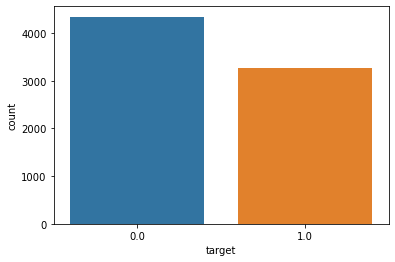

In [9]:
# Check out the (im)balance of the dataset
sns.countplot(x="target", data=data_raw)

In [10]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10876 entries, 1 to 10875
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   keyword   10789 non-null  object 
 1   location  7238 non-null   object 
 2   text      10876 non-null  object 
 3   target    7613 non-null   float64
dtypes: float64(1), object(3)
memory usage: 682.9+ KB


In [11]:
# Load the en_core_web_sm model
nlp = spacy.load('en_core_web_sm')

#### KEYWORD

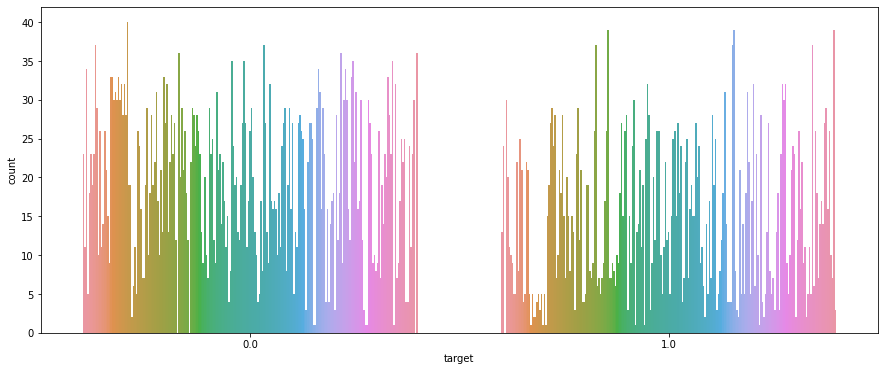

In [12]:
#Plot the count of real and unreal tweets per keyword
fig = plt.figure(figsize=(15,6))
sns.countplot(x="target", hue="keyword", data=data_raw)
plt.legend([],[], frameon=False)

In [13]:
data_raw['keyword'] = data_raw['keyword'].fillna("")

In [14]:
# Create a seperate dataframe for the keywords, where the keywords are hashed
data_Keyword=data_raw[['target','keyword']].copy()

fg = FeatureHasher(n_features=6, input_type='string')
hashed_features = fg.fit_transform(data_Keyword['keyword'])
hashed_features = hashed_features.toarray()

data_Keyword=pd.concat([data_Keyword, pd.DataFrame(hashed_features)], axis=1)

In [15]:
keywords = data_Keyword.columns.to_list()

In [16]:
keywords.remove('target')

In [17]:
keywords.remove('keyword')

In [18]:
keywords

[0, 1, 2, 3, 4, 5]

In [19]:
dependent = ['target']

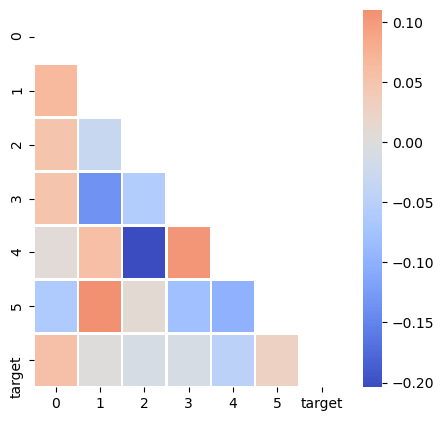

In [21]:
correlation = sorted(keywords) + dependent
correlation = data_Keyword[correlation].corr(method="spearman")
mask = np.triu(np.ones_like(correlation, dtype=bool))
fig = plt.figure(figsize=(5,5), dpi=100, facecolor = 'w', edgecolor="k")
figure = sns.heatmap(correlation, mask=mask, cmap= "coolwarm", center=0, linewidths=1, fmt=".2f")

In [22]:
data_raw.head()

,keyword,location,text,target
id,,,,
1,,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1.0
4,,NaN,Forest fire near La Ronge Sask. Canada,1.0
5,,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1.0
6,,NaN,"13,000 people receive #wildfires evacuation orders in California",1.0
7,,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1.0


#### COUNT WORDS

In [23]:
# Create a seperate column with the count of words within the tweet
data_raw['countWords'] = ''

def countWords(text):
    countWords = len(text.split(' '))
    return(countWords)

# Apply countWords to text
data_raw['countWords'] = data_raw['text'].apply(countWords)
data_raw.head()

,keyword,location,text,target,countWords
id,,,,,
1,,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1.0,13
4,,NaN,Forest fire near La Ronge Sask. Canada,1.0,7
5,,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1.0,22
6,,NaN,"13,000 people receive #wildfires evacuation orders in California",1.0,9
7,,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1.0,17


<AxesSubplot:xlabel='target', ylabel='count'>

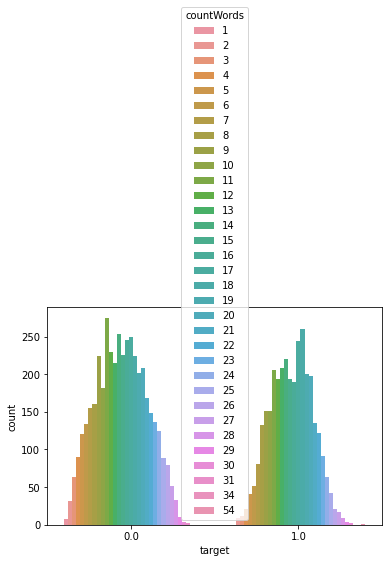

In [24]:
#Check out the distribution of the amount of words per disaster tweet/not a disastertweet
sns.countplot(x="target", hue="countWords", data=data_raw)

### AVG WORD LENGTH PER TWEET

In [25]:
# Create a seperate column with the average word length of the tweet

# Function to calculate the average length of the words within the tweet
def preprocess(text):
    counter = 0
    # Create Doc object
    doc = nlp(text, disable=['ner', 'parser'])
    # Generate lemmas
    lemmas = [token.lemma_ for token in doc]
    # Remove stopwords and non-alphabetic characters
    a_lemmas = [lemma for lemma in lemmas 
            if lemma.isalpha()]
    amountWords = len(a_lemmas)
    for lemma in a_lemmas:
        counter += len(lemma)
    if amountWords == 0:
        return(0)
    else:
        return(counter/amountWords)
  
# Apply preprocess to text
data_raw['AvgLengthWords'] = data_raw['text'].apply(preprocess)
data_raw.head()

,keyword,location,text,target,countWords,AvgLengthWords
id,,,,,,
1,,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1.0,13,4.153846
4,,NaN,Forest fire near La Ronge Sask. Canada,1.0,7,4.428571
5,,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1.0,22,4.318182
6,,NaN,"13,000 people receive #wildfires evacuation orders in California",1.0,9,6.857143
7,,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1.0,17,4.250000


<AxesSubplot:xlabel='AvgLengthWords', ylabel='Count'>

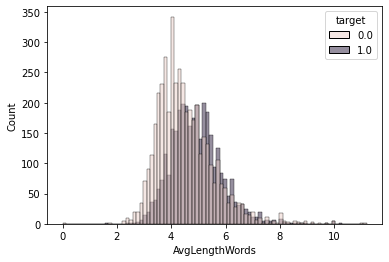

In [26]:
#Check out the distribution of the average length of words per disaster tweet/not a disastertweet
sns.histplot(data=data_raw, x="AvgLengthWords", hue='target')

#### COUNT STOPWORDS

In [27]:
# Create a seperate column with the amount of stopwords per tweet

# Function to count the amount of stopwords per tweet 
def preprocess(text):
    counter = 0
    # Create Doc object
    doc = nlp(text, disable=['ner', 'parser'])
    # Generate lemmas
    lemmas = [token.lemma_ for token in doc]
    # Remove stopwords and non-alphabetic characters
    a_lemmas = [lemma for lemma in lemmas 
            if lemma in stopwords]
    return(len(a_lemmas))
  
# Apply preprocess to text
data_raw['CountStopwords'] = data_raw['text'].apply(preprocess)
data_raw.head()

,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords
id,,,,,,,
1,,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1.0,13,4.153846,7
4,,NaN,Forest fire near La Ronge Sask. Canada,1.0,7,4.428571,0
5,,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1.0,22,4.318182,11
6,,NaN,"13,000 people receive #wildfires evacuation orders in California",1.0,9,6.857143,1
7,,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1.0,17,4.250000,8


<AxesSubplot:xlabel='CountStopwords', ylabel='count'>

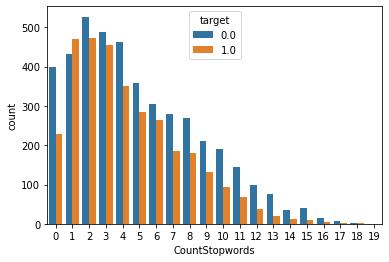

In [28]:
# Check out the distribution of the amount of stopwords per disaster tweet/not a disastertweet
sns.countplot(data=data_raw, x="CountStopwords", hue='target')

#### COUNT LEESTEKENS

In [29]:
# Create a seperate column with the amount of question marks and exclemation marks
def count_questionMarksAndExclamationMarks(string):
    counter = 0
    question = string.count("?")
    exclamation = string.count("!")
    counter = counter + question + exclamation
    return(counter)

data_raw['countLeestekens'] = data_raw['text'].apply(count_questionMarksAndExclamationMarks)

In [30]:
data_raw.groupby(['countLeestekens'])['text'].count()

countLeestekens
0     8497
1     1162
2      597
3      147
4      173
5       37
6      103
7       21
8       50
9       10
10      24
11       9
12      20
13       2
14       3
15       3
16       2
17       1
18       3
20       1
21       1
22       2
24       1
26       1
28       1
34       1
50       3
54       1
Name: text, dtype: int64

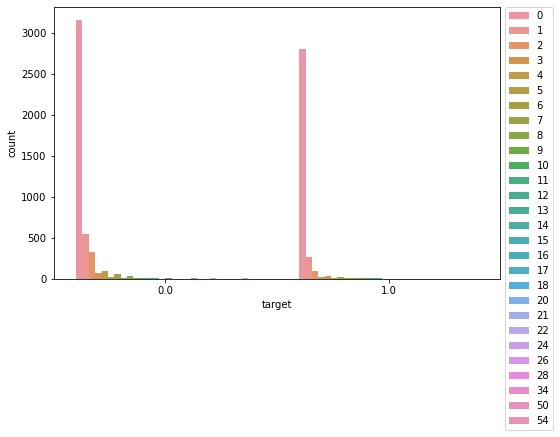

In [32]:
# Check out the distribution of the amount of ? and ! per disaster tweet/not a disastertweet
plt.figure(figsize=(8,5))
sns.countplot(x="target", hue="countLeestekens", data=data_raw)
plt.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0)

#### COUNT @

In [33]:
# Create a column with the count of @ within the tweets
def count_apenstaart(string):
    counter = 0
    apenstaart = string.count("@")
    counter = counter + apenstaart
    return(counter)

data_raw['count@'] = data_raw['text'].apply(count_apenstaart)

In [34]:
data_raw.groupby(['count@'])['text'].count()

count@
0     7901
1     2258
2      509
3      126
4       46
5       24
6        7
7        3
8        1
10       1
Name: text, dtype: int64

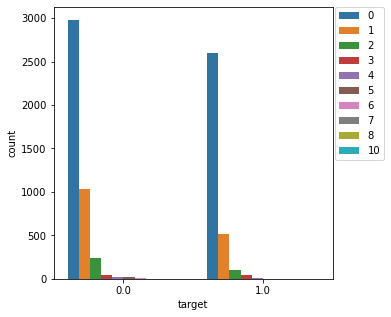

In [36]:
# Check out the distribution of the amount of @ per disaster tweet/not a disastertweet
plt.figure(figsize=(5,5))
sns.countplot(x="target", hue='count@', data=data_raw)
plt.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0)

#### COUNT HASHTAGS

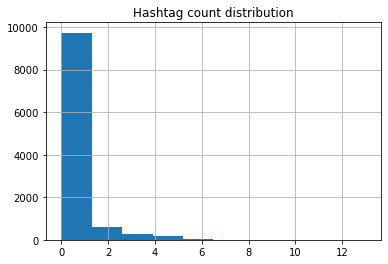

In [38]:
# Function that returns numner of hashtags in a string
def count_hashtags(string):
    # Split the string into words
    words = string.split()
    
    # Create a list of words that are hashtags
    hashtags = [word for word in words if word.startswith('#')]
    
    # Return number of hashtags
    return(len(hashtags))

# Create a feature hashtag_count and display distribution
data_raw['hashtag_count'] = data_raw['text'].apply(count_hashtags)
data_raw['hashtag_count'].hist()
plt.title('Hashtag count distribution')
plt.show()

In [39]:
# Function that returns numner of hashtags in a string
def count_hashtags(string):
    # Split the string into words
    words = string.split()
    
    # Create a list of words that are hashtags
    hashtags = [word for word in words if word.startswith('#')]
    
    # Return number of hashtags
    return(hashtags)

# Create a feature hashtag_count and display distribution
data_raw['hashtag'] = data_raw['text'].apply(count_hashtags)

In [40]:
data_raw.head()

,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,hashtag_count,hashtag
id,,,,,,,,,,,
1,,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1.0,13,4.153846,7,0,0,1,[#earthquake]
4,,NaN,Forest fire near La Ronge Sask. Canada,1.0,7,4.428571,0,0,0,0,[]
5,,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1.0,22,4.318182,11,0,0,0,[]
6,,NaN,"13,000 people receive #wildfires evacuation orders in California",1.0,9,6.857143,1,0,0,1,[#wildfires]
7,,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1.0,17,4.250000,8,0,0,2,"[#Alaska, #wildfires]"


<AxesSubplot:xlabel='target', ylabel='count'>

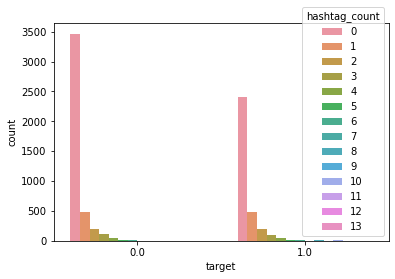

In [41]:
# Check out the distribution of the amount of hashtags per disaster tweet/not a disastertweet
sns.countplot(x="target", hue="hashtag_count", data=data_raw)

In [42]:
data_raw['tokenized'] = data_raw['text'].apply(lambda x: nlp.tokenizer(x))

In [43]:
data_raw['transcript'] = ''
# Function to preprocess text and create a column of lemmatized tweets
def preprocess(text):
    # Create Doc object
    doc = nlp(text, disable=['ner', 'parser'])
    # Generate lemmas
    lemmas = [token.lemma_ for token in doc]
    # Remove stopwords and non-alphabetic characters
    a_lemmas = [lemma for lemma in lemmas 
            if lemma.isalpha()]
    return ' '.join(a_lemmas)
  
# Apply preprocess to text
data_raw['transcript'] = data_raw['text'].apply(preprocess)
data_raw.head()

,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,hashtag_count,hashtag,tokenized,transcript
id,,,,,,,,,,,,,
1,,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1.0,13,4.153846,7,0,0,1,[#earthquake],"(Our, Deeds, are, the, Reason, of, this, #, earthquake, May, ALLAH, Forgive, us, all)",our deed be the Reason of this earthquake may ALLAH forgive we all
4,,NaN,Forest fire near La Ronge Sask. Canada,1.0,7,4.428571,0,0,0,0,[],"(Forest, fire, near, La, Ronge, Sask, ., Canada)",forest fire near La Ronge Sask Canada
5,,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1.0,22,4.318182,11,0,0,0,[],"(All, residents, asked, to, ', shelter, in, place, ', are, being, notified, by, officers, ., No, other, evacuation, or, shelter, in, place, orders, are, expected)",all resident ask to shelter in place be be notify by officer no other evacuation or shelter in place order be expect
6,,NaN,"13,000 people receive #wildfires evacuation orders in California",1.0,9,6.857143,1,0,0,1,[#wildfires],"(13,000, people, receive, #, wildfires, evacuation, orders, in, California)",people receive wildfire evacuation order in California
7,,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1.0,17,4.250000,8,0,0,2,"[#Alaska, #wildfires]","(Just, got, sent, this, photo, from, Ruby, #, Alaska, as, smoke, from, #, wildfires, pours, into, a, school)",just get send this photo from Ruby Alaska as smoke from wildfire pour into a school


In [44]:
data_raw['numbers'] = ''
# Function to preprocess text and create a column of numbers that occur in tweets
def preprocess(text):
    # Create Doc object
    doc = nlp(text, disable=['ner', 'parser'])
    # Generate lemmas
    tokens = [token.lemma_ for token in doc if token.like_num]
    n_lemmas = [lemma for lemma in tokens]
    return ' '.join(n_lemmas)
  
# Apply preprocess to text
data_raw['numbers'] = data_raw['text'].apply(preprocess)
data_raw.head()

,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,hashtag_count,hashtag,tokenized,transcript,numbers
id,,,,,,,,,,,,,,
1,,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1.0,13,4.153846,7,0,0,1,[#earthquake],"(Our, Deeds, are, the, Reason, of, this, #, earthquake, May, ALLAH, Forgive, us, all)",our deed be the Reason of this earthquake may ALLAH forgive we all,
4,,NaN,Forest fire near La Ronge Sask. Canada,1.0,7,4.428571,0,0,0,0,[],"(Forest, fire, near, La, Ronge, Sask, ., Canada)",forest fire near La Ronge Sask Canada,
5,,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1.0,22,4.318182,11,0,0,0,[],"(All, residents, asked, to, ', shelter, in, place, ', are, being, notified, by, officers, ., No, other, evacuation, or, shelter, in, place, orders, are, expected)",all resident ask to shelter in place be be notify by officer no other evacuation or shelter in place order be expect,
6,,NaN,"13,000 people receive #wildfires evacuation orders in California",1.0,9,6.857143,1,0,0,1,[#wildfires],"(13,000, people, receive, #, wildfires, evacuation, orders, in, California)",people receive wildfire evacuation order in California,"13,000"
7,,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1.0,17,4.250000,8,0,0,2,"[#Alaska, #wildfires]","(Just, got, sent, this, photo, from, Ruby, #, Alaska, as, smoke, from, #, wildfires, pours, into, a, school)",just get send this photo from Ruby Alaska as smoke from wildfire pour into a school,


In [45]:
data_raw.groupby(['numbers'])['location'].count()

numbers
                5494
+54 -9 6           1
-10                1
-26                0
-3.43              1
                ... 
two two 5 10       1
zero               1
zero 1979          1
~11 95             1
~27 ~80            1
Name: location, Length: 852, dtype: int64

In [46]:
# Create a boolean column with a 1 if the tweet contains a number and a 0 if it does not
data_raw['numberPresent'] = data_raw.apply(lambda row: 1 if row.numbers != "" else 0, axis=1)

<AxesSubplot:xlabel='target', ylabel='count'>

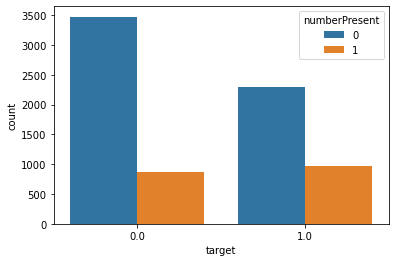

In [47]:
# Check out the distribution of tweets that contain a number, per disaster tweet/not a disastertweet
sns.countplot(x="target", hue="numberPresent", data=data_raw)

#### UPPERCASE

In [48]:
data_raw['upper'] = ''
# Function to preprocess text and create a column of upper words that occur in tweets
def preprocess(text):
    # Create Doc object
    doc = nlp(text, disable=['ner', 'parser'])
    # Generate lemmas
    tokens = [token.lemma_ for token in doc if token.is_upper]
    n_lemmas = [lemma for lemma in tokens]
    return ' '.join(n_lemmas)
  
# Apply preprocess to text
data_raw['upper'] = data_raw['text'].apply(preprocess)
data_raw.head()

,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,hashtag_count,hashtag,tokenized,transcript,numbers,numberPresent,upper
id,,,,,,,,,,,,,,,,
1,,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1.0,13,4.153846,7,0,0,1,[#earthquake],"(Our, Deeds, are, the, Reason, of, this, #, earthquake, May, ALLAH, Forgive, us, all)",our deed be the Reason of this earthquake may ALLAH forgive we all,,0,ALLAH
4,,NaN,Forest fire near La Ronge Sask. Canada,1.0,7,4.428571,0,0,0,0,[],"(Forest, fire, near, La, Ronge, Sask, ., Canada)",forest fire near La Ronge Sask Canada,,0,
5,,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1.0,22,4.318182,11,0,0,0,[],"(All, residents, asked, to, ', shelter, in, place, ', are, being, notified, by, officers, ., No, other, evacuation, or, shelter, in, place, orders, are, expected)",all resident ask to shelter in place be be notify by officer no other evacuation or shelter in place order be expect,,0,
6,,NaN,"13,000 people receive #wildfires evacuation orders in California",1.0,9,6.857143,1,0,0,1,[#wildfires],"(13,000, people, receive, #, wildfires, evacuation, orders, in, California)",people receive wildfire evacuation order in California,"13,000",1,
7,,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1.0,17,4.250000,8,0,0,2,"[#Alaska, #wildfires]","(Just, got, sent, this, photo, from, Ruby, #, Alaska, as, smoke, from, #, wildfires, pours, into, a, school)",just get send this photo from Ruby Alaska as smoke from wildfire pour into a school,,0,


In [49]:
# Create a seperate boolean column that contains a 1 if a tweet contains uppercase words and a 0 if it does not
data_raw['upperPresent'] = data_raw.apply(lambda row: 1 if row.upper != "" else 0, axis=1)

<AxesSubplot:xlabel='target', ylabel='count'>

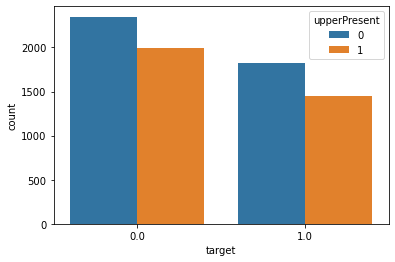

In [50]:
# Check out the count of tweets with and without uppercase words
sns.countplot(x="target", hue="upperPresent", data=data_raw)

In [51]:
# Function to preprocess text and create a column of upper words count in tweets
def preprocess(text):
    counter = 0
    # Create Doc object
    doc = nlp(text, disable=['ner', 'parser'])
    # Generate tokens
    tokens = [token for token in doc]
    for token in tokens:
        counter += 1
    return(counter)
  
# Apply preprocess to text
data_raw['upperCount'] = data_raw['upper'].apply(preprocess)
data_raw.head()

,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,hashtag_count,hashtag,tokenized,transcript,numbers,numberPresent,upper,upperPresent,upperCount
id,,,,,,,,,,,,,,,,,,
1,,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1.0,13,4.153846,7,0,0,1,[#earthquake],"(Our, Deeds, are, the, Reason, of, this, #, earthquake, May, ALLAH, Forgive, us, all)",our deed be the Reason of this earthquake may ALLAH forgive we all,,0,ALLAH,1,1
4,,NaN,Forest fire near La Ronge Sask. Canada,1.0,7,4.428571,0,0,0,0,[],"(Forest, fire, near, La, Ronge, Sask, ., Canada)",forest fire near La Ronge Sask Canada,,0,,0,0
5,,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1.0,22,4.318182,11,0,0,0,[],"(All, residents, asked, to, ', shelter, in, place, ', are, being, notified, by, officers, ., No, other, evacuation, or, shelter, in, place, orders, are, expected)",all resident ask to shelter in place be be notify by officer no other evacuation or shelter in place order be expect,,0,,0,0
6,,NaN,"13,000 people receive #wildfires evacuation orders in California",1.0,9,6.857143,1,0,0,1,[#wildfires],"(13,000, people, receive, #, wildfires, evacuation, orders, in, California)",people receive wildfire evacuation order in California,"13,000",1,,0,0
7,,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1.0,17,4.250000,8,0,0,2,"[#Alaska, #wildfires]","(Just, got, sent, this, photo, from, Ruby, #, Alaska, as, smoke, from, #, wildfires, pours, into, a, school)",just get send this photo from Ruby Alaska as smoke from wildfire pour into a school,,0,,0,0


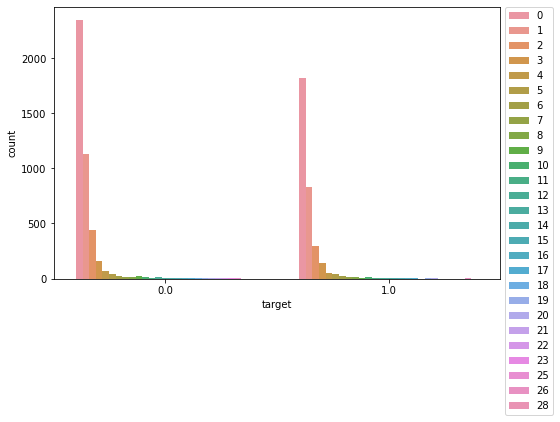

In [52]:
# Check out the distribution of the amount of uppercase words per disaster tweet/not a disastertweet
plt.figure(figsize=(8,5))
sns.countplot(x="target", hue="upperCount", data=data_raw)
plt.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0)

#### LOCATION

In [53]:
data_raw.groupby(['location'])['keyword'].count()

location
                                  1
                                  1
                           FLA    1
             Waiheke Island       1
   Manchester/Nantwich            1
                                 ..
å_å_Los Mina Cityã¢              1
å¡å¡Midwest Û¢Û¢                1
å©hicago                          1
åÊ(?Û¢`?Û¢å«)??                 1
åø\_(?)_/åø                       1
Name: keyword, Length: 4521, dtype: int64

In [54]:
data_raw['location'] = data_raw['location'].fillna("")

In [55]:
# Create a seperate column that contains 1 if a location is given and a 0 if not
data_raw['locationPresent'] = data_raw.apply(lambda row: 0 if row.location == "" else 1, axis=1)

<AxesSubplot:xlabel='target', ylabel='count'>

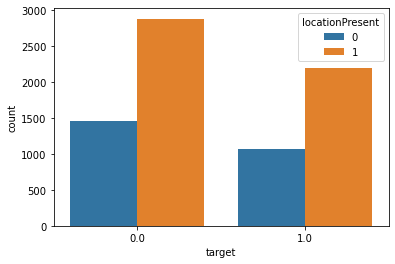

In [56]:
# Check out the distribution of the presence or absence of a location in a tweet/not differs
sns.countplot(x="target", hue="locationPresent", data=data_raw)

In [57]:
data_raw['LocationTranscript'] = ''
# Function to preprocess text and create a column of lemmatized locations
def preprocess(text):
    # Create Doc object
    doc = nlp(text, disable=['ner', 'parser'])
    # Generate lemmas
    lemmas = [token.lemma_ for token in doc]
    # Remove stopwords and non-alphabetic characters
    a_lemmas = [lemma for lemma in lemmas 
            if lemma.isalpha()]
    return ' '.join(a_lemmas)
  
# Apply preprocess to text
data_raw['LocationTranscript'] = data_raw['location'].apply(preprocess)
data_raw.head()

,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,hashtag_count,hashtag,tokenized,transcript,numbers,numberPresent,upper,upperPresent,upperCount,locationPresent,LocationTranscript
id,,,,,,,,,,,,,,,,,,,,
1,,,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1.0,13,4.153846,7,0,0,1,[#earthquake],"(Our, Deeds, are, the, Reason, of, this, #, earthquake, May, ALLAH, Forgive, us, all)",our deed be the Reason of this earthquake may ALLAH forgive we all,,0,ALLAH,1,1,0,
4,,,Forest fire near La Ronge Sask. Canada,1.0,7,4.428571,0,0,0,0,[],"(Forest, fire, near, La, Ronge, Sask, ., Canada)",forest fire near La Ronge Sask Canada,,0,,0,0,0,
5,,,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1.0,22,4.318182,11,0,0,0,[],"(All, residents, asked, to, ', shelter, in, place, ', are, being, notified, by, officers, ., No, other, evacuation, or, shelter, in, place, orders, are, expected)",all resident ask to shelter in place be be notify by officer no other evacuation or shelter in place order be expect,,0,,0,0,0,
6,,,"13,000 people receive #wildfires evacuation orders in California",1.0,9,6.857143,1,0,0,1,[#wildfires],"(13,000, people, receive, #, wildfires, evacuation, orders, in, California)",people receive wildfire evacuation order in California,"13,000",1,,0,0,0,
7,,,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1.0,17,4.250000,8,0,0,2,"[#Alaska, #wildfires]","(Just, got, sent, this, photo, from, Ruby, #, Alaska, as, smoke, from, #, wildfires, pours, into, a, school)",just get send this photo from Ruby Alaska as smoke from wildfire pour into a school,,0,,0,0,0,


In [58]:
data_raw.groupby(['LocationTranscript'])['keyword'].count()

LocationTranscript
               3892
ACCRA GHANA       1
AEP               1
AFRICA            1
AG                1
               ... 
å                 1
å hicago          1
å ÌÑ              1
å å               3
åá NY             1
Name: keyword, Length: 4026, dtype: int64

#### URL

In [59]:
data_raw['URL'] = ''
# Function to preprocess text and create a column of URLs that occur in tweets
def preprocess(text):
    # Create Doc object
    doc = nlp(text, disable=['ner', 'parser'])
    # Generate lemmas
    tokens = [token.lemma_ for token in doc if token.like_url]
    n_lemmas = [lemma for lemma in tokens]
    return ' '.join(n_lemmas)
  
# Apply preprocess to text
data_raw['URL'] = data_raw['text'].apply(preprocess)
data_raw.head()

,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,hashtag_count,...,tokenized,transcript,numbers,numberPresent,upper,upperPresent,upperCount,locationPresent,LocationTranscript,URL
id,,,,,,,,,,,,,,,,,,,,,
1,,,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1.0,13,4.153846,7,0,0,1,...,"(Our, Deeds, are, the, Reason, of, this, #, earthquake, May, ALLAH, Forgive, us, all)",our deed be the Reason of this earthquake may ALLAH forgive we all,,0,ALLAH,1,1,0,,
4,,,Forest fire near La Ronge Sask. Canada,1.0,7,4.428571,0,0,0,0,...,"(Forest, fire, near, La, Ronge, Sask, ., Canada)",forest fire near La Ronge Sask Canada,,0,,0,0,0,,
5,,,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1.0,22,4.318182,11,0,0,0,...,"(All, residents, asked, to, ', shelter, in, place, ', are, being, notified, by, officers, ., No, other, evacuation, or, shelter, in, place, orders, are, expected)",all resident ask to shelter in place be be notify by officer no other evacuation or shelter in place order be expect,,0,,0,0,0,,
6,,,"13,000 people receive #wildfires evacuation orders in California",1.0,9,6.857143,1,0,0,1,...,"(13,000, people, receive, #, wildfires, evacuation, orders, in, California)",people receive wildfire evacuation order in California,"13,000",1,,0,0,0,,
7,,,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1.0,17,4.250000,8,0,0,2,...,"(Just, got, sent, this, photo, from, Ruby, #, Alaska, as, smoke, from, #, wildfires, pours, into, a, school)",just get send this photo from Ruby Alaska as smoke from wildfire pour into a school,,0,,0,0,0,,


In [60]:
# Create a seperate column that holds a 1 if the tweet contains an URL and a zero if it does not
data_raw['URLPresent'] = data_raw.apply(lambda row: 0 if row.URL == "" else 1, axis=1)

In [61]:
data_raw.head()

,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,hashtag_count,...,transcript,numbers,numberPresent,upper,upperPresent,upperCount,locationPresent,LocationTranscript,URL,URLPresent
id,,,,,,,,,,,,,,,,,,,,,
1,,,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1.0,13,4.153846,7,0,0,1,...,our deed be the Reason of this earthquake may ALLAH forgive we all,,0,ALLAH,1,1,0,,,0
4,,,Forest fire near La Ronge Sask. Canada,1.0,7,4.428571,0,0,0,0,...,forest fire near La Ronge Sask Canada,,0,,0,0,0,,,0
5,,,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1.0,22,4.318182,11,0,0,0,...,all resident ask to shelter in place be be notify by officer no other evacuation or shelter in place order be expect,,0,,0,0,0,,,0
6,,,"13,000 people receive #wildfires evacuation orders in California",1.0,9,6.857143,1,0,0,1,...,people receive wildfire evacuation order in California,"13,000",1,,0,0,0,,,0
7,,,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1.0,17,4.250000,8,0,0,2,...,just get send this photo from Ruby Alaska as smoke from wildfire pour into a school,,0,,0,0,0,,,0


<AxesSubplot:xlabel='target', ylabel='count'>

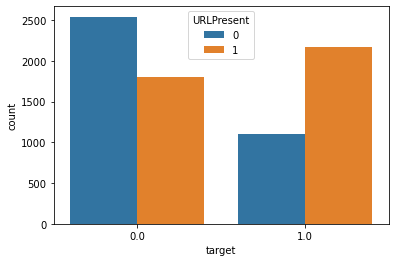

In [62]:
# Check out the distribution of the presence or absence of an URL in a tweet/not differs
sns.countplot(x="target", hue="URLPresent", data=data_raw)

In [63]:
# Function to preprocess text and create a column of URL count in tweets
def preprocess(text):
    counter = 0
    # Create Doc object
    doc = nlp(text, disable=['ner', 'parser'])
    # Generate lemmas
    tokens = [token for token in doc]
    for token in tokens:
        counter += 1
    return(counter)
  
# Apply preprocess to text
data_raw['URLcount'] = data_raw['URL'].apply(preprocess)
data_raw.head()

,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,hashtag_count,...,numbers,numberPresent,upper,upperPresent,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount
id,,,,,,,,,,,,,,,,,,,,,
1,,,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1.0,13,4.153846,7,0,0,1,...,,0,ALLAH,1,1,0,,,0,0
4,,,Forest fire near La Ronge Sask. Canada,1.0,7,4.428571,0,0,0,0,...,,0,,0,0,0,,,0,0
5,,,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1.0,22,4.318182,11,0,0,0,...,,0,,0,0,0,,,0,0
6,,,"13,000 people receive #wildfires evacuation orders in California",1.0,9,6.857143,1,0,0,1,...,"13,000",1,,0,0,0,,,0,0
7,,,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1.0,17,4.250000,8,0,0,2,...,,0,,0,0,0,,,0,0


<AxesSubplot:xlabel='target', ylabel='count'>

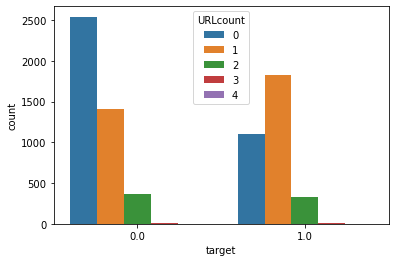

In [64]:
# Check out the distribution of the URL count per tweet
sns.countplot(x="target", hue="URLcount", data=data_raw)

In [65]:
data_raw.loc[data_raw['URLPresent']==1].head(15)

,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,hashtag_count,...,numbers,numberPresent,upper,upperPresent,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount
id,,,,,,,,,,,,,,,,,,,,,
48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C,1.0,5,7.333333,0,0,1,0,...,,0,,0,0,1,Birmingham,http://t.co/lhyxeohy6c,1,1
49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw,0.0,10,3.666667,3,0,0,2,...,,0,RT,1,1,1,Est September bristol,http://t.co/YAo1e0xngw,1,1
50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi,1.0,9,5.333333,1,0,0,1,...,,0,AFRICANBAZE,1,1,1,AFRICA,http://t.co/2nndBGwyEi,1,1
53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N,0.0,13,3.416667,5,0,0,0,...,,0,LOOK at the SKY last night it be ABLAZE,1,9,1,London UK,http://t.co/qqsmshaJ3N,1,1
55,ablaze,World Wide!!,INEC Office in Abia Set Ablaze - http://t.co/3ImaomknnA,1.0,8,4.166667,1,0,0,0,...,,0,INEC,1,1,1,World Wide,http://t.co/3ImaomknnA,1,1
56,ablaze,,Barbados #Bridgetown JAMAICA ÛÒ Two cars set ablaze: SANTA CRUZ ÛÓ Head of the St Elizabeth Police Superintende... http://t.co/wDUEaj8Q4J,1.0,20,5.375000,2,0,0,1,...,two,1,JAMAICA ûò SANTA CRUZ ûó,1,5,0,,http://t.co/wdueaj8q4j,1,1
59,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw,0.0,8,4.250000,2,0,0,1,...,,0,,0,0,1,live on Webcam,http://t.co/roi2nsmejj http://t.co/3Tj8ZjiN21 http://t.co/yduixefipe http://t.co/lxtjc87kl,1,4
64,ablaze,,I wanted to set Chicago ablaze with my preaching... But not my hotel! http://t.co/o9qknbfOFX,0.0,14,3.923077,6,1,0,0,...,,0,I,1,1,0,,http://t.co/o9qknbfofx,1,1
65,ablaze,,I gained 3 followers in the last week. You? Know your stats and grow with http://t.co/TIyUliF5c6,0.0,16,3.714286,6,1,0,0,...,3,1,I,1,1,0,,http://t.co/tiyulif5c6,1,1


#### TAGS

In [66]:
data_raw['TAG'] = ''
# Create a column with all SpaCy tags for each word in tweets
def preprocessTAG(text):
    doc = nlp(text, disable=['ner', 'parser'])
    tags = [token.tag_ for token in doc]
    return ' '.join(tags)

data_raw['TAG']= data_raw['text'].apply(preprocessTAG)
data_raw.head()

,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,hashtag_count,...,numberPresent,upper,upperPresent,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG
id,,,,,,,,,,,,,,,,,,,,,
1,,,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1.0,13,4.153846,7,0,0,1,...,0,ALLAH,1,1,0,,,0,0,PRP$ NNS VBP DT NNP IN DT JJ NN MD NNP VB PRP DT
4,,,Forest fire near La Ronge Sask. Canada,1.0,7,4.428571,0,0,0,0,...,0,,0,0,0,,,0,0,NN NN IN NNP NNP NNP . NNP
5,,,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1.0,22,4.318182,11,0,0,0,...,0,,0,0,0,,,0,0,DT NNS VBD IN `` NN IN NN '' VBP VBG VBN IN NNS . DT JJ NN CC NN IN NN NNS VBP VBN
6,,,"13,000 people receive #wildfires evacuation orders in California",1.0,9,6.857143,1,0,0,1,...,1,,0,0,0,,,0,0,CD NNS VBP $ VBZ NN NNS IN NNP
7,,,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1.0,17,4.250000,8,0,0,2,...,0,,0,0,0,,,0,0,RB VBD VBN DT NN IN NNP NNP NNP IN NN IN PRP VBZ NNS IN DT NN


In [67]:
listOfTags = []

# Create a list of unique tags that occur for all the tweets
def createListOfTags(text):
    doc = nlp(text, disable=['ner', 'parser'])
    lemmas = [token.lemma_ for token in doc]
    for lemma in lemmas:
        if lemma not in listOfTags:
            listOfTags.append(lemma)

data_raw['TAG'].apply(createListOfTags)

id
1        None
4        None
5        None
6        None
7        None
         ... 
10861    None
10865    None
10868    None
10874    None
10875    None
Name: TAG, Length: 10876, dtype: object

In [68]:
len(listOfTags)

81

#### NER

In [69]:
data_raw['NER_label'] = ''
# create a column with all NER labels that occur in the tweets
def preprocessNER(text):
    doc = nlp(text, disable=['parser'])
    tags = [ent.label_ for ent in doc.ents]
    return ' '.join(tags)

data_raw['NER_label']= data_raw['text'].apply(preprocessNER)
data_raw.head()

,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,hashtag_count,...,upper,upperPresent,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label
id,,,,,,,,,,,,,,,,,,,,,
1,,,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1.0,13,4.153846,7,0,0,1,...,ALLAH,1,1,0,,,0,0,PRP$ NNS VBP DT NNP IN DT JJ NN MD NNP VB PRP DT,ORG
4,,,Forest fire near La Ronge Sask. Canada,1.0,7,4.428571,0,0,0,0,...,,0,0,0,,,0,0,NN NN IN NNP NNP NNP . NNP,FAC GPE
5,,,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1.0,22,4.318182,11,0,0,0,...,,0,0,0,,,0,0,DT NNS VBD IN `` NN IN NN '' VBP VBG VBN IN NNS . DT JJ NN CC NN IN NN NNS VBP VBN,
6,,,"13,000 people receive #wildfires evacuation orders in California",1.0,9,6.857143,1,0,0,1,...,,0,0,0,,,0,0,CD NNS VBP $ VBZ NN NNS IN NNP,CARDINAL GPE
7,,,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1.0,17,4.250000,8,0,0,2,...,,0,0,0,,,0,0,RB VBD VBN DT NN IN NNP NNP NNP IN NN IN PRP VBZ NNS IN DT NN,FAC GPE CARDINAL


In [70]:
data_raw['NER_text'] = ''
# Create a column of all words that are connected to the labels in the tweets
def preprocessNER(text):
    doc = nlp(text, disable=['parser'])
    tags = [ent.text for ent in doc.ents]
    return ' '.join(tags)

data_raw['NER_text']= data_raw['text'].apply(preprocessNER)
data_raw.head()

,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,hashtag_count,...,upperPresent,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text
id,,,,,,,,,,,,,,,,,,,,,
1,,,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1.0,13,4.153846,7,0,0,1,...,1,1,0,,,0,0,PRP$ NNS VBP DT NNP IN DT JJ NN MD NNP VB PRP DT,ORG,May ALLAH Forgive
4,,,Forest fire near La Ronge Sask. Canada,1.0,7,4.428571,0,0,0,0,...,0,0,0,,,0,0,NN NN IN NNP NNP NNP . NNP,FAC GPE,La Ronge Sask Canada
5,,,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1.0,22,4.318182,11,0,0,0,...,0,0,0,,,0,0,DT NNS VBD IN `` NN IN NN '' VBP VBG VBN IN NNS . DT JJ NN CC NN IN NN NNS VBP VBN,,
6,,,"13,000 people receive #wildfires evacuation orders in California",1.0,9,6.857143,1,0,0,1,...,0,0,0,,,0,0,CD NNS VBP $ VBZ NN NNS IN NNP,CARDINAL GPE,"13,000 California"
7,,,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1.0,17,4.250000,8,0,0,2,...,0,0,0,,,0,0,RB VBD VBN DT NN IN NNP NNP NNP IN NN IN PRP VBZ NNS IN DT NN,FAC GPE CARDINAL,Ruby # Alaska #


In [71]:
listOfLabels = []

# Create a list of unique labels that occur for all the tweets
def createListOfLabels(text):
    doc = nlp(text, disable=['ner', 'parser'])
    lemmas = [token.lemma_ for token in doc]
    for lemma in lemmas:
        if lemma not in listOfLabels:
            listOfLabels.append(lemma)

data_raw['NER_label'].apply(createListOfLabels)

id
1        None
4        None
5        None
6        None
7        None
         ... 
10861    None
10865    None
10868    None
10874    None
10875    None
Name: NER_label, Length: 10876, dtype: object

In [72]:
len(listOfLabels)

33

In [73]:
listOfNERtext = []

# Create a list of unique words connected to the labels that occur for all the tweets
def createListOfNERlabel(text):
    doc = nlp(text, disable=['ner', 'parser'])
    lemmas = [token.lemma_ for token in doc]
    for lemma in lemmas:
        if lemma not in listOfNERtext:
            listOfNERtext.append(lemma)

data_raw['NER_text'].apply(createListOfNERlabel)

id
1        None
4        None
5        None
6        None
7        None
         ... 
10861    None
10865    None
10868    None
10874    None
10875    None
Name: NER_text, Length: 10876, dtype: object

In [74]:
len(listOfNERtext)

8356

In [75]:
# Create a dict that counts the amount of time a word occurs in all tweets (from the words connected to the NER labels)
dict_NERwords = defaultdict(int)
def preprocess(text):
    # Create Doc object
    doc = nlp(text, disable=['ner', 'parser'])
    # Generate lemmas
    lemmas = [token.lemma_ for token in doc]
    for lemma in lemmas:
        if lemma in dict_NERwords:
            dict_NERwords[lemma] += 1
        else:
            dict_NERwords[lemma] = 1
  
# Apply preprocess to text
data_raw['NER_text'].apply(preprocess)

id
1        None
4        None
5        None
6        None
7        None
         ... 
10861    None
10865    None
10868    None
10874    None
10875    None
Name: NER_text, Length: 10876, dtype: object

In [76]:
def get_top_words(dict_words, n=100, order=False):
    top = sorted(dict_words.items(), key=lambda x: x[1], reverse=True)[:n]
    if order:
        return OrderedDict(top)
    return dict(top)

In [77]:
# Only keep the top 100 words in the dict
dict_NERwords = get_top_words(dict_NERwords)

In [78]:
dict_NERwords

{'#': 1895,
 '-': 561,
 'the': 457,
 'year': 208,
 '2': 192,
 '&': 156,
 'two': 148,
 'of': 146,
 'California': 145,
 'this': 137,
 '3': 136,
 'a': 136,
 'Hiroshima': 134,
 'today': 124,
 'one': 124,
 'first': 114,
 "'": 82,
 'day': 81,
 "'s": 81,
 '5': 78,
 '4': 73,
 '1': 73,
 'last': 70,
 ':': 68,
 '2015': 68,
 'News': 66,
 'week': 64,
 'US': 64,
 'Army': 63,
 'Malaysia': 63,
 '70': 60,
 'tonight': 59,
 'than': 59,
 'Obama': 59,
 '%': 59,
 'to': 58,
 'Japan': 57,
 'Forest': 56,
 'RT': 55,
 'hundred': 54,
 'National': 53,
 '11': 52,
 'old': 52,
 '/': 50,
 'China': 48,
 '15': 47,
 '40': 46,
 'August': 46,
 'PKK': 46,
 'summer': 45,
 'second': 45,
 'in': 45,
 'New': 43,
 'hour': 43,
 'mh370': 43,
 'U.S.': 42,
 'Turkey': 42,
 '16yr': 42,
 'County': 41,
 'three': 41,
 'pm': 41,
 'River': 41,
 'up': 41,
 'about': 40,
 'Iran': 40,
 'Fire': 40,
 'night': 39,
 'for': 39,
 'Northern': 38,
 '6': 38,
 'More': 38,
 'sandstorm': 38,
 'Island': 37,
 'tomorrow': 37,
 'ago': 37,
 'half': 37,
 'Wildfi

#### LOOK FOR DOUBLE TWEETS (RT)

In [79]:
textList = data_raw['transcript'].tolist()

In [80]:
# Create a dict with the counts per tweet (see if there are transcripts that occure more than once, a.k.a. retweets)
dictText = Counter(textList)

In [81]:
dictText2 = {}

In [82]:
# Filter the dictText dict so that the new dict only contains tweets that occur more often
for k, v in sorted(dictText.items(), reverse=True):
    if v > 1:
        dictText2[k] = v

In [83]:
data_New = data_raw.reset_index()

In [84]:
def doubles(text):
    if text in dictText2:
        return(dictText2[text])
    else:
        return(1)
  
# Apply doubles to text
data_New['countTweets'] = data_New['transcript'].apply(doubles)

<AxesSubplot:xlabel='target', ylabel='count'>

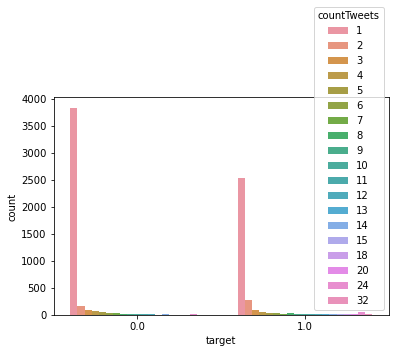

In [85]:
# Check out the distribution of the retweets (countTweets) for both disaster tweets and non-disaster tweets
sns.countplot(x="target", hue="countTweets", data=data_New)

In [86]:
data_New.groupby(['countTweets'])['id'].count()

countTweets
1     9115
2      618
3      237
4      176
5      140
6       78
7       77
8       56
9       18
10      50
11      44
12      36
13      13
14      28
15      30
18      36
20      20
24      72
32      32
Name: id, dtype: int64

In [415]:
for x in range(len(textList)-1):
    count = 0
    countNaN = 0
    listIndex = []
    if data_New['target'].loc[x] == 0 or data_New['target'].loc[x] == 1:
        if data_New['countTweets'].loc[x] > 1:
            count += data_New['target'].loc[x]
            listIndex.append(x)
            #print('1:', x, count, data_New['target'].loc[x])
    else:
        countNaN += 1
        listIndex.append(x)
        #print('2:', x, countNaN)
    
    for y in range(len(textList)-1):
        if (x != y) and (textList[x] == textList[y]):
            if data_New['target'].loc[y] == 0 or data_New['target'].loc[y] == 1:
                count += data_New['target'].loc[y]
                listIndex.append(y)
                #print('3: ', y, count)
            else:
                countNaN += 1
                listIndex.append(x)
                #print('4: ', y, countNaN)
                
    for z in listIndex:
        #data_New.loc[z, 'countReal'] = count
        #data_New.loc[z, 'countUK'] = countNaN
        if (len(listIndex)-countNaN) != 0:
            data_New.loc[z, 'mean'] = (count)/(len(listIndex)-countNaN)

In [95]:
# Looking at the tweets that occur more often, it becomes apparant that some of them have been misclassified
# There is one tweet that occurs 32 times. These are all classified in the same way: "disaster"
# There are three different tweets that occur 24 times each.The classification is not consistent for one of them.
data_New.loc[(data_New['countTweets']==24) & (data_New['keyword']=='hijacking') & (data_New['target'].notna())]

,id,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,...,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text,countTweets
4391,6243,hijacking,"perth, australia",#hot Funtenna: hijacking computers to send data as sound waves [Black Hat 2015] http://t.co/gUJNPLJVvt #prebreak #best,0.0,17,4.785714,2,0,0,...,0,1,perth australia,http://t.co/gUJNPLJVvt,1,1,$ JJ _SP NNP : VBG NNS TO VB NNS IN JJ NNS -LRB- NNP NNP CD -RRB- NNP NN VB RB JJS,CARDINAL ORG CARDINAL CARDINAL,# Funtenna # #,24
4392,6244,hijacking,Mongolia,#hot Funtenna: hijacking computers to send data as sound waves [Black Hat 2015] http://t.co/J2aQs5loxu #prebreak #best,1.0,17,4.785714,2,0,0,...,0,1,Mongolia,http://t.co/J2aQs5loxu,1,1,$ JJ _SP NNP : VBG NNS TO VB NNS IN JJ NNS -LRB- NNP NNP CD -RRB- NNP NN VB RB JJS,CARDINAL ORG CARDINAL,# Funtenna #,24
4393,6245,hijacking,"brisbane, australia",#hot Funtenna: hijacking computers to send data as sound waves [Black Hat 2015] http://t.co/s4PNIhJQX7 #prebreak #best,0.0,17,4.785714,2,0,0,...,0,1,brisbane australia,http://t.co/s4PNIhJQX7,1,1,$ JJ _SP NNP : VBG NNS TO VB NNS IN JJ NNS -LRB- NNP NNP CD -RRB- NNP NN VBP RB JJS,CARDINAL ORG DATE CARDINAL CARDINAL,# Funtenna 2015 # #,24
4394,6246,hijacking,China,#hot Funtenna: hijacking computers to send data as sound waves [Black Hat 2015] http://t.co/cx6auPneMu #prebreak #best,0.0,17,4.785714,2,0,0,...,0,1,China,http://t.co/cx6auPneMu,1,1,$ JJ _SP NNP : VBG NNS TO VB NNS IN JJ NNS -LRB- NNP NNP CD -RRB- NNP NNS VB RB JJS,CARDINAL ORG CARDINAL CARDINAL,# Funtenna # #,24
4396,6248,hijacking,"Chiyoda Ward, Tokyo",#hot Funtenna: hijacking computers to send data as sound waves [Black Hat 2015] http://t.co/wvTPuRYx63 #prebreak #best,0.0,17,4.785714,2,0,0,...,0,1,Chiyoda Ward Tokyo,http://t.co/wvTPuRYx63,1,1,$ JJ _SP NNP : VBG NNS TO VB NNS IN JJ NNS -LRB- NNP NNP CD -RRB- VBZ $ VB RB JJS,CARDINAL ORG CARDINAL,# Funtenna #,24
4397,6253,hijacking,rome,#hot Funtenna: hijacking computers to send data as sound waves [Black Hat 2015] http://t.co/J5onxFwLAo #prebreak #best,0.0,17,4.785714,2,0,0,...,0,1,rome,http://t.co/J5onxFwLAo,1,1,$ JJ _SP NNP : VBG NNS TO VB NNS IN JJ NNS -LRB- NNP NNP CD -RRB- NNP NN VBP RB JJS,CARDINAL ORG DATE CARDINAL CARDINAL,# Funtenna 2015 # #,24
4399,6255,hijacking,EastCarolina,#hot Funtenna: hijacking computers to send data as sound waves [Black Hat 2015] http://t.co/nQiObcZKrT #prebreak #best,0.0,17,4.785714,2,0,0,...,0,1,EastCarolina,http://t.co/nqiobczkrt,1,1,$ JJ _SP NNP : VBG NNS TO VB NNS IN JJ NNS -LRB- NNP NNP CD -RRB- JJ NNS VBP RB JJS,CARDINAL ORG CARDINAL CARDINAL,# Funtenna # #,24
4400,6256,hijacking,Brazil,#hot Funtenna: hijacking computers to send data as sound waves [Black Hat 2015] http://t.co/aAtt5aMnmD #prebreak #best,0.0,17,4.785714,2,0,0,...,0,1,Brazil,http://t.co/aatt5amnmd,1,1,$ JJ _SP NNP : VBG NNS TO VB NNS IN JJ NNS -LRB- NNP NNP CD -RRB- NN NNS VB RB JJS,CARDINAL ORG CARDINAL,# Funtenna #,24
4403,6259,hijacking,,#hot Funtenna: hijacking computers to send data as sound waves [Black Hat 2015] http://t.co/qj3PVgaVN7 #prebreak #best,1.0,17,4.785714,2,0,0,...,0,0,,http://t.co/qj3pvgavn7,1,1,$ JJ _SP NNP : VBG NNS TO VB NNS IN JJ NNS -LRB- NNP NNP CD -RRB- CD NN VB RB JJS,CARDINAL ORG,# Funtenna,24
4404,6261,hijacking,France,#hot Funtenna: hijacking computers to send data as sound waves [Black Hat 2015] http://t.co/6AqrNanKFD #prebreak #best,0.0,17,4.785714,2,0,0,...,0,1,France,http://t.co/6aqrnankfd,1,1,$ JJ _SP NNP : VBG NNS TO VB NNS IN JJ NNS -LRB- NNP NNP CD -RRB- NN NN VB RB JJS,CARDINAL ORG DATE CARDINAL CARDINAL,# Funtenna 2015 # #,24


In [96]:
# The above tweets have been inconsistently classified, therefore I will reclassify them (in data_raw) to all have a target of 0.0
indexIDs = [6283, 6276, 6274, 6272, 6267, 6265, 6262, 6261, 6259, 6256, 6255]

In [97]:
data_raw.loc[indexIDs, 'target'] = 0.0

In [107]:
data_New.loc[(data_New['countTweets']==12) & (data_New['keyword']=='pandemonium') & (data_New['target'].notna())]

,id,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,...,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text,countTweets
5321,7598,pandemonium,Nigeria,Pandemonium In Aba As Woman Delivers Baby Without Face (Photos).... http://t.co/lYXNjlxL8s http://t.co/CXYFqN3ue4,1.0,12,5.2,2,0,0,...,0,1,Nigeria,http://t.co/lyxnjlxl8s http://t.co/cxyfqn3ue4,1,2,NNP IN NNP IN NNP NNP NNP IN NNP -LRB- NNP -RRB- . VB PRP,,,12
5324,7602,pandemonium,Dallas Fort-Worth,Pandemonium In Aba As Woman Delivers Baby Without Face (Photos) - http://t.co/c5u9qshhnb,1.0,12,5.2,2,0,0,...,0,1,Dallas Fort Worth,http://t.co/c5u9qshhnb,1,1,NNP IN NNP IN NNP NNP NNP IN NNP -LRB- NNP -RRB- : NNP,,,12
5330,7609,pandemonium,,Pandemonium In Aba As Woman Delivers Baby Without Face (Photos) http://t.co/wRqF6U55hh,0.0,11,5.2,2,0,0,...,0,0,,http://t.co/wRqF6U55hh,1,1,NNP IN NNP IN NNP NNP NNP IN NNP -LRB- NNP -RRB- NNP,,,12
5333,7612,pandemonium,"VONT ISLAND, LAGOS",Pandemonium In Aba As Woman Delivers Baby Without Face (Photos) http://t.co/AcFI2rHz4N,0.0,11,5.2,2,0,0,...,0,1,VONT island LAGOS,http://t.co/AcFI2rHz4N,1,1,NNP IN NNP IN NNP NNP NNP IN NNP -LRB- NNP -RRB- NNP,,,12
5334,7613,pandemonium,Houston TX,Pandemonium In Aba As Woman Delivers Baby Without Face (Photos) - http://t.co/xRP0rTkFfJ,1.0,12,5.2,2,0,0,...,0,1,Houston TX,http://t.co/xRP0rTkFfJ,1,1,NNP IN NNP IN NNP NNP NNP IN NNP -LRB- NNP -RRB- . NNP,,,12
5340,7622,pandemonium,www.facebook.com/stuntfm,Pandemonium In Aba As Woman Delivers Baby Without Face (Photos) - http://t.co/dI5aRr6HQ6,0.0,12,5.2,2,0,0,...,0,1,,http://t.co/di5arr6hq6,1,1,NNP IN NNP IN NNP NNP NNP IN NNP -LRB- NNP -RRB- . ADD,,,12
5342,7626,pandemonium,Dallas Fort-Worth,Pandemonium In Aba As Woman Delivers Baby Without Face (Photos) - http://t.co/c5u9qsySeJ,0.0,12,5.2,2,0,0,...,0,1,Dallas Fort Worth,http://t.co/c5u9qsySeJ,1,1,NNP IN NNP IN NNP NNP NNP IN NNP -LRB- NNP -RRB- : NNP,,,12
5345,7630,pandemonium,illinois. united state,Pandemonium In Aba As Woman Delivers Baby Without Face (Photos) @... http://t.co/JbxBi93CLu,0.0,12,5.2,2,0,1,...,0,1,illinois united state,http://t.co/jbxbi93clu,1,1,NNP IN NNP IN NNP NNP NNP IN NNP -LRB- NNP -RRB- IN NFP NN,,,12
5347,7633,pandemonium,Los Angeles,Pandemonium In Aba As Woman Delivers Baby Without Face (Photos) - http://t.co/Ykdsp0nRDQ,0.0,12,5.2,2,0,0,...,0,1,Los Angeles,http://t.co/Ykdsp0nRDQ,1,1,NNP IN NNP IN NNP NNP NNP IN NNP -LRB- NNP -RRB- : NNP,,,12
5349,7635,pandemonium,,Pandemonium In Aba As Woman Delivers Baby Without Face (Photos) http://t.co/8j4rdwyjWu http://t.co/9MkZPZfKL2,0.0,12,5.2,2,0,0,...,0,0,,http://t.co/8j4rdwyjwu http://t.co/9mkzpzfkl2,1,2,NNP IN NNP IN NNP NNP NNP IN NNP -LRB- NNP -RRB- ADD ADD,,,12


In [108]:
# The above tweets have been inconsistently classified, therefore I will reclassify them (in data_raw) to all have a target of 0.0
indexIDs = [7635, 7633, 7630, 7626, 7622, 7613, 7612, 7609, 7602, 7598]

In [109]:
data_raw.loc[indexIDs, 'target'] = 0.0

In [114]:
data_New.loc[(data_New['countTweets']==11) & (data_New['keyword']=='army') & (data_New['target'].notna())]

,id,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,...,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text,countTweets
347,498,army,,One Direction Is my pick for http://t.co/q2eBlOKeVE Fan Army #Directioners http://t.co/eNCmhz6y34 x1402,0.0,12,4.555556,3,0,0,...,0,0,,http://t.co/q2eBlOKeVE http://t.co/eNCmhz6y34,1,2,CD NN VBZ PRP$ NN IN NNP NNP NNP NNP NNS VBZ NNP,,,11
358,516,army,,One Direction Is my pick for http://t.co/q2eBlOKeVE Fan Army #Directioners http://t.co/eNCmhz6y34 x1392,1.0,12,4.555556,3,0,0,...,0,0,,http://t.co/q2eBlOKeVE http://t.co/eNCmhz6y34,1,2,CD NN VBZ PRP$ NN IN NNP NNP NNP NNP NNS NNS NNP,,,11
360,518,army,,One Direction Is my pick for http://t.co/q2eBlOKeVE Fan Army #Directioners http://t.co/eNCmhz6y34 x1441,0.0,12,4.555556,3,0,0,...,0,0,,http://t.co/q2eBlOKeVE http://t.co/eNCmhz6y34,1,2,CD NN VBZ PRP$ NN IN NNP NNP NNP NNP NNS VBZ NN,,,11
365,523,army,,One Direction Is my pick for http://t.co/q2eBlOKeVE Fan Army #Directioners http://t.co/eNCmhz6y34 x1386,0.0,12,4.555556,3,0,0,...,0,0,,http://t.co/q2eBlOKeVE http://t.co/eNCmhz6y34,1,2,CD NN VBZ PRP$ NN IN NNP NNP NNP NNP NNS VBZ NNP,,,11
367,526,army,,One Direction Is my pick for http://t.co/y9WvqKGbBI Fan Army #Directioners http://t.co/S5F9FcOmp8,0.0,11,4.555556,3,0,0,...,0,0,,http://t.co/y9WvqKGbBI http://t.co/S5F9FcOmp8,1,2,CD NN VBZ PRP$ NN IN NNP NNP NNP NNP NNS NNP,ORG,Fan Army,11
379,544,army,?,One Direction Is my pick for http://t.co/iMHFdaOWRd Fan Army #Directioners http://t.co/4fTZJk94Dt,0.0,11,4.555556,3,0,0,...,0,1,,http://t.co/iMHFdaOWRd http://t.co/4ftzjk94dt,1,2,CD NN VBZ PRP$ NN IN NNP NNP NNP $ NNS VBP,ORG,Fan Army,11


In [115]:
# The above tweets have been inconsistently classified, therefore I will reclassify them (in data_raw) to all have a target of 0.0
indexIDs = [544, 526, 523, 518, 516, 489]

In [116]:
data_raw.loc[indexIDs, 'target'] = 0.0

In [117]:
data_New.loc[(data_New['countTweets']==11) & (data_New['keyword']=='battle') & (data_New['target'].notna())]

,id,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,...,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text,countTweets
556,805,battle,USA,Black Eye 9: A space battle occurred at Star M27329 involving 1 fleets totaling 1236 ships with 7 destroyed,1.0,19,4.5,3,0,0,...,2,1,USA,,0,0,NNP NNP CD : DT NN NN VBD IN NNP NNP VBG CD NNS VBG CD NNS IN CD VBN,ORG CARDINAL ORG CARDINAL DATE CARDINAL,Black Eye 9 Star M27329 1 1236 7,11
570,823,battle,USA,Black Eye 9: A space battle occurred at Star O784 involving 2 fleets totaling 4103 ships with 50 destroyed,0.0,19,4.5,3,0,0,...,2,1,USA,,0,0,NNP NNP CD : DT NN NN VBD IN NNP NNP VBG CD NNS VBG CD NNS IN CD VBN,ORG CARDINAL PRODUCT CARDINAL CARDINAL CARDINAL,Black Eye 9 Star O784 2 4103 50,11


In [118]:
# The above tweets have been inconsistently classified, therefore I will reclassify them (in data_raw) to all have a target of 0.0
indexIDs = [823, 805]

In [119]:
data_raw.loc[indexIDs, 'target'] = 0.0

In [122]:
data_New.loc[(data_New['countTweets']==11) & (data_New['keyword']=='rubble') & (data_New['target'].notna())]

,id,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,...,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text,countTweets
5817,8301,rubble,"Accra,Ghana",#360WiseNews : China's Stock Market Crash: Are There Gems In The Rubble? http://t.co/eaTFro3d5x,0.0,13,4.2,4,1,0,...,0,1,Accra Ghana,http://t.co/eaTFro3d5x,1,1,-LRB- NNS : NNP POS NNP NNP NNP : VBP EX NNS IN DT NNP . '',GPE ORG,China Stock Market,11
5822,8312,rubble,Italy,China's Stock Market Crash: Are There Gems In The Rubble? http://t.co/3PBFyJx0yA,0.0,11,4.2,4,1,0,...,0,1,Italy,http://t.co/3pbfyjx0ya,1,1,NNP POS NNP NNP NNP : VBP EX NNS IN DT NNP . PRP,GPE ORG,China Stock Market,11
5823,8314,rubble,London,#360WiseNews : China's Stock Market Crash: Are There Gems In The Rubble? http://t.co/9Naw3QOQOL,1.0,13,4.2,4,1,0,...,0,1,London,http://t.co/9naw3qoqol,1,1,-LRB- NNS : NNP POS NNP NNP NNP : VBP EX NNS IN DT NNP . NN,GPE ORG,China Stock Market,11
5832,8332,rubble,California,China's Stock Market Crash: Are There Gems In The Rubble? http://t.co/Ox3qb15LWQ | https://t.co/8u07FoqjzW http://t.co/tg5fQc8zEY,0.0,14,4.2,4,1,0,...,0,1,California,http://t.co/ox3qb15lwq https://t.co/8u07FoqjzW http://t.co/tg5fQc8zEY,1,3,"NNP POS NNP NNP NNP : VBP EX NNS IN DT NNP , NN NN NNP NNP",GPE ORG,China Stock Market,11
5833,8334,rubble,Made Here In Detroit,#360WiseNews : China's Stock Market Crash: Are There Gems In The Rubble? http://t.co/aOd2ftBMGU,1.0,13,4.2,4,1,0,...,0,1,make here in Detroit,http://t.co/aOd2ftBMGU,1,1,-LRB- NNS : NNP POS NNP NNP NNP : VBP EX NNS IN DT NNP . '',GPE ORG,China Stock Market,11
5837,8341,rubble,"ATLANTA , GEORGIA",#360WiseNews : China's Stock Market Crash: Are There Gems In The Rubble? http://t.co/gQskwqZuUl,0.0,13,4.2,4,1,0,...,0,1,ATLANTA GEORGIA,http://t.co/gQskwqZuUl,1,1,-LRB- NNS : NNP POS NNP NNP NNP : VBP EX NNS IN DT NNP . NNP,GPE ORG,China Stock Market,11


In [123]:
# The above tweets have been inconsistently classified, therefore I will reclassify them (in data_raw) to all have a target of 0.0
indexIDs = [8341, 8334, 8332, 8314, 8312, 8301]

In [124]:
data_raw.loc[indexIDs, 'target'] = 0.0

In [127]:
data_New.loc[(data_New['countTweets']==10) & (data_New['keyword']=='derail') & (data_New['target'].notna())]

,id,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,...,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text,countTweets
2366,3403,derail,Road to the Billionaires Club,@shantaeskyy GM! I pray any attack of the enemy 2 derail ur destiny is blocked by the Lord &amp; that He floods ur life w/heavenly Blessings,0.0,26,3.76,8,1,1,...,2,1,road to the Billionaires Club,,0,0,NNP NNP . PRP VBP DT NN IN DT NN CD NN NNP NN VBZ VBN IN DT NNP CC NN : IN PRP VBZ IN NN IN SYM JJ NNS,ORG CARDINAL,GM 2,10
2369,3406,derail,Road to the Billionaires Club,@ModelBubbles GM! I pray any attack of the enemy 2 derail ur destiny is blocked by the Lord &amp; that He floods ur life w/heavenly Blessings,0.0,26,3.76,8,1,1,...,2,1,road to the Billionaires Club,,0,0,VBZ NNP . PRP VBP DT NN IN DT NN CD NN NNP NN VBZ VBN IN DT NNP CC NN : IN PRP VBZ IN NN IN SYM JJ NNS,ORG CARDINAL,GM 2,10
2375,3414,derail,Road to the Billionaires Club,@TemecaFreeman GM! I pray any attack of the enemy 2 derail ur destiny is blocked by the Lord &amp; that He floods ur life w/heavenly Blessings,1.0,26,3.76,8,1,1,...,2,1,road to the Billionaires Club,,0,0,NNP NNP . PRP VBP DT NN IN DT NN CD NN NNP NN VBZ VBN IN DT NNP CC NN : IN PRP VBZ IN NN IN SYM JJ NNS,CARDINAL,2,10
2380,3421,derail,Road to the Billionaires Club,@TheJenMorillo GM! I pray any attack of the enemy 2 derail ur destiny is blocked by the Lord &amp; that He floods ur life w/heavenly Blessings,0.0,26,3.76,8,1,1,...,2,1,road to the Billionaires Club,,0,0,ADD NNP . PRP VBP DT NN IN DT NN CD NN NNP NN VBZ VBN IN DT NNP CC NN : IN PRP VBZ IN NN IN SYM JJ NNS,ORG CARDINAL,GM 2,10
2382,3425,derail,Road to the Billionaires Club,@GloriaVelez GM! I pray any attack of the enemy 2 derail ur destiny is blocked by the Lord &amp; that He floods ur life w/heavenly Blessings,0.0,26,3.76,8,1,1,...,2,1,road to the Billionaires Club,,0,0,NNP NNP . PRP VBP DT NN IN DT NN CD NN NNP NN VBZ VBN IN DT NNP CC NN : IN PRP VBZ IN NN IN SYM JJ NNS,CARDINAL,2,10
2394,3445,derail,Road to the Billionaires Club,@MzMandiLynn GM! I pray any attack of the enemy 2 derail ur destiny is blocked by the Lord &amp; that He floods ur life w/heavenly Blessings,0.0,26,3.76,8,1,1,...,2,1,road to the Billionaires Club,,0,0,NNP NNP . PRP VBP DT NN IN DT NN CD NN NNP NN VBZ VBN IN DT NNP CC NN : IN PRP VBZ IN NN IN SYM JJ NNS,ORG CARDINAL,GM 2,10


In [128]:
# The above tweets have been inconsistently classified, therefore I will reclassify them (in data_raw) to all have a target of 0.0
indexIDs = [3445, 3425, 3421, 3414, 3406, 3403]

In [129]:
data_raw.loc[indexIDs, 'target'] = 0.0

In [130]:
data_New.loc[(data_New['countTweets']==10) & (data_New['keyword']=='hijacker') & (data_New['target'].notna())]

,id,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,...,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text,countTweets
4357,6191,hijacker,"Louisville, KY",Remove the http://t.co/VbqmZ5aPwj and Linkury Browser Hijacker http://t.co/C2EyjNyBfN http://t.co/gt7gf0fSeX,1.0,9,5.666667,2,0,0,...,0,1,Louisville KY,http://t.co/vbqmz5apwj http://t.co/c2eyjnybfn http://t.co/gt7gf0fSeX,1,3,VB DT JJ CC NNP NNP NNP NN NNP,PERSON PERSON,http://t.co/VbqmZ5aPwj Linkury Browser Hijacker http://t.co/C2EyjNyBfN http://t.co/gt7gf0fSeX,10
4359,6193,hijacker,"Sarasota, FL",Remove the http://t.co/Xxj2B4JxRt and Linkury Browser Hijacker http://t.co/9gtYlgXrOE http://t.co/yG6Rj86BKI,0.0,9,5.666667,2,0,0,...,0,1,Sarasota FL,http://t.co/Xxj2B4JxRt http://t.co/9gtYlgXrOE http://t.co/yG6Rj86BKI,1,3,VB DT NNP CC NNP NNP NNP NNP VBD,ORG ORG PERSON,http://t.co/Xxj2B4JxRt Linkury Browser Hijacker http://t.co/9gtYlgXrOE,10
4364,6199,hijacker,"Fort Collins, CO",Remove the http://t.co/JAb541hHk0 and Linkury Browser Hijacker http://t.co/Je6Zjwh5uB http://t.co/fDxgmiwAEh,1.0,9,5.666667,2,0,0,...,0,1,Fort Collins CO,http://t.co/JAb541hHk0 http://t.co/Je6Zjwh5uB http://t.co/fdxgmiwaeh,1,3,VB DT NNS CC NNP NNP NNP NNP NN,PERSON,Linkury Browser Hijacker,10
4365,6200,hijacker,Halifax,Remove the http://t.co/l4wJHz4AJ6 and Linkury Browser Hijacker http://t.co/KMgDv7VSAz http://t.co/byTsfms7Md,0.0,9,5.666667,2,0,0,...,0,1,Halifax,http://t.co/l4wJHz4AJ6 http://t.co/KMgDv7VSAz http://t.co/byTsfms7Md,1,3,VB DT NNP CC NNP NNP NNP NNP NNP,ORG ORG PERSON,http://t.co/l4wJHz4AJ6 Linkury Browser Hijacker,10
4369,6206,hijacker,,Remove the http://t.co/2nS5TfnxpA and Linkury Browser Hijacker http://t.co/W2kVScbTLp http://t.co/tn8o00NrLP,0.0,9,5.666667,2,0,0,...,0,0,,http://t.co/2nS5TfnxpA http://t.co/w2kvscbtlp http://t.co/tn8o00NrLP,1,3,VB DT NNP CC NNP NNP NNP VBP NNP,PRODUCT PERSON,http://t.co/2nS5TfnxpA Linkury Browser Hijacker http://t.co/W2kVScbTLp http://t.co/tn8o00NrLP,10
4370,6207,hijacker,"West Chester, PA",Remove the http://t.co/9Jxb3rx8mF and Linkury Browser Hijacker http://t.co/B5s5epJ7Um http://t.co/hPA9GQRyWa,0.0,9,5.666667,2,0,0,...,0,1,West Chester PA,http://t.co/9jxb3rx8mf http://t.co/b5s5epj7um http://t.co/hPA9GQRyWa,1,3,VB DT NN CC NNP NNP NNP NN NNP,PERSON ORG,Linkury Browser Hijacker http://t.co/hPA9GQRyWa,10
4386,6232,hijacker,"El Paso, TX",Remove the http://t.co/7IEiZ619h0 and Linkury Browser Hijacker http://t.co/tFeaNwhH2h http://t.co/SjicbhzFo4,0.0,9,5.666667,2,0,0,...,0,1,El Paso TX,http://t.co/7IEiZ619h0 http://t.co/tFeaNwhH2h http://t.co/sjicbhzfo4,1,3,VB DT NNP CC NNP NNP NNP NNP NN,PERSON,Linkury Browser Hijacker,10


In [131]:
# The above tweets have been inconsistently classified, therefore I will reclassify them (in data_raw) to all have a target of 0.0
indexIDs = [6232,6207,6206,6200,6199,6193,6191]

In [132]:
data_raw.loc[indexIDs, 'target'] = 0.0

In [133]:
data_New.loc[(data_New['countTweets']==10) & (data_New['keyword']=='hostages') & (data_New['target'].notna())]

,id,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,...,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text,countTweets
4453,6336,hostages,Japan,#hot C-130 specially modified to land in a stadium and rescue hostages in Iran in 1980 http://t.co/wpGvAyfkBQ #prebreak #best,1.0,20,4.5,6,0,0,...,1,1,Japan,http://t.co/wpGvAyfkBQ,1,1,$ JJ _SP NN RB JJ TO VB IN DT NN CC NN NNS IN NNP IN CD NNP NNS VB RB JJS,CARDINAL ORG GPE DATE CARDINAL,# C-130 Iran 1980 #,10
4454,6337,hostages,"Las Vegas, NV",#hot C-130 specially modified to land in a stadium and rescue hostages in Iran in 1980 http://t.co/6ioaBSl6I7 #prebreak #best,1.0,20,4.5,6,0,0,...,1,1,Las Vegas NV,http://t.co/6ioaBSl6I7,1,1,$ JJ _SP NN RB JJ TO VB IN DT NN CC NN NNS IN NNP IN CD NNP NNS VB RB JJS,CARDINAL ORG GPE DATE CARDINAL,# C-130 Iran 1980 #,10
4461,6344,hostages,Tennessee,#hot C-130 specially modified to land in a stadium and rescue hostages in Iran in 1980 http://t.co/zLco4UE5OQ #prebreak #best,1.0,20,4.5,6,0,0,...,1,1,Tennessee,http://t.co/zlco4ue5oq,1,1,$ JJ _SP NN RB JJ TO VB IN DT NN CC NN NNS IN NNP IN CD POS NN VB RB JJS,CARDINAL ORG GPE DATE CARDINAL CARDINAL,# C-130 Iran 1980 # #,10
4462,6345,hostages,,#hot C-130 specially modified to land in a stadium and rescue hostages in Iran in 1980 http://t.co/W0EXzAD5Gc #prebreak #best,1.0,20,4.5,6,0,0,...,1,0,,http://t.co/W0EXzAD5Gc,1,1,$ JJ _SP NN RB JJ TO VB IN DT NN CC NN NNS IN NNP IN CD NNP NN VB RB JJS,CARDINAL ORG GPE DATE CARDINAL CARDINAL,# C-130 Iran 1980 # #,10
4475,6365,hostages,cuba,#hot C-130 specially modified to land in a stadium and rescue hostages in Iran in 1980 http://t.co/fQWTSxLkrZ #prebreak #best,1.0,20,4.5,6,0,0,...,1,1,cuba,http://t.co/fqwtsxlkrz,1,1,$ JJ _SP NN RB JJ TO VB IN DT NN CC NN NNS IN NNP IN CD CD NN VBP RB JJS,CARDINAL ORG GPE DATE CARDINAL CARDINAL,# C-130 Iran 1980 # #,10
4476,6366,hostages,china,#hot C-130 specially modified to land in a stadium and rescue hostages in Iran in 1980 http://t.co/zY3hpdJNwg #prebreak #best,0.0,20,4.5,6,0,0,...,1,1,china,http://t.co/zY3hpdJNwg,1,1,$ JJ _SP NN RB JJ TO VB IN DT NN CC NN NNS IN NNP IN CD NNP NN VB RB JJS,CARDINAL ORG GPE DATE CARDINAL CARDINAL,# C-130 Iran 1980 # #,10
4485,6380,hostages,EastCarolina,#hot C-130 specially modified to land in a stadium and rescue hostages in Iran in 1980 http://t.co/FLqxd3q5pY #prebreak #best,1.0,20,4.5,6,0,0,...,1,1,EastCarolina,http://t.co/flqxd3q5py,1,1,$ JJ _SP NN RB JJ TO VB IN DT NN CC NN NNS IN NNP IN CD NN NN VB RB JJS,CARDINAL ORG GPE DATE CARDINAL CARDINAL,# C-130 Iran 1980 # #,10
4486,6382,hostages,china,#hot C-130 specially modified to land in a stadium and rescue hostages in Iran in 1980 http://t.co/OnvD9D4NKg #prebreak #best,1.0,20,4.5,6,0,0,...,1,1,china,http://t.co/onvd9d4nkg,1,1,$ JJ _SP NN RB JJ TO VB IN DT NN CC NN NNS IN NNP IN CD NN NN VB RB JJS,CARDINAL ORG GPE DATE CARDINAL,# C-130 Iran 1980 #,10


In [134]:
# The above tweets have been inconsistently classified, therefore I will reclassify them (in data_raw) to all have a target of 0.0
indexIDs = [6382,6380,6366,6365,6345,6344,6337,6336]

In [135]:
data_raw.loc[indexIDs, 'target'] = 1.0

In [136]:
data_New.loc[(data_New['countTweets']==10) & (data_New['keyword']=='quarantine') & (data_New['target'].notna())]

,id,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,...,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text,countTweets
5465,7799,quarantine,PA,Reddit Will Now Quarantine Offensive Content http://t.co/u9BkQt6XHR,0.0,7,6.5,0,0,0,...,0,1,PA,http://t.co/u9BkQt6XHR,1,1,NNP MD RB NNP NNP NNP NNP,,,10
5470,7804,quarantine,"Joshua Tree, CA",Reddit Will Now Quarantine Offensive Content http://t.co/WosYPVQUFI http://t.co/XW8SDS1Tjp,1.0,8,6.5,0,0,0,...,0,1,Joshua Tree CA,http://t.co/WosYPVQUFI http://t.co/XW8SDS1Tjp,1,2,NNP MD RB NNP NNP NNP NNP NNP,,,10
5476,7815,quarantine,,Reddit Will Now Quarantine Offensive Content http://t.co/cNsHlNjUqX,0.0,7,6.5,0,0,0,...,0,0,,http://t.co/cNsHlNjUqX,1,1,NNP MD RB NNP NNP NNP NNP,,,10
5490,7833,quarantine,"New York, United States",Reddit Will Now Quarantine Offensive Content http://t.co/NAS3IPm5vh,0.0,7,6.5,0,0,0,...,0,1,New York United States,http://t.co/NAS3IPm5vh,1,1,NNP MD RB NNP NNP NNP VBD,,,10
5491,7835,quarantine,,Reddit Will Now Quarantine Offensive Content http://t.co/unNx71v8qc,0.0,7,6.5,0,0,0,...,0,0,,http://t.co/unNx71v8qc,1,1,NNP MD RB NNP NNP NNP NNP,,,10
5495,7842,quarantine,Some Where in this World,Reddit Will Now Quarantine Offensive Content http://t.co/LOdOrmTfSq,0.0,7,6.5,0,0,0,...,0,1,some where in this world,http://t.co/lodormtfsq,1,1,NNP MD RB NNP NNP NNP NN,,,10
5497,7844,quarantine,,Reddit Will Now Quarantine Offensive Content http://t.co/LTmgdP6Jaf,1.0,7,6.5,0,0,0,...,0,0,,http://t.co/ltmgdp6jaf,1,1,NNP MD RB NNP NNP NNP ADD,,,10


In [137]:
# The above tweets have been inconsistently classified, therefore I will reclassify them (in data_raw) to all have a target of 0.0
indexIDs = [7844,7842,7835,7833,7815,7804,7799]

In [138]:
data_raw.loc[indexIDs, 'target'] = 0.0

In [140]:
data_New.loc[(data_New['countTweets']==9) & (data_New['keyword']=='flood') & (data_New['target'].notna())]

,id,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,...,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text,countTweets
3913,5564,flood,New York,Spot Flood Combo 53inch 300W Curved Cree LED Work Light Bar 4X4 Offroad Fog Lamp - Full reÛ_ http://t.co/xxkHjySn0p http://t.co/JEVHKNJGBX,1.0,20,4.384615,0,0,0,...,3,1,New York,http://t.co/xxkhjysn0p http://t.co/jevhknjgbx,1,2,NN NNP NNP CD NNP NNP NNP NNP NNP NNP NNP CD NNP NNP NNP HYPH JJ NNS NN NN NN,,,9
3914,5565,flood,New York,Spot Flood Combo 53inch 300W Curved Cree LED Work Light Bar 4X4 Offroad Fog Lamp - Full reÛ_ http://t.co/jCDd6SD6Qn http://t.co/9gUCkjghms,0.0,20,4.384615,0,0,0,...,3,1,New York,http://t.co/jcdd6sd6qn http://t.co/9guckjghm,1,2,NN NNP NNP CD NNP NNP NNP NNP NNP NNP NNP CD NNP NNP NNP HYPH JJ NNP NN NN NNS,,,9
3921,5577,flood,New York,Spot Flood Combo 53inch 300W Curved Cree LED Work Light Bar 4X4 Offroad Fog Lamp - Full reÛ_ http://t.co/mTmoIa0Oo0 http://t.co/Nn4ZtCmSRU,0.0,20,4.384615,0,0,0,...,3,1,New York,http://t.co/mTmoIa0Oo0 http://t.co/Nn4ZtCmSRU,1,2,NN NNP NNP CD NNP NNP NNP NNP NNP NNP NNP CD NNP NNP NNP HYPH JJ NNS NN VBD NNS,,,9
3936,5595,flood,New York,Spot Flood Combo 53inch 300W Curved Cree LED Work Light Bar 4X4 Offroad Fog Lamp - Full reÛ_ http://t.co/5xmCE6JufS http://t.co/3Zo7PX3p1V,0.0,20,4.384615,0,0,0,...,3,1,New York,http://t.co/5xmCE6JufS http://t.co/3Zo7PX3p1V,1,2,NN NNP NNP CD NNP NNP NNP NNP NNP NNP NNP CD NNP NNP NNP HYPH JJ NNS NN NNP NNP,,,9
3937,5598,flood,New York,Spot Flood Combo 53inch 300W Curved Cree LED Work Light Bar 4X4 Offroad Fog Lamp - Full reÛ_ http://t.co/O097vSOtxk http://t.co/I23Xy7iEjj,0.0,20,4.384615,0,0,0,...,3,1,New York,http://t.co/O097vSOtxk http://t.co/i23xy7iejj,1,2,NN NNP NNP CD NNP NNP NNP NNP NNP NNP NNP CD NNP NNP NNP HYPH JJ NNS IN NNS NN,,,9
3938,5599,flood,New York,Spot Flood Combo 53inch 300W Curved Cree LED Work Light Bar 4X4 Offroad Fog Lamp - Full reÛ_ http://t.co/fDSaoOiskJ http://t.co/2uVmq4vAfQ,0.0,20,4.384615,0,0,0,...,3,1,New York,http://t.co/fdsaooiskj http://t.co/2uvmq4vafq,1,2,NN NNP NNP CD NNP NNP NNP NNP NNP NNP NNP CD NNP NNP NNP HYPH JJ NNP NN NN VB,,,9
3941,5603,flood,New York,Spot Flood Combo 53inch 300W Curved Cree LED Work Light Bar 4X4 Offroad Fog Lamp - Full reÛ_ http://t.co/6zCfHi7Srw http://t.co/vWYkDaU1vm,0.0,20,4.384615,0,0,0,...,3,1,New York,http://t.co/6zCfHi7Srw http://t.co/vwykdau1vm,1,2,NN NNP NNP CD NNP NNP NNP NNP NNP NNP NNP CD NNP NNP NNP HYPH JJ NNP NN VBD NN,,,9


In [141]:
# The above tweets have been inconsistently classified, therefore I will reclassify them (in data_raw) to all have a target of 0.0
indexIDs = [5603,5599,5598,5595,5577,5565,5564]

In [143]:
data_raw.loc[indexIDs, 'target'] = 0.0

In [145]:
data_New.loc[(data_New['countTweets']==8) & (data_New['keyword']=='displaced') & (data_New['target'].notna())]

,id,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,...,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text,countTweets
2818,4051,displaced,U.S.,.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/8owC41FMBR,1.0,15,6.307692,3,0,0,...,2,1,,https://t.co/8owc41fmbr,1,1,. NNS NNP VBZ DT NN IN $ NN : NNS : NNP RB VBD NNS : NN : FW . ADD,ORG,StrategicPatience,8
2830,4068,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4,1.0,15,6.307692,3,0,0,...,2,1,Pedophile hunting ground,https://t.co/rqwuoy1fm4,1,1,. NNS NNP VBZ DT NN IN $ NN : NNS : NNP RB VBD NNS : NN : FW FW VB,ORG,StrategicPatience,8
2831,4072,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4,1.0,15,6.307692,3,0,0,...,2,1,Pedophile hunting ground,https://t.co/rqwuoy1fm4,1,1,. NNS NNP VBZ DT NN IN $ NN : NNS : NNP RB VBD NNS : NN : FW FW VB,ORG,StrategicPatience,8
2832,4076,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4,0.0,15,6.307692,3,0,0,...,2,1,Pedophile hunting ground,https://t.co/rqwuoy1fm4,1,1,. NNS NNP VBZ DT NN IN $ NN : NNS : NNP RB VBD NNS : NN : FW FW VB,ORG,StrategicPatience,8
2833,4077,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4,1.0,15,6.307692,3,0,0,...,2,1,Pedophile hunting ground,https://t.co/rqwuoy1fm4,1,1,. NNS NNP VBZ DT NN IN $ NN : NNS : NNP RB VBD NNS : NN : FW FW VB,ORG,StrategicPatience,8


In [146]:
# The above tweets have been inconsistently classified, therefore I will reclassify them (in data_raw) to all have a target of 0.0
indexIDs = [4077,4076,4072,4068,4051]

In [147]:
data_raw.loc[indexIDs, 'target'] = 1.0

In [149]:
data_New.loc[(data_New['countTweets']==8) & (data_New['keyword']=='quarantined') & (data_New['target'].notna())]

,id,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,...,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text,countTweets
5498,7847,quarantined,,Top link: Reddit's new content policy goes into effect many horrible subreddits banned or quarantined http://t.co/u9ao3A4oGC,0.0,16,5.133333,2,0,0,...,0,0,,http://t.co/u9ao3A4oGC,1,1,JJ NN : NNP POS JJ NN NN VBZ IN NN JJ JJ NNS VBN CC VBD NNS,GPE,Reddit,8
5500,7849,quarantined,"Cumming, GA",Reddit's new content policy goes into effect many horrible subreddits banned or quarantined http://t.co/ohbV7YvtL5 http://t.co/YmuTi3ND9r,0.0,15,5.384615,2,0,0,...,0,1,cumme GA,http://t.co/ohbV7YvtL5 http://t.co/ymuti3nd9r,1,2,NNP POS JJ NN NN VBZ IN NN JJ JJ NNS VBN CC VBN NNP NN,ORG PERSON,Reddit http://t.co/ohbV7YvtL5,8
5501,7850,quarantined,Korea,Top link: Reddit's new content policy goes into effect many horrible subreddits banned or quarantined http://t.co/o8XvTLP4mF,0.0,16,5.133333,2,0,0,...,0,1,Korea,http://t.co/o8xvtlp4mf,1,1,JJ NN : NNP POS JJ NN NN VBZ IN NN JJ JJ NNS VBN CC VBD NN,GPE,Reddit,8
5505,7855,quarantined,California,Reddit's new content policy goes into effect many horrible subreddits banned or quarantined http://t.co/M4TcZaawpT,0.0,14,5.384615,2,0,0,...,0,1,California,http://t.co/m4tczaawpt,1,1,NNP POS JJ NN NN VBZ IN NN JJ JJ NNS VBN CC VBN NN,ORG PERSON,Reddit http://t.co/M4TcZaawpT,8
5507,7860,quarantined,"Sarasota, FL",Reddit's new content policy goes into effect many horrible subreddits banned or quarantined http://t.co/ZsXqbdUzBN http://t.co/6NCfjXPLOY,1.0,15,5.384615,2,0,0,...,0,1,Sarasota FL,http://t.co/zsxqbduzbn http://t.co/6NCfjXPLOY,1,2,NNP POS JJ NN NN VBZ IN NN JJ JJ NNS VBN CC VBD ADD NNP,ORG PERSON,Reddit http://t.co/6NCfjXPLOY,8
5510,7863,quarantined,"Livonia, MI",Reddit's new content policy goes into effect many horrible subreddits banned or quarantined http://t.co/lFW4KUukeM http://t.co/k3mnk9HnZ5,0.0,15,5.384615,2,0,0,...,0,1,Livonia MI,http://t.co/lfw4kuukem http://t.co/k3mnk9HnZ5,1,2,NNP POS JJ NN NN VBZ IN NN JJ JJ NNS VBN CC VBD FW NNP,ORG,Reddit,8
5516,7870,quarantined,,Top link: Reddit's new content policy goes into effect many horrible subreddits banned or quarantined http://t.co/BjVfk1ETe9,0.0,16,5.133333,2,0,0,...,0,0,,http://t.co/BjVfk1ETe9,1,1,JJ NN : NNP POS JJ NN NN VBZ IN NN JJ JJ NNS VBN CC VBN NNP,GPE,Reddit,8
5517,7871,quarantined,,Reddit's new content policy goes into effect many horrible subreddits banned or quarantined http://t.co/4oNvxncz8w http://t.co/tnggXNm6k8,0.0,15,5.384615,2,0,0,...,0,0,,http://t.co/4oNvxncz8w http://t.co/tnggXNm6k8,1,2,NNP POS JJ NN NN VBZ IN NN JJ JJ NNS VBN CC VBD NNP NNP,ORG,Reddit,8
5518,7872,quarantined,China,Top link: Reddit's new content policy goes into effect many horrible subreddits banned or quarantined http://t.co/zCp5cszSLl,0.0,16,5.133333,2,0,0,...,0,1,China,http://t.co/zcp5cszsll,1,1,JJ NN : NNP POS JJ NN NN VBZ IN NN JJ JJ NNS VBN CC VBD PRP,GPE,Reddit,8
5531,7889,quarantined,china,Top link: Reddit's new content policy goes into effect many horrible subreddits banned or quarantined http://t.co/0lpu0gR2j0,0.0,16,5.133333,2,0,0,...,0,1,china,http://t.co/0lpu0gR2j0,1,1,JJ NN : NNP POS JJ NN NN VBZ IN NN JJ JJ NNS VBN CC VBD NNP,GPE,Reddit,8


In [150]:
# The above tweets have been inconsistently classified, therefore I will reclassify them (in data_raw) to all have a target of 0.0
indexIDs = [7893,7889,7872,7871,7870,7863,7860,7855,7850,7849,7847]

In [151]:
data_raw.loc[indexIDs, 'target'] = 0.0

In [152]:
data_New.loc[(data_New['countTweets']==8) & (data_New['keyword']=='sinking') & (data_New['target'].notna())]

,id,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,...,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text,countTweets
6091,8698,sinking,Every Where in the World,that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time,1.0,25,3.833333,15,0,0,...,1,1,every where in the World,,0,0,DT JJ NN NN WRB PRP VBD IN NN IN PRP$ NN IN DT NN CC PRP VBP PRP$ VBN IN CD NN DT JJ NN,ORG CARDINAL,youÛªve 3,8
6094,8702,sinking,,that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time,0.0,25,3.833333,15,0,0,...,1,0,,,0,0,DT JJ NN NN WRB PRP VBD IN NN IN PRP$ NN IN DT NN CC PRP VBP PRP$ VBN IN CD NN DT JJ NN,ORG CARDINAL,youÛªve 3,8
6097,8706,sinking,,?that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time,0.0,25,3.833333,15,1,0,...,1,0,,,0,0,. DT JJ NN NN WRB PRP VBD IN NN IN PRP$ NN IN DT NN CC PRP VBP PRP$ VBN IN CD NN DT JJ NN,ORG CARDINAL,youÛªve 3,8
6103,8714,sinking,,that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time,0.0,25,3.833333,15,0,0,...,1,0,,,0,0,DT JJ NN NN WRB PRP VBD IN NN IN PRP$ NN IN DT NN CC PRP VBP PRP$ VBN IN CD NN DT JJ NN,ORG CARDINAL,youÛªve 3,8
6113,8727,sinking,,That horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time.,0.0,25,3.833333,15,0,0,...,1,0,,,0,0,DT JJ NN NN WRB PRP VBD IN NN IN PRP$ NN IN DT NN CC PRP VBP PRP$ VBN IN CD NN DT JJ NN .,ORG CARDINAL,youÛªve 3,8
6119,8735,sinking,,That horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time,1.0,25,3.833333,15,0,0,...,1,0,,,0,0,DT JJ NN NN WRB PRP VBD IN NN IN PRP$ NN IN DT NN CC PRP VBP PRP$ VBN IN CD NN DT JJ NN,ORG CARDINAL,youÛªve 3,8
6123,8739,sinking,MA,that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time,1.0,25,3.833333,15,0,0,...,1,1,MA,,0,0,DT JJ NN NN WRB PRP VBD IN NN IN PRP$ NN IN DT NN CC PRP VBP PRP$ VBN IN CD NN DT JJ NN,ORG CARDINAL,youÛªve 3,8


In [153]:
# The above tweets have been inconsistently classified, therefore I will reclassify them (in data_raw) to all have a target of 0.0
indexIDs = [8739,8735,8727,8714,8706,8702,8698]

In [154]:
data_raw.loc[indexIDs, 'target'] = 0.0

In [156]:
data_New.loc[(data_New['countTweets']==7) & (data_New['keyword']=='bioterror') & (data_New['target'].notna())]

,id,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,...,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text,countTweets
592,856,bioterror,US,FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/pWAMG8oZj4,1.0,14,4.538462,4,0,0,...,0,1,US,http://t.co/pWAMG8oZj4,1,1,NNP RB RBR TO VB NN NNS IN NN IN NN NN NNS NNS,,,7
603,872,bioterror,,FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/MqbYrAvK6h,1.0,14,4.538462,4,0,0,...,0,0,,http://t.co/MqbYrAvK6h,1,1,NNP RB RBR TO VB NN NNS IN NN IN NN NN NNS VBD,,,7
604,873,bioterror,Over the Moon...,#FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/S4SiCMYRmH,1.0,14,4.538462,4,0,0,...,0,1,over the Moon,http://t.co/S4SiCMYRmH,1,1,$ NNP RB RBR TO VB NN NNS IN NN IN NN NN NNS NNP,PERSON,FedEx,7
606,875,bioterror,,FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/hrqCJdovJZ,0.0,14,4.538462,4,0,0,...,0,0,,http://t.co/hrqcjdovjz,1,1,NNP RB RBR TO VB NN NNS IN NN IN NN NN NNS RB,,,7


In [157]:
# The above tweets have been inconsistently classified, therefore I will reclassify them (in data_raw) to all have a target of 0.0
indexIDs = [875,873,872,856]

In [158]:
data_raw.loc[indexIDs, 'target'] = 1.0

In [165]:
data_New.loc[(data_New['countTweets']==7) & (data_New['keyword']=='detonation') & (data_New['target'].notna())]

,id,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,...,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text,countTweets
2704,3879,detonation,New York,Detonation fashionable mountaineering electronic watch water-resistant couples leisure tabÛ_ http://t.co/7dYOgLhMRe http://t.co/HKm3rtD4ZF,1.0,11,8.555556,0,0,0,...,0,1,New York,http://t.co/7dYOgLhMRe http://t.co/HKm3rtD4ZF,1,2,NN JJ NN JJ NN NN HYPH JJ NNS VBP NN IN NNP NNP,PERSON,http://t.co/7dYOgLhMRe,7
2707,3889,detonation,New York,Detonation fashionable mountaineering electronic watch water-resistant couples leisure tabÛ_ http://t.co/UCAwg59ulJ http://t.co/eNqDfbJUMP,0.0,11,8.555556,0,0,0,...,0,1,New York,http://t.co/UCAwg59ulJ http://t.co/enqdfbjump,1,2,"NN JJ NN JJ NN NN HYPH JJ NNS VBP NN NN , NN",,,7
2710,3894,detonation,New York,Detonation fashionable mountaineering electronic watch water-resistant couples leisure tabÛ_ http://t.co/E61x9Y65QD http://t.co/OVLET0gDqm,0.0,11,8.555556,0,0,0,...,0,1,New York,http://t.co/E61x9Y65QD http://t.co/ovlet0gdqm,1,2,NN JJ NN JJ NN NN HYPH JJ NNS VBP NN NN NNP NN,PERSON,http://t.co/E61x9Y65QD,7


In [166]:
# The above tweets have been inconsistently classified, therefore I will reclassify them (in data_raw) to all have a target of 0.0
indexIDs = [3894,3889,3879]

In [167]:
data_raw.loc[indexIDs, 'target'] = 0.0

In [169]:
data_New.loc[(data_New['countTweets']==7) & (data_New['keyword']=='engulfed') & (data_New['target'].notna())]

,id,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,...,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text,countTweets
3240,4656,engulfed,,He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam,0.0,23,4.045455,11,0,0,...,0,0,,,0,0,PRP VBD IN DT NN WDT VBD VBN IN JJ NN CC VBD PRP IN DT NN IN NN FW NNP . XX NNP NN JJ,PERSON MONEY,Madinah #ProphetMuhammad #,7
3243,4659,engulfed,Kuwait,He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam,1.0,23,4.045455,11,0,0,...,0,1,Kuwait,,0,0,PRP VBD IN DT NN WDT VBD VBN IN JJ NN CC VBD PRP IN DT NN IN NN FW NNP . XX NNP NN JJ,PERSON MONEY,Madinah #ProphetMuhammad #,7
3248,4669,engulfed,Bahrain,He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam,1.0,23,4.045455,11,0,0,...,0,1,bahrain,,0,0,PRP VBD IN DT NN WDT VBD VBN IN JJ NN CC VBD PRP IN DT NN IN NN FW NNP . XX NNP NN JJ,PERSON MONEY,Madinah #ProphetMuhammad #,7
3251,4672,engulfed,,He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam,0.0,23,4.045455,11,0,0,...,0,0,,,0,0,PRP VBD IN DT NN WDT VBD VBN IN JJ NN CC VBD PRP IN DT NN IN NN FW NNP . XX NNP NN JJ,PERSON MONEY,Madinah #ProphetMuhammad #,7
3261,4684,engulfed,,He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam,0.0,23,4.045455,11,0,0,...,0,0,,,0,0,PRP VBD IN DT NN WDT VBD VBN IN JJ NN CC VBD PRP IN DT NN IN NN FW NNP . XX NNP NN JJ,PERSON MONEY,Madinah #ProphetMuhammad #,7
3266,4691,engulfed,,He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam,0.0,23,4.045455,11,0,0,...,0,0,,,0,0,PRP VBD IN DT NN WDT VBD VBN IN JJ NN CC VBD PRP IN DT NN IN NN FW NNP . XX NNP NN JJ,PERSON MONEY,Madinah #ProphetMuhammad #,7


In [170]:
# The above tweets have been inconsistently classified, therefore I will reclassify them (in data_raw) to all have a target of 0.0
indexIDs = [4691,4684,4672,4669,4659,4656]

In [171]:
data_raw.loc[indexIDs, 'target'] = 0.0

In [173]:
data_New.loc[(data_New['countTweets']==7) & (data_New['keyword']=='hellfire') & (data_New['target'].notna())]

,id,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,...,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text,countTweets
4284,6087,hellfire,,The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.',0.0,22,3.818182,11,0,0,...,0,0,,,0,0,DT NNP -LRB- NN VB IN PRP -RRB- VBD `` VB PRP IN NNP RB IN PRP VBZ IN VBG PDT DT NN IN NN . '',PERSON CARDINAL,Prophet half,7
4286,6090,hellfire,Riyadh,The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.',0.0,22,3.818182,11,0,0,...,0,1,Riyadh,,0,0,DT NNP -LRB- NN VB IN PRP -RRB- VBD `` VB PRP IN NNP RB IN PRP VBZ IN VBG PDT DT NN IN NN . '',PERSON CARDINAL,Prophet half,7
4292,6097,hellfire,,The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.',1.0,22,3.818182,11,0,0,...,0,0,,,0,0,DT NNP -LRB- NN VB IN PRP -RRB- VBD `` VB PRP IN NNP RB IN PRP VBZ IN VBG PDT DT NN IN NN . '',PERSON CARDINAL,Prophet half,7
4304,6111,hellfire,,The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.',0.0,22,3.818182,11,0,0,...,0,0,,,0,0,DT NNP -LRB- NN VB IN PRP -RRB- VBD `` VB PRP IN NNP RB IN PRP VBZ IN VBG PDT DT NN IN NN . '',PERSON CARDINAL,Prophet half,7
4309,6118,hellfire,,The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.',0.0,22,3.818182,11,0,0,...,0,0,,,0,0,DT NNP -LRB- NN VB IN PRP -RRB- VBD `` VB PRP IN NNP RB IN PRP VBZ IN VBG PDT DT NN IN NN . '',PERSON CARDINAL,Prophet half,7
4318,6132,hellfire,,The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.',1.0,22,3.818182,11,0,0,...,0,0,,,0,0,DT NNP -LRB- NN VB IN PRP -RRB- VBD `` VB PRP IN NNP RB IN PRP VBZ IN VBG PDT DT NN IN NN . '',PERSON CARDINAL,Prophet half,7


In [174]:
# The above tweets have been inconsistently classified, therefore I will reclassify them (in data_raw) to all have a target of 0.0
indexIDs = [6132,6118,6111,6097,6090,6087]

In [175]:
data_raw.loc[indexIDs, 'target'] = 0.0

In [176]:
data_New.loc[(data_New['countTweets']==7) & (data_New['keyword']=='terrorism') & (data_New['target'].notna())]

,id,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,...,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text,countTweets
6594,9445,terrorism,,Truth...\nhttps://t.co/h6amECX5K7\n#News\n#BBC\n#CNN\n#Islam\n#Truth\n#god\n#ISIS\n#terrorism\n#Quran\n#Lies http://t.co/B8iWRdxcm0,0.0,2,4.454545,0,0,0,...,3,0,,https://t.co/h6amecx5k7 http://t.co/b8iwrdxcm0,1,2,NN : _SP CD _SP NNP NNP _SP NN NNP _SP NN NNP _SP ADD NNP _SP $ NN _SP XX NN _SP CD NNP _SP CD NN _SP $ NNP _SP NNP NNS CD,ORG ORG CARDINAL ORG CARDINAL ORG CARDINAL ORG,BBC CNN # Islam # ISIS # Lies,7
6602,9454,terrorism,,Truth...\nhttps://t.co/beJfTYgJIL\n#News\n#BBC\n#CNN\n#Islam\n#Truth\n#god\n#ISIS\n#terrorism\n#Quran\n#Lies http://t.co/jlCZiDZ7Vu,0.0,2,4.454545,0,0,0,...,3,0,,https://t.co/bejftygjil http://t.co/jlCZiDZ7Vu,1,2,NN : _SP CD _SP NNP NNP _SP NN NNP _SP NN NNP _SP ADD NNP _SP $ NN _SP XX NN _SP CD NNP _SP CD NN _SP $ NNP _SP NNP NNS NNP,ORG ORG CARDINAL ORG CARDINAL ORG CARDINAL ORG,BBC CNN # Islam # ISIS # Lies,7
6618,9480,terrorism,,Truth...\nhttps://t.co/2Y4RGob7pj\n#News\n#BBC\n#CNN\n#Islam\n#Truth\n#god\n#ISIS\n#terrorism\n#Quran\n#Lies http://t.co/mVes6VsSyN,1.0,2,4.454545,0,0,0,...,3,0,,https://t.co/2y4rgob7pj http://t.co/mVes6VsSyN,1,2,NN : _SP NN _SP $ NNP _SP NN NNP _SP NN NNP _SP ADD NNP _SP $ NN _SP XX NN _SP CD NNP _SP CD NN _SP $ NNP _SP NNP NNS NNP,ORG ORG CARDINAL ORG CARDINAL ORG CARDINAL,BBC CNN # Islam # ISIS #,7
6623,9486,terrorism,,Truth...\nhttps://t.co/k44tL3rfMy\n#News\n#BBC\n#CNN\n#Islam\n#Truth\n#god\n#ISIS\n#terrorism\n#Quran\n#Lies http://t.co/ipT0hoNoTI,0.0,2,4.454545,0,0,0,...,3,0,,https://t.co/k44tL3rfMy http://t.co/ipt0honoti,1,2,NN : _SP NNP _SP $ NNP _SP NN NNP _SP NN NNP _SP ADD NNP _SP $ NN _SP XX NN _SP CD NNP _SP CD NN _SP $ NNP _SP $ NNS RB,ORG ORG CARDINAL ORG CARDINAL ORG CARDINAL,BBC CNN # Islam # ISIS #,7
6626,9490,terrorism,,Truth...\nhttps://t.co/4ZQrsAQrRT\n#News\n#BBC\n#CNN\n#Islam\n#Truth\n#god\n#ISIS\n#terrorism\n#Quran\n#Lies http://t.co/6ar3UKvsxw,1.0,2,4.454545,0,0,0,...,3,0,,https://t.co/4zqrsaqrrt http://t.co/6ar3ukvsxw,1,2,NN NFP _SP NN _SP NNP NNP _SP NN NNP _SP NN NNP _SP ADD NNP _SP $ NN _SP XX NN _SP CD NNP _SP CD NN _SP $ NNP _SP NNP NNS NN,CARDINAL ORG ORG CARDINAL ORG CARDINAL ORG CARDINAL,# BBC CNN # Islam # ISIS #,7


In [178]:
# The above tweets have been inconsistently classified, therefore I will reclassify them (in data_raw) to all have a target of 0.0
indexIDs = [9490,9486,9480,9454,9445]

In [179]:
data_raw.loc[indexIDs, 'target'] = 0.0

In [181]:
data_New.loc[(data_New['countTweets']==6) & (data_New['keyword']=='bioterror') & (data_New['target'].notna())]

,id,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,...,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text,countTweets
576,834,bioterror,"West Virginia, USA",FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/HQsU8LWltH via @usatoday,1.0,16,4.428571,4,0,1,...,0,1,West Virginia USA,http://t.co/HQsU8LWltH,1,1,NNP RB RBR TO VB NN NNS IN NN IN NN NN NNS NNP IN NNP,ORG DATE,http://t.co/HQsU8LWltH @usatoday,6
584,843,bioterror,"Wilmington, DE",FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/qZQc8WWwcN via @usatoday,0.0,16,4.428571,4,0,1,...,0,1,Wilmington DE,http://t.co/qZQc8WWwcN,1,1,NNP RB RBR TO VB NN NNS IN NN IN NN NN NNS NNP IN NNP,DATE,@usatoday,6
601,870,bioterror,"Melbourne, Florida",FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/c0p3SEsqWm via @usatoday,1.0,16,4.428571,4,0,1,...,0,1,Melbourne Florida,http://t.co/c0p3SEsqWm,1,1,NNP RB RBR TO VB NN NNS IN NN IN NN NN NNS NNP IN NNP,PERSON DATE,http://t.co/c0p3SEsqWm @usatoday,6
608,877,bioterror,,FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/4M5UHeyfDo via @USATODAY,1.0,16,4.428571,4,0,1,...,1,0,,http://t.co/4M5UHeyfDo,1,1,NNP RB RBR TO VB NN NNS IN NN IN NN NN NNS -RRB- IN NNP,ORG,@USATODAY,6


In [182]:
# The above tweets have been inconsistently classified, therefore I will reclassify them (in data_raw) to all have a target of 0.0
indexIDs = [877,870,843,834]

In [183]:
data_raw.loc[indexIDs, 'target'] = 1.0

In [184]:
data_New.loc[(data_New['countTweets']==6) & (data_New['keyword']=='bioterrorism') & (data_New['target'].notna())]

,id,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,...,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text,countTweets
610,881,bioterrorism,,To fight bioterrorism sir.,1.0,4,5.5,1,0,0,...,0,0,,,0,0,TO VB NN NN .,,,6
624,898,bioterrorism,,To fight bioterrorism sir.,0.0,4,5.5,1,0,0,...,0,0,,,0,0,TO VB NN NN .,,,6
630,907,bioterrorism,,To fight bioterrorism sir.,1.0,4,5.5,1,0,0,...,0,0,,,0,0,TO VB NN NN .,,,6
634,916,bioterrorism,,To fight bioterrorism sir.,0.0,4,5.5,1,0,0,...,0,0,,,0,0,TO VB NN NN .,,,6


In [185]:
# The above tweets have been inconsistently classified, therefore I will reclassify them (in data_raw) to all have a target of 0.0
indexIDs = [916,907,898,881]

In [186]:
data_raw.loc[indexIDs, 'target'] = 0.0

In [188]:
data_New.loc[(data_New['countTweets']==6) & (data_New['keyword']=='detonation') & (data_New['target'].notna())]

,id,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,...,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text,countTweets
2684,3850,detonation,,Ignition Knock (Detonation) Sensor-Senso Standard KS161 http://t.co/WadPP69LwJ http://t.co/yjTh2nABv5,0.0,8,7.0,0,0,0,...,1,0,,http://t.co/WadPP69LwJ http://t.co/yjth2nabv5,1,2,NNP NNP -LRB- NN -RRB- NNP HYPH NNP NNP JJ NNP NN,,,6
2685,3851,detonation,,Ignition Knock (Detonation) Sensor-Senso Standard KS57 http://t.co/bzZdeDcthL http://t.co/OQJNUyIBxM,0.0,8,7.0,0,0,0,...,1,0,,http://t.co/bzZdeDcthL http://t.co/OQJNUyIBxM,1,2,NNP NNP -LRB- NN -RRB- NNP HYPH NNP NNP NNP NNP NNP,,,6
2686,3853,detonation,,Ignition Knock (Detonation) Sensor-Senso Standard KS94 http://t.co/IhphZCkm41 http://t.co/wuICdTTUhf,1.0,8,7.0,0,0,0,...,1,0,,http://t.co/IhphZCkm41 http://t.co/wuICdTTUhf,1,2,NNP NNP -LRB- NN -RRB- NNP HYPH NNP NNP NNP NNP NNP,,,6
2692,3861,detonation,,Ignition Knock (Detonation) Sensor-Senso Standard KS94 http://t.co/dY1erSDcRh http://t.co/m4cPmxmuRK,1.0,8,7.0,0,0,0,...,1,0,,http://t.co/dY1erSDcRh http://t.co/m4cpmxmurk,1,2,NNP NNP -LRB- NN -RRB- NNP HYPH NNP NNP NNP NNP CD,,,6
2713,3897,detonation,,Ignition Knock (Detonation) Sensor-Senso Standard KS111 http://t.co/NXLEiIJFgS http://t.co/xsGwm5zXPd,0.0,8,7.0,0,0,0,...,1,0,,http://t.co/NXLEiIJFgS http://t.co/xsGwm5zXPd,1,2,NNP NNP -LRB- NN -RRB- NNP HYPH NNP NNP NNP NNP VBZ,,,6


In [189]:
# The above tweets have been inconsistently classified, therefore I will reclassify them (in data_raw) to all have a target of 0.0
indexIDs = [3853,3861]

In [190]:
data_raw.loc[indexIDs, 'target'] = 0.0

In [191]:
data_New.loc[(data_New['countTweets']==6) & (data_New['keyword']=='flood') & (data_New['target'].notna())]

,id,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,...,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text,countTweets
3924,5580,flood,New York,2pcs 18W CREE Led Work Light Offroad Lamp Car Truck Boat Mining 4WD FLOOD BEAM - Full reaÛ_ http://t.co/ApWXS5Mm44 http://t.co/DS76loZLSu,1.0,21,4.538462,0,0,0,...,5,1,New York,http://t.co/ApWXS5Mm44 http://t.co/DS76loZLSu,1,2,CD CD NN VBN NNP NNP _SP NNP NNP NNP NNP NNP NNP NNP NNP NNP HYPH JJ NN NN NNP NNP,CARDINAL,4WD,6
3930,5588,flood,New York,2pcs 18W CREE Led Work Light Offroad Lamp Car Truck Boat Mining 4WD FLOOD BEAM - Full reaÛ_ http://t.co/O1SMUh2unn http://t.co/xqj6WgiuQH,0.0,21,4.538462,0,0,0,...,5,1,New York,http://t.co/O1SMUh2unn http://t.co/xqj6wgiuqh,1,2,CD CD NN VBN NNP NNP _SP NNP NNP NNP NNP NNP NNP NNP NNP NNP HYPH JJ NN NN NNP ADD,CARDINAL,4WD,6
3933,5592,flood,New York,2pcs 18W CREE Led Work Light Offroad Lamp Car Truck Boat Mining 4WD FLOOD BEAM - Full reaÛ_ http://t.co/1QT51r5h98 http://t.co/OQH1JbUEnl,0.0,21,4.538462,0,0,0,...,5,1,New York,http://t.co/1QT51r5h98 http://t.co/oqh1jbuenl,1,2,CD CD NN VBN NNP NNP _SP NNP NNP NNP NNP NNP NNP NNP NNP NNP HYPH JJ NN NN NNP NN,CARDINAL,4WD,6


In [192]:
# The above tweets have been inconsistently classified, therefore I will reclassify them (in data_raw) to all have a target of 0.0
indexIDs = [5580]

In [193]:
data_raw.loc[indexIDs, 'target'] = 0.0

In [197]:
data_New.loc[(data_New['countTweets']==6) & (data_New['keyword']=='quarantined') & (data_New['target'].notna())]

,id,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,...,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text,countTweets
5502,7851,quarantined,South Africa,#hot Reddit's new content policy goes into effect many horrible subreddits banned or quarantined http://t.co/uiSNqIu3iF #prebreak #best,0.0,18,5.3125,2,0,0,...,0,1,South Africa,http://t.co/uisnqiu3if,1,1,$ JJ _SP NNP POS JJ NN NN VBZ IN NN JJ JJ NNS VBN CC VBN NN NN VB RB JJS,CARDINAL GPE CARDINAL CARDINAL,# Reddit # #,6
5504,7854,quarantined,russia,#hot Reddit's new content policy goes into effect many horrible subreddits banned or quarantined http://t.co/algtcN8baf #prebreak #best,0.0,18,5.3125,2,0,0,...,0,1,russia,http://t.co/algtcN8baf,1,1,$ JJ _SP NNP POS JJ NN NN VBZ IN NN JJ JJ NNS VBN CC VBD NNP NN VB RB JJS,CARDINAL GPE CARDINAL CARDINAL,# Reddit # #,6
5509,7862,quarantined,Melbourne,#hot Reddit's new content policy goes into effect many horrible subreddits banned or quarantined http://t.co/nGKrZPza45 #prebreak #best,1.0,18,5.3125,2,0,0,...,0,1,Melbourne,http://t.co/ngkrzpza45,1,1,$ JJ _SP NNP POS JJ NN NN VBZ IN NN JJ JJ NNS VBN CC VBN NN NN VB RB JJS,CARDINAL GPE CARDINAL CARDINAL,# Reddit # #,6
5526,7882,quarantined,Mongolia,#hot Reddit's new content policy goes into effect many horrible subreddits banned or quarantined http://t.co/HqdCZzdmbN #prebreak #best,0.0,18,5.3125,2,0,0,...,0,1,Mongolia,http://t.co/HqdCZzdmbN,1,1,$ JJ _SP NNP POS JJ NN NN VBZ IN NN JJ JJ NNS VBN CC VBD NNP NN VB RB JJS,CARDINAL GPE CARDINAL CARDINAL,# Reddit # #,6
5534,7894,quarantined,China,#hot Reddit's new content policy goes into effect many horrible subreddits banned or quarantined http://t.co/VhrLsWvZql #prebreak #best,0.0,18,5.3125,2,0,0,...,0,1,China,http://t.co/VhrLsWvZql,1,1,$ JJ _SP NNP POS JJ NN NN VBZ IN NN JJ JJ NNS VBN CC VBN NNP NN VB RB JJS,CARDINAL GPE CARDINAL CARDINAL,# Reddit # #,6


In [198]:
# The above tweets have been inconsistently classified, therefore I will reclassify them (in data_raw) to all have a target of 0.0
indexIDs = [7862]

In [199]:
data_raw.loc[indexIDs, 'target'] = 0.0

In [214]:
data_New.loc[(data_New['countTweets']==5) & (data_New['keyword']=='body%20bag') & (data_New['target'].notna())]

,id,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,...,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text,countTweets
957,1384,body%20bag,New York,Louis Vuitton Monogram Sophie Limited Edition Clutch Cross body Bag - Full read by eBay http://t.co/JrxgoLnPqw http://t.co/Lin16KvZbn,0.0,17,5.142857,1,0,0,...,0,1,New York,http://t.co/jrxgolnpqw http://t.co/lin16kvzbn,1,2,NNP NNP NNP NNP NNP NNP NNP NNP NN NNP HYPH NNP NN IN NNP NN NN,PERSON PERSON ORG,Louis Vuitton Monogram Sophie Limited Edition Clutch Cross Bag - Full eBay,5
958,1385,body%20bag,New York,Louis Vuitton Monogram Sophie Limited Edition Clutch Cross body Bag - Full read by eBay http://t.co/GGgFVO5Pb4 http://t.co/NlFr8t3xqm,0.0,17,5.142857,1,0,0,...,0,1,New York,http://t.co/GGgFVO5Pb4 http://t.co/nlfr8t3xqm,1,2,NNP NNP NNP NNP NNP NNP NNP NNP NN NNP HYPH NNP NN IN NNP NNP NN,PERSON PERSON ORG CARDINAL,Louis Vuitton Monogram Sophie Limited Edition Clutch Cross Bag - Full eBay http://t.co/NlFr8t3xqm,5
969,1402,body%20bag,Paignton,?? New Ladies Shoulder Tote #Handbag Faux Leather Hobo Purse Cross Body Bag #Womens http://t.co/zujwUiomb3 http://t.co/GBCtmhx7pW,0.0,16,5.076923,0,2,0,...,0,1,Paignton,http://t.co/zujwUiomb3 http://t.co/gbctmhx7pw,1,2,. . NNP NNP NNP NNP NNP NNP NNP NNP NNP NNP NNP NNP NNP NN NNP NNS ADD,PERSON ORG PERSON,Handbag Faux Hobo Purse Womens,5
972,1407,body%20bag,New York,Louis Vuitton Monogram Sophie Limited Edition Clutch Cross body Bag - Full read by eBay http://t.co/I4AogcSOY5 http://t.co/dJIwG9pxV4,0.0,17,5.142857,1,0,0,...,0,1,New York,http://t.co/I4AogcSOY5 http://t.co/dJIwG9pxV4,1,2,NNP NNP NNP NNP NNP NNP NNP NNP NN NNP HYPH NNP NN IN NNP NNP NNPS,PERSON PERSON ORG,Louis Vuitton Monogram Sophie Limited Edition Clutch Cross Bag - Full eBay,5
974,1409,body%20bag,Paignton,?? New Ladies Shoulder Tote #Handbag Faux Leather Hobo Purse Cross Body Bag #Womens http://t.co/zujwUiomb3 http://t.co/iap4LwvqsW,1.0,16,5.076923,0,2,0,...,0,1,Paignton,http://t.co/zujwUiomb3 http://t.co/iap4lwvqsw,1,2,. . NNP NNP NNP NNP NNP NNP NNP NNP NNP NNP NNP NNP NNP NN NNP NNS UH,PERSON ORG PERSON,Handbag Faux Hobo Purse Womens,5
980,1419,body%20bag,New York,Louis Vuitton Monogram Sophie Limited Edition Clutch Cross body Bag - Full read by eBay http://t.co/VJgR6Liaxh http://t.co/55JR66PLOV,0.0,17,5.142857,1,0,0,...,0,1,New York,http://t.co/VJgR6Liaxh http://t.co/55jr66plov,1,2,NNP NNP NNP NNP NNP NNP NNP NNP NN NNP HYPH NNP NN IN NNP NNP NN,PERSON PERSON ORG,Louis Vuitton Monogram Sophie Limited Edition Clutch Cross Bag - Full eBay,5
981,1420,body%20bag,Paignton,?? New Ladies Shoulder Tote #Handbag Faux Leather Hobo Purse Cross Body Bag #Womens http://t.co/zujwUiomb3 http://t.co/CJqq6cgohg,0.0,16,5.076923,0,2,0,...,0,1,Paignton,http://t.co/zujwUiomb3 http://t.co/CJqq6cgohg,1,2,. . NNP NNP NNP NNP NNP NNP NNP NNP NNP NNP NNP NNP NNP NN NNP NNPS NNP,PERSON ORG PERSON,Handbag Faux Hobo Purse Womens,5


In [217]:
# The above tweets have been inconsistently classified, therefore I will reclassify them (in data_raw) to all have a target of 0.0
indexIDs = [1409]

In [218]:
data_raw.loc[indexIDs, 'target'] = 0.0

In [219]:
data_New.loc[(data_New['countTweets']==5) & (data_New['keyword']=='danger') & (data_New['target'].notna())]

,id,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,...,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text,countTweets
2035,2921,danger,Atlanta Georgia,@therealRITTZ #FETTILOOTCH IS #SLANGLUCCI OPPRESSIONS GREATEST DANGER COMING SOON THE ALBUM \nhttps://t.co/moLL5vd8yD,0.0,12,6.3,2,0,1,...,10,1,Atlanta Georgia,https://t.co/moll5vd8yd,1,2,NN NN NNP VBZ NN JJ VBZ NNP NNP VBG RB DT NNP _SP NN,,,5
2040,2929,danger,Atlanta Georgia,@bluebirddenver #FETTILOOTCH IS #SLANGLUCCI OPPRESSIONS GREATEST DANGER COMING SOON THE ALBUM \nhttps://t.co/moLL5vd8yD,1.0,12,6.3,2,0,1,...,10,1,Atlanta Georgia,https://t.co/moll5vd8yd,1,2,NNP XX NNP VBZ NN JJ VBZ NNP NNP VBG RB DT NNP _SP NN,,,5
2045,2935,danger,Atlanta Georgia,@RemainOnTop #FETTILOOTCH IS #SLANGLUCCI OPPRESSIONS GREATEST DANGER COMING SOON THE ALBUM \nhttps://t.co/moLL5vd8yD,0.0,12,6.3,2,0,1,...,10,1,Atlanta Georgia,https://t.co/moll5vd8yd,1,2,RB NN NNP VBZ NN JJ VBZ NNP NNP VBG RB DT NNP _SP NN,,,5
2046,2936,danger,Atlanta Georgia,@nuggets #FETTILOOTCH IS #SLANGLUCCI OPPRESSIONS GREATEST DANGER COMING SOON THE ALBUM \nhttps://t.co/moLL5vd8yD,0.0,12,6.3,2,0,1,...,10,1,Atlanta Georgia,https://t.co/moll5vd8yd,1,2,NNS NN NNP VBZ NN JJ VBZ NNP NNP VBG RB DT NNP _SP NN,,,5


In [220]:
# The above tweets have been inconsistently classified, therefore I will reclassify them (in data_raw) to all have a target of 0.0
indexIDs = [2929]

In [221]:
data_raw.loc[indexIDs, 'target'] = 0.0

In [238]:
data_New.loc[(data_New['countTweets']==5) & (data_New['keyword']=='trapped') & (data_New['target'].notna())]

,id,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,...,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text,countTweets
6816,9763,trapped,Orlando,Hollywood Movie About Trapped Miners Released in Chile: 'The 33' Hollywood movie about trapped miners starring... http://t.co/KK8cnppZMk,0.0,17,5.4,4,0,0,...,0,1,orlando,http://t.co/kk8cnppzmk,1,1,NNP NNP IN NNP NNPS VBN IN NNP : `` DT CD '' NNP NN IN VBN NNS VBG : NN,ORG GPE CARDINAL GPE,Hollywood Movie About Trapped Miners Released Chile 33 Hollywood,5
6834,9788,trapped,å_å_Los Mina Cityã¢,Hollywood Movie About Trapped Miners Released in Chile: 'The 33' Hollywood movie about trapped miners starring... http://t.co/x8moYeVjsJ,0.0,17,5.4,4,0,0,...,0,1,Mina,http://t.co/x8moYeVjsJ,1,1,NNP NNP IN NNP NNPS VBN IN NNP : `` DT CD '' NNP NN IN VBN NNS VBG : NNP,ORG GPE CARDINAL GPE PERSON,Hollywood Movie About Trapped Miners Released Chile 33 Hollywood http://t.co/x8moYeVjsJ,5
6837,9794,trapped,,Hollywood Movie About Trapped Miners Released in Chile: 'The 33' Hollywood movie about trapped miners starring... http://t.co/tyyfG4qQvM,1.0,17,5.4,4,0,0,...,0,0,,http://t.co/tyyfg4qqvm,1,1,NNP NNP IN NNP NNPS VBN IN NNP : `` DT CD '' NNP NN IN VBN NNS VBG : NN,ORG GPE CARDINAL GPE,Hollywood Movie About Trapped Miners Released Chile 33 Hollywood,5
6840,9797,trapped,,Hollywood Movie About Trapped Miners Released in Chile: 'The 33' Hollywood movie about trapped miners starring... http://t.co/0f8XA4Ih1U,1.0,17,5.4,4,0,0,...,0,0,,http://t.co/0f8XA4Ih1U,1,1,NNP NNP IN NNP NNPS VBN IN NNP : `` DT CD '' NNP NN IN VBN NNS VBG : NNS,ORG GPE CARDINAL GPE,Hollywood Movie About Trapped Miners Released Chile 33 Hollywood,5
6841,9800,trapped,Like us on Face,Hollywood Movie About Trapped Miners Released in Chile: 'The 33' Hollywood movie about trapped miners starring... http://t.co/3Yu26V19zh,0.0,17,5.4,4,0,0,...,0,1,like we on Face,http://t.co/3yu26v19zh,1,1,NNP NNP IN NNP NNPS VBN IN NNP : `` DT CD '' NNP NN IN VBN NNS VBG : NN,ORG GPE CARDINAL GPE,Hollywood Movie About Trapped Miners Released Chile 33 Hollywood,5


In [239]:
# The above tweets have been inconsistently classified, therefore I will reclassify them (in data_raw) to all have a target of 0.0
indexIDs = [9797,9794]

In [240]:
data_raw.loc[indexIDs, 'target'] = 0.0

In [255]:
data_New.loc[(data_New['countTweets']==4) & (data_New['keyword']=='deaths') & (data_New['target'].notna())]

,id,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,...,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text,countTweets
2141,3073,deaths,Does it really matter!,Deaths 7 http://t.co/xRJA0XpL40,1.0,3,5.0,0,0,0,...,0,1,do it really matter,http://t.co/xrja0xpl40,1,1,NNS CD NN,,,4
2145,3079,deaths,Does it really matter!,Deaths 3 http://t.co/nApviyGKYK,0.0,3,5.0,0,0,0,...,0,1,do it really matter,http://t.co/napviygkyk,1,1,NNS CD ADD,,,4


In [256]:
# The above tweets have been inconsistently classified, therefore I will reclassify them (in data_raw) to all have a target of 0.0
indexIDs = [3073]

In [257]:
data_raw.loc[indexIDs, 'target'] = 0.0

In [258]:
data_New.loc[(data_New['countTweets']==4) & (data_New['keyword']=='demolish') & (data_New['target'].notna())]

,id,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,...,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text,countTweets
2270,3255,demolish,"Nigeria, WORLDWIDE",Enugu Government to demolish illegal structures at International Conference Centre http://t.co/DaqszZuBUb,0.0,11,7.2,2,0,0,...,0,1,Nigeria WORLDWIDE,http://t.co/DaqszZuBUb,1,1,NNP NNP TO VB JJ NNS IN NNP NNP NNP NNP,ORG,International Conference Centre http://t.co/DaqszZuBUb,4
2278,3266,demolish,Wema building,Enugu Government to demolish illegal structures at International Conference Centre http://t.co/7K5SHaiqIw,0.0,11,7.2,2,0,0,...,0,1,wema building,http://t.co/7K5SHaiqIw,1,1,NNP NNP TO VB JJ NNS IN NNP NNP NNP NNP,ORG,International Conference Centre,4
2279,3270,demolish,"Port Harcourt, Nigeria",Enugu Government to demolish illegal structures at International Conference Centre http://t.co/ouYLwuIXcs,1.0,11,7.2,2,0,0,...,0,1,Port Harcourt Nigeria,http://t.co/ouYLwuIXcs,1,1,NNP NNP TO VB JJ NNS IN NNP NNP NNP NNP,ORG,International Conference Centre,4


In [260]:
# The above tweets have been inconsistently classified, therefore I will reclassify them (in data_raw) to all have a target of 0.0
indexIDs = [3270]

In [261]:
data_raw.loc[indexIDs, 'target'] = 0.0

In [264]:
data_New.loc[(data_New['countTweets']==4) & (data_New['keyword']=='detonation') & (data_New['target'].notna())]

,id,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,...,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text,countTweets
2695,3866,detonation,,Ignition Knock (Detonation) Sensor-Senso BECK/ARNLEY 158-0853 http://t.co/OdMx36WDhM http://t.co/gAHeUjRUJu,1.0,8,6.285714,0,0,0,...,2,0,,http://t.co/odmx36wdhm http://t.co/gAHeUjRUJu,1,2,NNP NNP -LRB- NN -RRB- NNP HYPH NNP NNP SYM NNP CD HYPH CD NN NNP,,,4
2700,3874,detonation,,Ignition Knock (Detonation) Sensor-Senso BECK/ARNLEY 158-1017 http://t.co/ryoByQJFCE http://t.co/LW9O2kDk18,0.0,8,6.285714,0,0,0,...,2,0,,http://t.co/ryobyqjfce http://t.co/LW9O2kDk18,1,2,NNP NNP -LRB- NN -RRB- NNP HYPH NNP NNP SYM NNP CD SYM CD NN NNS,DATE,158-1017,4


In [265]:
# The above tweets have been inconsistently classified, therefore I will reclassify them (in data_raw) to all have a target of 0.0
indexIDs = [3866]

In [266]:
data_raw.loc[indexIDs, 'target'] = 0.0

In [272]:
data_New.loc[(data_New['countTweets']==4) & (data_New['keyword']=='floods') & (data_New['target'].notna())]

,id,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,...,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text,countTweets
3985,5662,floods,,Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE,1.0,23,4.26087,12,0,0,...,2,0,,,0,0,WP VBZ VBG DT NNS CC NNS . WP VBZ VBG DT NN NN . NNP VBZ IN NNP PRP VBZ VBG PRP$ _SP $ NN $ NNS,GPE ORG,America QUOTE,4
4013,5699,floods,,Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE,0.0,23,4.26087,12,0,0,...,2,0,,,0,0,WP VBZ VBG DT NNS CC NNS . WP VBZ VBG DT NN NN . NNP VBZ IN NNP PRP VBZ VBG PRP$ _SP $ NN $ NNS,GPE ORG,America QUOTE,4
4019,5710,floods,,Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE,0.0,23,4.26087,12,0,0,...,2,0,,,0,0,WP VBZ VBG DT NNS CC NNS . WP VBZ VBG DT NN NN . NNP VBZ IN NNP PRP VBZ VBG PRP$ _SP $ NN $ NNS,GPE ORG,America QUOTE,4


In [274]:
# The above tweets have been inconsistently classified, therefore I will reclassify them (in data_raw) to all have a target of 0.0
indexIDs = [5662]

In [275]:
data_raw.loc[indexIDs, 'target'] = 0.0

In [276]:
data_New.loc[(data_New['countTweets']==4) & (data_New['keyword']=='hellfire') & (data_New['target'].notna())]

,id,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,...,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text,countTweets
4285,6088,hellfire,,Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife,0.0,16,4.800000,7,1,0,...,0,0,,,0,0,NN VBZ VBN IN NNS RB VB JJ CC NNS VBP PRP$ NNS VB PRP . XX NN,,,4
4290,6094,hellfire,"Jubail IC, Saudi Arabia.",#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect,0.0,22,4.909091,9,0,0,...,0,1,Jubail IC Saudi Arabia,,0,0,NNS NNP VBZ VBG RP -LRB- NN NN PRP MD VB NN RB IN DT NN IN DT NNS IN CD NN IN NNP NNP . CD NN,CARDINAL DATE PRODUCT GPE MONEY,# last # Hellfire Surah Humaza Reflect,4
4299,6105,hellfire,?????? ??? ?????? ????????,#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect,0.0,22,4.909091,9,0,0,...,0,1,,,0,0,NNS NNP VBZ VBG RP -LRB- NN NN PRP MD VB NN RB IN DT NN IN DT NNS IN CD NN IN NNP NNP . CD NN,CARDINAL DATE PRODUCT GPE MONEY,# last # Hellfire Surah Humaza Reflect,4
4305,6112,hellfire,,Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife,1.0,16,4.800000,7,1,0,...,0,0,,,0,0,NN VBZ VBN IN NNS RB VB JJ CC NNS VBP PRP$ NNS VB PRP . XX NN,,,4
4312,6123,hellfire,?????? ???? ??????,#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect,1.0,22,4.909091,9,0,0,...,0,1,,,0,0,NNS NNP VBZ VBG RP -LRB- NN NN PRP MD VB NN RB IN DT NN IN DT NNS IN CD NN IN NNP NNP . CD NN,CARDINAL DATE PRODUCT GPE MONEY,# last # Hellfire Surah Humaza Reflect,4
4313,6125,hellfire,,Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife,0.0,16,4.800000,7,1,0,...,0,0,,,0,0,NN VBZ VBN IN NNS RB VB JJ CC NNS VBP PRP$ NNS VB PRP . XX NN,,,4


In [277]:
# The above tweets have been inconsistently classified, therefore I will reclassify them (in data_raw) to all have a target of 0.0
indexIDs = [6123,6112]

In [278]:
data_raw.loc[indexIDs, 'target'] = 0.0

In [282]:
data_New.loc[(data_New['countTweets']==4) & (data_New['keyword']=='injury') & (data_New['target'].notna())]

,id,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,...,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text,countTweets
4597,6537,injury,,CLEARED:incident with injury:I-495 inner loop Exit 31 - MD 97/Georgia Ave Silver Spring,1.0,14,5.166667,1,0,0,...,3,0,,,0,0,NN : NN IN NN : NN _SP JJ NN NN CD HYPH NN CD SYM NNP NNP NNP NNP,FAC FAC CARDINAL GPE,I-495 Exit 31 - MD 97 Georgia,4
4603,6546,injury,,Enter the world of extreme diving ÛÓ 9 stories up and into the Volga River http://t.co/dMTZMgyRiK,0.0,16,4.230769,6,0,0,...,1,0,,http://t.co/dMTZMgyRiK,1,1,VB DT NN IN JJ NN NN CD NNS RP CC IN DT NNP NNP NNP,CARDINAL LOC,9 the Volga River,4
4605,6548,injury,,CLEARED:incident with injury:I-495 inner loop Exit 31 - MD 97/Georgia Ave Silver Spring,1.0,14,5.166667,1,0,0,...,3,0,,,0,0,NN : NN IN NN : NN _SP JJ NN NN CD HYPH NN CD SYM NNP NNP NNP NNP,FAC FAC CARDINAL GPE,I-495 Exit 31 - MD 97 Georgia,4
4618,6566,injury,,CLEARED:incident with injury:I-495 inner loop Exit 31 - MD 97/Georgia Ave Silver Spring,0.0,14,5.166667,1,0,0,...,3,0,,,0,0,NN : NN IN NN : NN _SP JJ NN NN CD HYPH NN CD SYM NNP NNP NNP NNP,FAC FAC CARDINAL GPE,I-495 Exit 31 - MD 97 Georgia,4
4626,6575,injury,"Nairobi , Kenya",Enter the world of extreme diving ÛÓ 9 stories up and into the Volga River http://t.co/7adqV1gRVR,0.0,16,4.230769,6,0,0,...,1,1,Nairobi Kenya,http://t.co/7adqV1gRVR,1,1,VB DT NN IN JJ NN NN CD NNS RP CC IN DT NNP NNP NNP,CARDINAL LOC,9 the Volga River,4
4629,6579,injury,,Enter the world of extreme diving ÛÓ 9 stories up and into the Volga River http://t.co/vz19VvgMnv,0.0,16,4.230769,6,0,0,...,1,0,,http://t.co/vz19VvgMnv,1,1,VB DT NN IN JJ NN NN CD NNS RP CC IN DT NNP NNP NNP,CARDINAL LOC,9 the Volga River,4


In [283]:
# The above tweets have been inconsistently classified, therefore I will reclassify them (in data_raw) to all have a target of 0.0
indexIDs = [6556]

In [284]:
data_raw.loc[indexIDs, 'target'] = 1.0

In [285]:
data_New.loc[(data_New['countTweets']==4) & (data_New['keyword']=='lightning') & (data_New['target'].notna())]

,id,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,...,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text,countTweets
4762,6775,lightning,,World War II book LIGHTNING JOE An Autobiography by General J. Lawton Collins http://t.co/BzdfznKvoG http://t.co/eRhdH37rDh,0.0,15,5.25,1,0,0,...,4,0,,http://t.co/BzdfznKvoG http://t.co/eRhdH37rDh,1,2,NNP NNP NNP NN NN NNP NNP NNP IN NNP NNP NNP NNP NNP .,EVENT PERSON,World War II J. Lawton Collins,4
4770,6788,lightning,,World War II book LIGHTNING JOE An Autobiography by General J. Lawton Collins http://t.co/R4khEH7iaf http://t.co/qSZgJfUutu,1.0,15,5.25,1,0,0,...,4,0,,http://t.co/r4kheh7iaf http://t.co/qSZgJfUutu,1,2,NNP NNP NNP NN NN NNP NNP NNP IN NNP NNP NNP NNP NN NNP,EVENT PERSON,World War II J. Lawton Collins,4


In [286]:
# The above tweets have been inconsistently classified, therefore I will reclassify them (in data_raw) to all have a target of 0.0
indexIDs = [6788]

In [287]:
data_raw.loc[indexIDs, 'target'] = 0.0

In [292]:
data_New.loc[(data_New['countTweets']==4) & (data_New['keyword']=='refugees') & (data_New['target'].notna())]

,id,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,...,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text,countTweets
5620,8018,refugees,,wowo--=== 12000 Nigerian refugees repatriated from Cameroon,1.0,7,7.400000,1,0,0,...,0,0,,,0,0,JJ CD JJ NNS VBN IN NNP,CARDINAL NORP LOC,12000 Nigerian Cameroon,4
5622,8020,refugees,,...//..// whao.. 12000 Nigerian refugees repatriated from Cameroon http://t.co/baE0Ap4G9Y,1.0,9,6.833333,1,0,0,...,0,0,,http://t.co/baE0Ap4G9Y,1,1,NFP NFP NFP NFP JJ NFP CD JJ NNS VBN IN NNP NNP,CARDINAL NORP LOC,12000 Nigerian Cameroon,4
5634,8035,refugees,,...//..// whao.. 12000 Nigerian refugees repatriated from Cameroon http://t.co/HuhWPmryWz,1.0,9,6.833333,1,0,0,...,0,0,,http://t.co/HuhWPmryWz,1,1,NFP NFP NFP NFP JJ NFP CD JJ NNS VBN IN NNP NNP,CARDINAL NORP LOC,12000 Nigerian Cameroon http://t.co/HuhWPmryWz,4
5641,8044,refugees,,wowo--=== 12000 Nigerian refugees repatriated from Cameroon,0.0,7,7.400000,1,0,0,...,0,0,,,0,0,JJ CD JJ NNS VBN IN NNP,CARDINAL NORP LOC,12000 Nigerian Cameroon,4
5644,8049,refugees,,recap/ 12000 Nigerian refugees repatriated from Cameroon http://t.co/po19h8YCND,1.0,8,7.400000,1,0,0,...,0,0,,http://t.co/po19h8ycnd,1,1,`` CD JJ NNS VBN IN NNP NN,CARDINAL NORP LOC,12000 Nigerian Cameroon,4
5646,8056,refugees,,...//..// whao.. 12000 Nigerian refugees repatriated from Cameroon http://t.co/po19h8YCND,1.0,9,6.833333,1,0,0,...,0,0,,http://t.co/po19h8ycnd,1,1,NFP NFP NFP NFP JJ NFP CD JJ NNS VBN IN NNP NN,CARDINAL NORP LOC,12000 Nigerian Cameroon,4


In [293]:
# The above tweets have been inconsistently classified, therefore I will reclassify them (in data_raw) to all have a target of 0.0
indexIDs = [8044]

In [295]:
data_raw.loc[indexIDs, 'target'] = 1.0

In [297]:
data_New.loc[(data_New['countTweets']==4) & (data_New['keyword']=='riot') & (data_New['target'].notna())]

,id,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,...,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text,countTweets
5758,8218,riot,,To All The Meat-Loving Feminists Of The World Riot Grill Has Arrived http://t.co/TiOst8oKvX,1.0,13,4.307692,6,0,0,...,0,0,,http://t.co/tiost8okvx,1,1,IN PDT DT NNP HYPH NNP NNPS IN DT NNP NNP NNP VBZ VBN CD,ORG,The Meat-Loving Feminists Of The World,4
5766,8232,riot,,To All The Meat-Loving Feminists Of The World Riot Grill Has Arrived http://t.co/SkAAUSjpO4 OliviaMiles01,0.0,14,4.307692,6,0,0,...,0,0,,http://t.co/skaausjpo4,1,1,IN PDT DT NNP HYPH NNP NNPS IN DT NNP NNP NNP VBZ VBN NN NN,ORG,The Meat-Loving Feminists Of The World,4


In [298]:
# The above tweets have been inconsistently classified, therefore I will reclassify them (in data_raw) to all have a target of 0.0
indexIDs = [8218]

In [299]:
data_raw.loc[indexIDs, 'target'] = 0.0

In [312]:
data_New.loc[(data_New['countTweets']==3) & (data_New['keyword']=='arson') & (data_New['target'].notna())]

,id,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,...,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text,countTweets
389,563,arson,"Milwaukee, WI",Owner of Chicago-Area Gay Bar Admits to Arson Scheme http://t.co/MYhOHvrHiL #LGBT | https://t.co/TM5HTHFDO0,0.0,13,4.272727,2,0,0,...,1,1,Milwaukee WI,http://t.co/myhohvrhil https://t.co/tm5hthfdo0,1,2,NNP IN NNP HYPH NNP NNP NNP NNP IN NNP NNP RB NNS NNP NN ADD,GPE ORG,Chicago-Area Gay Bar Admits Arson Scheme,3
405,583,arson,EARTH,Owner of Chicago-Area Gay Bar Admits to Arson Scheme http://t.co/UBFr1URAFc #LGBT | https://t.co/AlnV51d95x,0.0,13,4.272727,2,0,0,...,1,1,earth,http://t.co/ubfr1urafc https://t.co/AlnV51d95x,1,2,NNP IN NNP HYPH NNP NNP NNP NNP IN NNP NNP CC NNS NNP NN NNP,GPE ORG ORG,Chicago-Area Gay Bar Admits Arson Scheme LGBT,3
407,585,arson,,Owner of Chicago-Area Gay Bar Admits to Arson Scheme http://t.co/ZPxE3fMYNG #LGBT,1.0,11,4.272727,2,0,0,...,1,0,,http://t.co/ZPxE3fMYNG,1,1,NNP IN NNP HYPH NNP NNP NNP NNP IN NNP NNP NNP NN NNS,GPE ORG ORG,Chicago-Area Gay Bar Admits Arson Scheme LGBT,3


In [315]:
# The above tweets have been inconsistently classified, therefore I will reclassify them (in data_raw) to all have a target of 0.0
indexIDs = [585]

In [316]:
data_raw.loc[indexIDs, 'target'] = 0.0

In [324]:
data_New.loc[(data_New['countTweets']==3) & (data_New['keyword']=='collapsed') & (data_New['target'].notna())]

,id,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,...,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text,countTweets
1648,2379,collapsed,USA,Petition | Heartless owner that whipped horse until it collapsed is told he can KEEP his animal! Act Now! http://t.co/nJRjxqBjr4,0.0,20,4.444444,7,2,0,...,1,1,USA,http://t.co/njrjxqbjr4,1,1,NN NN NNP NN WDT VBD NN IN PRP VBD VBZ VBN PRP MD VB PRP$ NN . VB RB . NN,ORG,KEEP,3
1650,2385,collapsed,"Spokane, WA",Petition | Heartless owner that whipped horse until it collapsed is told he can KEEP his animal! Act Now! http://t.co/ym3cWw28dJ,0.0,20,4.444444,7,2,0,...,1,1,Spokane WA,http://t.co/ym3cww28dj,1,1,NN NN NNP NN WDT VBD NN IN PRP VBD VBZ VBN PRP MD VB PRP$ NN . VB RB . NN,ORG,KEEP,3
1663,2400,collapsed,,Petition | Heartless owner that whipped horse until it collapsed is told he can KEEP his animal! Act Now! http://t.co/87eFCBIczM,1.0,20,4.444444,7,2,0,...,1,0,,http://t.co/87eFCBIczM,1,1,NN NN NNP NN WDT VBD NN IN PRP VBD VBZ VBN PRP MD VB PRP$ NN . VB RB . NNS,ORG,KEEP,3


In [325]:
# The above tweets have been inconsistently classified, therefore I will reclassify them (in data_raw) to all have a target of 0.0
indexIDs = [2400]

In [326]:
data_raw.loc[indexIDs, 'target'] = 0.0

In [331]:
data_New.loc[(data_New['countTweets']==3) & (data_New['keyword']=='deluged') & (data_New['target'].notna())]

,id,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,...,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text,countTweets
2250,3221,deluged,London,Why are you deluged with low self-image? Take the quiz: http://t.co/XsPqdOrIqj http://t.co/CQYvFR4UCy,1.0,12,3.818182,5,1,0,...,0,1,London,http://t.co/xspqdoriqj http://t.co/CQYvFR4UCy,1,2,WRB VBP PRP JJ IN JJ NN HYPH NN . VB DT NN : ADD NNS,,,3
2253,3227,deluged,Manchester,Why are you deluged with low self-image? Take the quiz: http://t.co/1PFlM532mG http://t.co/58qruGZvg0,0.0,12,3.818182,5,1,0,...,0,1,manchester,http://t.co/1PFlM532mG http://t.co/58qruGZvg0,1,2,WRB VBP PRP JJ IN JJ NN HYPH NN . VB DT NN : NNP NNP,,,3


In [332]:
# The above tweets have been inconsistently classified, therefore I will reclassify them (in data_raw) to all have a target of 0.0
indexIDs = [3221]

In [333]:
data_raw.loc[indexIDs, 'target'] = 0.0

In [338]:
data_New.loc[(data_New['countTweets']==3) & (data_New['keyword']=='displaced') & (data_New['target'].notna())]

,id,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,...,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text,countTweets
2816,4049,displaced,Pedophile hunting ground,#Myanmar Displaced #Rohingya at #Sittwe point of no return http://t.co/cgf61fPmR0 #Prison like conditions #genocide IHHen MSF Refugees,1.0,19,5.625000,4,0,0,...,1,1,Pedophile hunting ground,http://t.co/cgf61fpmr0,1,1,$ NNP _SP NNP NN NNP IN $ JJ NN IN DT NN PRP _SP CD NN IN NNS -LRB- NN IN NNP NNPS,GPE PRODUCT CARDINAL ORG,Myanmar Sittwe # IHHen,3
2823,4058,displaced,"Ojodu,Lagos",Angry Woman Openly Accuses NEMA Of Stealing Relief Materials Meant For IDPs: An angry Internally Displaced wom... http://t.co/Khd99oZ7u3,0.0,18,5.235294,3,0,0,...,1,1,Ojodu Lagos,http://t.co/Khd99oZ7u3,1,1,JJ NN RB VBZ NNP IN NNP NNP NNPS VBN IN NNS : DT JJ NNP VBN NN : .,,,3
2836,4080,displaced,Nigeria,Angry Woman Openly Accuses NEMA Of Stealing Relief Materials Meant For IDPs: An angry Internally Displaced wom... http://t.co/TEq7SrI57P,1.0,18,5.235294,3,0,0,...,1,1,Nigeria,http://t.co/TEq7SrI57P,1,1,JJ NN RB VBZ NNP IN NNP NNP NNPS VBN IN NNS : DT JJ NNP VBN NN : NNP,,,3
2841,4086,displaced,Pedophile hunting ground,#Myanmar Displaced #Rohingya at #Sittwe point of no return http://t.co/cgf61fPmR0 #Prison like conditions #genocide IHHen MSF Refugees,1.0,19,5.625000,4,0,0,...,1,1,Pedophile hunting ground,http://t.co/cgf61fpmr0,1,1,$ NNP _SP NNP NN NNP IN $ JJ NN IN DT NN PRP _SP CD NN IN NNS -LRB- NN IN NNP NNPS,GPE PRODUCT CARDINAL ORG,Myanmar Sittwe # IHHen,3
2846,4092,displaced,Nigeria,Angry Woman Openly Accuses NEMA Of Stealing Relief Materials Meant For IDPs: An angry Internally Displaced wom... http://t.co/6ySbCSSzYS,0.0,18,5.235294,3,0,0,...,1,1,Nigeria,http://t.co/6ysbcsszys,1,1,JJ NN RB VBZ NNP IN NNP NNP NNPS VBN IN NNS : DT JJ NNP VBN NN : RB,,,3


In [339]:
# The above tweets have been inconsistently classified, therefore I will reclassify them (in data_raw) to all have a target of 0.0
indexIDs = [4080]

In [340]:
data_raw.loc[indexIDs, 'target'] = 0.0

In [344]:
data_New.loc[(data_New['countTweets']==3) & (data_New['keyword']=='emergency') & (data_New['target'].notna())]

,id,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,...,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text,countTweets
3133,4499,emergency,New York,Survival Kit Whistle Fire Starter Wire Saw Cree Torch Emergency Blanket S knife - Full reÛ_ http://t.co/cm7HqwWUlZ http://t.co/KdwAzHQTov,1.0,19,5.071429,0,0,0,...,1,1,New York,http://t.co/cm7HqwWUlZ http://t.co/KdwAzHQTov,1,2,NNP NN NNP NNP NNP NN VBD NNP NN NNP NNP NNP NN _SP HYPH JJ NNP NN NNP NNP,,,3
3136,4507,emergency,New York,Survival Kit Whistle Fire Starter Wire Saw Cree Torch Emergency Blanket S knife - Full reÛ_ http://t.co/2OroYUNYM2 http://t.co/C9JnXz3DXC,0.0,19,5.071429,0,0,0,...,1,1,New York,http://t.co/2oroyunym2 http://t.co/c9jnxz3dxc,1,2,NNP NN NNP NNP NNP NN VBD NNP NN NNP NNP NNP NN _SP HYPH JJ NNS NN DT NN,,,3


In [345]:
# The above tweets have been inconsistently classified, therefore I will reclassify them (in data_raw) to all have a target of 0.0
indexIDs = [4499]

In [346]:
data_raw.loc[indexIDs, 'target'] = 0.0

In [348]:
data_New.loc[(data_New['countTweets']==3) & (data_New['keyword']=='exploded') & (data_New['target'].notna())]

,id,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,...,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text,countTweets
3441,4918,exploded,,The Dress Memes Have Officially Exploded On The Internet http://t.co/3drSmxw3cr,1.0,10,5.333333,4,0,0,...,0,0,,http://t.co/3drsmxw3cr,1,1,DT NNP NNP VBP RB NNP IN DT NN NN,,,3
3444,4922,exploded,USA,The Dress Memes Have Officially Exploded On The Internet http://t.co/yG32yb2jDY,0.0,10,5.333333,4,0,0,...,0,1,USA,http://t.co/yg32yb2jdy,1,1,DT NNP NNP VBP RB NNP IN DT NN NN,,,3
3451,4935,exploded,,The Dress Memes Have Officially Exploded On The Internet http://t.co/iBsVy2R3PH,0.0,10,5.333333,4,0,0,...,0,0,,http://t.co/ibsvy2r3ph,1,1,DT NNP NNP VBP RB NNP IN DT NN NN,,,3


In [349]:
# The above tweets have been inconsistently classified, therefore I will reclassify them (in data_raw) to all have a target of 0.0
indexIDs = [4918]

In [350]:
data_raw.loc[indexIDs, 'target'] = 0.0

In [355]:
data_New.loc[(data_New['countTweets']==3) & (data_New['keyword']=='harm') & (data_New['target'].notna())]

,id,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,...,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text,countTweets
4143,5890,harm,Kansas City,@leedsrouge Love what you picked! We're playing WORTH IT by FIFTH HARM/KID INK because of you! Listen &amp; Vote: http://t.co/0wrATkA2jL,1.0,20,3.6,9,2,1,...,6,1,Kansas City,http://t.co/0wratka2jl,1,1,NNP VB WP PRP VBD . PRP VBP VBG NNP PRP IN NNP NNP SYM NNP NNP IN IN PRP . VB CC NN : NN : ADD,WORK_OF_ART ORG ORG GPE,Love WORTH FIFTH HARM http://t.co/0wrATkA2jL,3
4149,5898,harm,Kansas City,@dinallyhot Love what you picked! We're playing WORTH IT by FIFTH HARM/KID INK because of you! Listen &amp; Vote: http://t.co/0wrATkA2jL,0.0,20,3.6,9,2,1,...,6,1,Kansas City,http://t.co/0wratka2jl,1,1,NNP VB WP PRP VBD . PRP VBP VBG NNP PRP IN NNP NNP SYM NNP NNP IN IN PRP . VB CC NN : NN : ADD,ORG ORG GPE,WORTH FIFTH HARM http://t.co/0wrATkA2jL,3
4168,5921,harm,Kansas City,@5hvzlaRadio Love what you picked! We're playing WORTH IT by FIFTH HARM/KID INK because of you! Listen &amp; Vote: http://t.co/0wrATkA2jL,0.0,20,3.6,9,2,1,...,6,1,Kansas City,http://t.co/0wratka2jl,1,1,NN VB WP PRP VBD . PRP VBP VBG NNP PRP IN NNP NNP SYM NNP NNP IN IN PRP . VB CC NN : NN : ADD,ORG ORG GPE,WORTH FIFTH HARM http://t.co/0wrATkA2jL,3


In [356]:
# The above tweets have been inconsistently classified, therefore I will reclassify them (in data_raw) to all have a target of 0.0
indexIDs = [5890]

In [358]:
data_raw.loc[indexIDs, 'target'] = 0.0

In [359]:
data_New.loc[(data_New['countTweets']==3) & (data_New['keyword']=='hazard') & (data_New['target'].notna())]

,id,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,...,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text,countTweets
4182,5939,hazard,"Alameda, CA",Choking Hazard Prompts Recall Of Kraft Cheese Singles http://t.co/nJLqRqcnL9,1.0,9,5.5,1,0,0,...,0,1,Alameda CA,http://t.co/nJLqRqcnL9,1,1,VBG NNP NNPS NNP IN NNP NNP NNPS NNP,,,3
4196,5959,hazard,"Pleasanton, CA",Choking Hazard Prompts Recall Of Kraft Cheese Singles http://t.co/XGKyVF9t4f,0.0,9,5.5,1,0,0,...,0,1,Pleasanton CA,http://t.co/XGKyVF9t4f,1,1,VBG NNP NNPS NNP IN NNP NNP NNPS NNP,,,3


In [360]:
# The above tweets have been inconsistently classified, therefore I will reclassify them (in data_raw) to all have a target of 0.0
indexIDs = [5959]

In [361]:
data_raw.loc[indexIDs, 'target'] = 1.0

In [362]:
data_New.loc[(data_New['countTweets']==3) & (data_New['keyword']=='hazardous') & (data_New['target'].notna())]

,id,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,...,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text,countTweets
4221,5996,hazardous,,#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption,1.0,14,6.769231,4,0,0,...,0,0,,,0,0,UH NN NNS CD NNS NNP VBZ IN NN IN PRP$ NN NN VB JJ CC JJ IN $ NN,MONEY ORG MONEY,#offers2go # NestleIndia #Magginoodle #,3
4223,5998,hazardous,"British Columbia, Canada",Skinny Jeans are Hazardous for Your Health! #socialnews http://t.co/92Pk0HujD8,1.0,9,5.500000,3,1,0,...,0,1,British Columbia Canada,http://t.co/92pk0hujd8,1,1,NNP NNPS VBP JJ IN PRP$ NNP . CD NNS FW,PERSON ORG,Skinny Jeans Hazardous for Your Health,3
4239,6023,hazardous,"Mysore, Karnataka",#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption,1.0,14,6.769231,4,0,0,...,0,1,mysore Karnataka,,0,0,UH NN NNS CD NNS NNP VBZ IN NN IN PRP$ NN NN VB JJ CC JJ IN $ NN,MONEY ORG MONEY,#offers2go # NestleIndia #Magginoodle #,3
4243,6030,hazardous,Canada,Skinny Jeans are Hazardous for Your Health! #socialnews http://t.co/pAQanenCeS,1.0,9,5.500000,3,1,0,...,0,1,Canada,http://t.co/pAQanenCeS,1,1,NNP NNPS VBP JJ IN PRP$ NNP . CD NNS NNP,PERSON ORG PERSON,Skinny Jeans Hazardous for Your Health http://t.co/pAQanenCeS,3
4244,6031,hazardous,"New Delhi, Delhi",#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption,0.0,14,6.769231,4,0,0,...,0,1,New Delhi Delhi,,0,0,UH NN NNS CD NNS NNP VBZ IN NN IN PRP$ NN NN VB JJ CC JJ IN $ NN,MONEY ORG MONEY,#offers2go # NestleIndia #Magginoodle #,3
4247,6034,hazardous,"British Columbia, Canada",Skinny Jeans are Hazardous for Your Health! #socialnews http://t.co/LTMa9xQXpx,1.0,9,5.500000,3,1,0,...,0,1,British Columbia Canada,http://t.co/ltma9xqxpx,1,1,NNP NNPS VBP JJ IN PRP$ NNP . CD NNS DT,PERSON ORG,Skinny Jeans Hazardous for Your Health,3


In [363]:
# The above tweets have been inconsistently classified, therefore I will reclassify them (in data_raw) to all have a target of 0.0
indexIDs = [4244]

In [364]:
data_raw.loc[indexIDs, 'target'] = 1.0

In [366]:
data_New.loc[(data_New['countTweets']==3) & (data_New['keyword']=='hijack') & (data_New['target'].notna())]

,id,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,...,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text,countTweets
4323,6138,hijack,,Bayelsa poll: Tension in Bayelsa as Patience Jonathan plans to hijack APC PDP: Plans by former First Lady and... http://t.co/86RSYy2tng,1.0,20,4.578947,5,0,0,...,2,0,,http://t.co/86RSYy2tng,1,1,NNP NN : NN IN NNP IN NNP NNP VBZ TO VB NNP NNP : NNS IN JJ NNP NNP CC : NNP,GPE PERSON,Bayelsa APC,3
4348,6174,hijack,am everywhere,Bayelsa poll: Tension in Bayelsa as Patience Jonathan plans to hijack APC PDP: Plans by former First Lady and... http://t.co/3eJL9lZlCH,0.0,20,4.578947,5,0,0,...,2,1,be everywhere,http://t.co/3eJL9lZlCH,1,1,NNP NN : NN IN NNP IN NNP NNP VBZ TO VB NNP NNP : NNS IN JJ NNP NNP CC NFP NNS,GPE PERSON,Bayelsa APC,3
4352,6183,hijack,NIGERIA,Bayelsa poll: Tension in Bayelsa as Patience Jonathan plans to hijack APC PDP Plans by former First Lady and... http://t.co/RtfirzCPOC,0.0,20,4.578947,5,0,0,...,2,1,NIGERIA,http://t.co/rtfirzcpoc,1,1,NNP NN : NN IN NNP IN NNP NNP VBZ TO VB NNP NNP NNS IN JJ NNP NNP CC NFP NN,GPE PERSON,Bayelsa APC,3


In [367]:
# The above tweets have been inconsistently classified, therefore I will reclassify them (in data_raw) to all have a target of 0.0
indexIDs = [6138]

In [368]:
data_raw.loc[indexIDs, 'target'] = 0.0

In [374]:
data_New.loc[(data_New['countTweets']==3) & (data_New['keyword']=='obliterate') & (data_New['target'].notna())]

,id,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,...,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text,countTweets
5163,7362,obliterate,EIC,Watch Sarah Palin OBLITERATE Planned Parenthood For Targeting Minority Women! ÛÒ BB4SP http://t.co/Dm0uUpqGWY,1.0,13,6.7,1,1,0,...,3,1,EIC,http://t.co/Dm0uUpqGWY,1,1,NNP NNP NNP NNP NNP NNP IN NNP NNP NNP . NN NNP NNP,PERSON PERSON,Sarah Palin BB4SP,3
5180,7392,obliterate,Texas,Watch Sarah Palin OBLITERATE Planned Parenthood For Targeting Minority Women! ÛÒ BB4SP http://t.co/sAYZt2oagm,0.0,13,6.7,1,1,0,...,3,1,Texas,http://t.co/sAYZt2oagm,1,1,NNP NNP NNP NNP NNP NNP IN NNP NNP NNP . VB NNP NNP,PERSON PERSON,Sarah Palin BB4SP,3


In [376]:
# The above tweets have been inconsistently classified, therefore I will reclassify them (in data_raw) to all have a target of 0.0
indexIDs = [7362]

In [377]:
data_raw.loc[indexIDs, 'target'] = 0.0

In [378]:
data_New.loc[(data_New['countTweets']==3) & (data_New['keyword']=='obliterated') & (data_New['target'].notna())]

,id,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,...,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text,countTweets
5194,7415,obliterated,Reading MA,Drunk Meals 101: What To Cook When You're Totally Obliterated http://t.co/m19iVWrdkk,1.0,11,4.6,5,0,0,...,0,1,read MA,http://t.co/m19iVWrdkk,1,1,NNP NNP CD : WP TO NNP WRB PRP VBP RB VBN VBZ,,,3
5201,7426,obliterated,"1313 W.Patrick St, Frederick",Drunk Meals 101: What To Cook When You're Totally Obliterated http://t.co/Wj0U59mPpB,0.0,11,4.6,5,0,0,...,0,1,St Frederick,http://t.co/Wj0U59mPpB,1,1,NNP NNP CD : WP TO NNP WRB PRP VBP RB VBN NNS,,,3
5208,7438,obliterated,"Winnipeg, Manitoba",Drunk Meals 101: What To Cook When You're Totally Obliterated http://t.co/JlPut7Va3s,0.0,11,4.6,5,0,0,...,0,1,winnipeg Manitoba,http://t.co/jlput7va3s,1,1,NNP NNP CD : WP TO NNP WRB PRP VBP RB VBN NN,,,3


In [379]:
# The above tweets have been inconsistently classified, therefore I will reclassify them (in data_raw) to all have a target of 0.0
indexIDs = [7415]

In [381]:
data_raw.loc[indexIDs, 'target'] = 0.0

In [396]:
data_New.loc[(data_New['countTweets']==3) & (data_New['keyword']=='snowstorm') & (data_New['target'].notna())]

,id,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,...,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text,countTweets
6234,8902,snowstorm,"South, USA",Sassy city girl country hunk stranded in Smoky Mountain snowstorm #AoMS http://t.co/nkKcTttsD9 #ibooklove #bookboost,1.0,14,5.846154,1,0,0,...,0,1,South USA,http://t.co/nkkctttsd9,1,1,JJ NN NN NN NN VBN IN NNP NNP NN $ NNP SYM $ NN NN RB,ORG GPE ORG CARDINAL,Sassy Smoky Mountain AoMS #,3
6240,8912,snowstorm,"South, USA",Sassy city girl country hunk stranded in Smoky Mountain snowstorm #AoMS http://t.co/ZDJ2hyF6RO #ibooklove #bookboost,0.0,14,5.846154,1,0,0,...,0,1,South USA,http://t.co/zdj2hyf6ro,1,1,JJ NN NN NN NN VBN IN NNP NNP NN ADD NNP CD NN NN NN RB,ORG GPE CARDINAL,Sassy Smoky Mountain #,3
6247,8924,snowstorm,"South, USA",Sassy city girl country hunk stranded in Smoky Mountain snowstorm #AoMS http://t.co/HDJS9RNtJ4 #ibooklove #bookboost,1.0,14,5.846154,1,0,0,...,0,1,South USA,http://t.co/hdjs9rntj4,1,1,JJ NN NN NN NN VBN IN NNP NNP NN NNS NNP NN NN VBP NN RB,ORG GPE ORG MONEY CARDINAL,Sassy Smoky Mountain AoMS #ibooklove #,3


In [397]:
# The above tweets have been inconsistently classified, therefore I will reclassify them (in data_raw) to all have a target of 0.0
indexIDs = [8912]

In [398]:
data_raw.loc[indexIDs, 'target'] = 1.0

In [406]:
data_New.loc[(data_New['countTweets']==3) & (data_New['keyword']=='upheaval') & (data_New['target'].notna())]

,id,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,...,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text,countTweets
7056,10110,upheaval,Oregon,A look at state actions a year after Ferguson's upheaval http://t.co/GZEkQWzijq,0.0,11,4.40,4,0,0,...,1,1,Oregon,http://t.co/GZEkQWzijq,1,1,DT NN IN NN NNS DT NN IN NNP POS NN NNP,DATE ORG,a year Ferguson,3
7066,10120,upheaval,NYC,Ancient Mayan Tablet with Hieroglyphics Honors Lowly King http://t.co/xh4dZ1gpyw http://t.co/g0hsyH7YaV,0.0,10,6.25,1,0,0,...,0,1,NYC,http://t.co/xh4dZ1gpyw http://t.co/g0hsyH7YaV,1,2,NNP NNP NNP IN NNPS NNP NNP NNP VBZ NNP,ORG,Ancient Mayan Tablet,3
7068,10124,upheaval,Oregon,A look at state actions a year after Ferguson's upheaval http://t.co/TBQsqtmqV4,0.0,11,4.40,4,0,0,...,1,1,Oregon,http://t.co/TBQsqtmqV4,1,1,DT NN IN NN NNS DT NN IN NNP POS NN NNS,DATE ORG,a year Ferguson,3
7076,10137,upheaval,Woosley,Ancient Mayan Tablet with Hieroglyphics Honors Lowly King http://t.co/Im6m4XAeN2,0.0,9,6.25,1,0,0,...,0,1,Woosley,http://t.co/Im6m4XAeN2,1,1,NNP NNP NNP IN NNPS NNP NNP NNP NNP,ORG,Ancient Mayan Tablet,3
7077,10138,upheaval,,Ancient Mayan Tablet with Hieroglyphics Honors Lowly King http://t.co/WqIKqx9E3w,0.0,9,6.25,1,0,0,...,0,0,,http://t.co/WqIKqx9E3w,1,1,NNP NNP NNP IN NNPS NNP NNP NNP NNP,ORG,Ancient Mayan Tablet,3
7091,10156,upheaval,Connecticut,A look at state actions a year after Ferguson's upheaval http://t.co/vXUFtVT9AU,1.0,11,4.40,4,0,0,...,1,1,Connecticut,http://t.co/vxuftvt9au,1,1,DT NN IN NN NNS DT NN IN NNP POS NN NN,DATE ORG,a year Ferguson,3


In [407]:
# The above tweets have been inconsistently classified, therefore I will reclassify them (in data_raw) to all have a target of 0.0
indexIDs = [10156]

In [408]:
data_raw.loc[indexIDs, 'target'] = 0.0

In [411]:
data_New.loc[(data_New['countTweets']==3) & (data_New['keyword']=='windstorm') & (data_New['target'].notna())]

,id,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,...,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text,countTweets
7391,10576,windstorm,"Friendswood, TX",TWIA board approves 5 percent rate hike: The Texas Windstorm Insurance Association (TWIA) Board of Directors v... http://t.co/esEMjRn5cC,0.0,18,5.5625,2,0,0,...,2,1,friendswood tx,http://t.co/esemjrn5cc,1,1,CD NN VBZ CD NN NN NN : DT NNP NNP NNP NNP -LRB- NNP -RRB- NNP IN NNPS IN NFP JJ,CARDINAL PERCENT ORG,TWIA 5 percent The Texas Windstorm Insurance Association (TWIA) Board of Directors,3
7396,10583,windstorm,"Webster, TX",TWIA board approves 5 percent rate hike: The Texas Windstorm Insurance Association (TWIA) Board of Directors v... http://t.co/TWPl0NL8cx,1.0,18,5.5625,2,0,0,...,2,1,Webster TX,http://t.co/twpl0nl8cx,1,1,CD NN VBZ CD NN NN NN : DT NNP NNP NNP NNP -LRB- NNP -RRB- NNP IN NNPS IN NFP VBP,CARDINAL PERCENT ORG,TWIA 5 percent The Texas Windstorm Insurance Association (TWIA) Board of Directors,3


In [412]:
# The above tweets have been inconsistently classified, therefore I will reclassify them (in data_raw) to all have a target of 0.0
indexIDs = [10583]

In [413]:
data_raw.loc[indexIDs, 'target'] = 0.0

In [416]:
data_New.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10876 entries, 0 to 10875
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  10876 non-null  int64  
 1   keyword             10876 non-null  object 
 2   location            10876 non-null  object 
 3   text                10876 non-null  object 
 4   target              7613 non-null   float64
 5   countWords          10876 non-null  int64  
 6   AvgLengthWords      10876 non-null  float64
 7   CountStopwords      10876 non-null  int64  
 8   countLeestekens     10876 non-null  int64  
 9   count@              10876 non-null  int64  
 10  hashtag_count       10876 non-null  int64  
 11  hashtag             10876 non-null  object 
 12  tokenized           10876 non-null  object 
 13  transcript          10876 non-null  object 
 14  numbers             10876 non-null  object 
 15  numberPresent       10876 non-null  int64  
 16  uppe

In [417]:
data_New = data_New.set_index('id')

In [418]:
data_New = data_New[['countTweets']]

In [419]:
data_New.head()

,countTweets
id,
1,1
4,1
5,1
6,1
7,1


#### DATA_RAW CORRELATION CHECK

In [421]:
DRColumns = data_raw.columns.to_list()

In [422]:
DRColumns

['keyword',
 'location',
 'text',
 'target',
 'countWords',
 'AvgLengthWords',
 'CountStopwords',
 'countLeestekens',
 'count@',
 'hashtag_count',
 'hashtag',
 'tokenized',
 'transcript',
 'numbers',
 'numberPresent',
 'upper',
 'upperPresent',
 'upperCount',
 'locationPresent',
 'LocationTranscript',
 'URL',
 'URLPresent',
 'URLcount',
 'TAG',
 'NER_label',
 'NER_text']

In [423]:
DRColumns = [ 'countWords',
 'AvgLengthWords',
 'countLeestekens',
 'hashtag_count',
 'numberPresent',
 'upperPresent',
 'upperCount',
 'locationPresent',
 'URLPresent',
 'URLcount',
 'count@',
 'CountStopwords']

In [424]:
dependent = ['target']

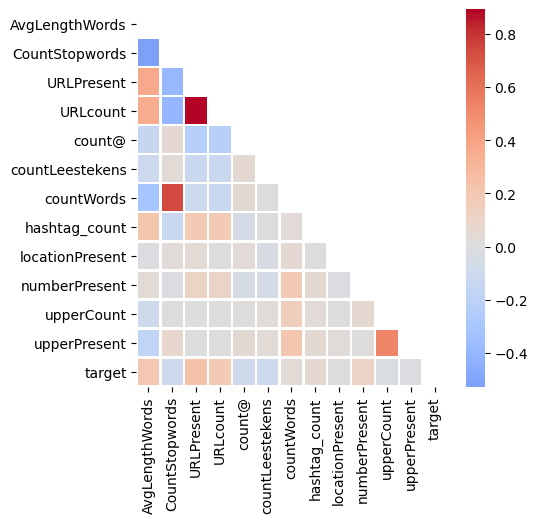

In [426]:
correlation = sorted(DRColumns) + dependent
correlation = data_raw[correlation].corr(method="pearson")
mask = np.triu(np.ones_like(correlation, dtype=bool))
fig = plt.figure(figsize=(5,5), dpi=100, facecolor = 'w', edgecolor="k")
figure = sns.heatmap(correlation, mask=mask, cmap= "coolwarm", center=0, linewidths=1, fmt=".2f")

#### BERT

In [427]:
model = SentenceTransformer('bert-base-nli-mean-tokens')

In [428]:
sentences = data_raw['text'].to_list()

In [429]:
sentence_embeddings = model.encode(sentences)

In [430]:
sentence_embeddings.shape

(10876, 768)

In [431]:
type(sentence_embeddings)

numpy.ndarray

#### DATAFRAME WITH ALL TAGS: data_TAGS

In [432]:
data_TAGS = data_raw[['target','TAG']]

In [433]:
# Create a column for each tag, if a tweet contains that tag, a 1 is added, if not a 0.
for x in listOfTags:
    data_TAGS[x] = data_TAGS.apply(lambda row: 1 if x in row.TAG else 0, axis = 1)

<ipython-input-433-e25a89d26ef4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_TAGS[x] = data_TAGS.apply(lambda row: 1 if x in row.TAG else 0, axis = 1)


In [434]:
data_TAGS.head()

,target,TAG,PRP$,NNS,VBP,DT,NNP,in,JJ,NN,...,LS,md,vbp,hyph,ls,fw,WP$,pdt,nn,xx
id,,,,,,,,,,,,,,,,,,,,,
1,1.0,PRP$ NNS VBP DT NNP IN DT JJ NN MD NNP VB PRP DT,1,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1.0,NN NN IN NNP NNP NNP . NNP,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,1.0,DT NNS VBD IN `` NN IN NN '' VBP VBG VBN IN NNS . DT JJ NN CC NN IN NN NNS VBP VBN,0,1,1,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
6,1.0,CD NNS VBP $ VBZ NN NNS IN NNP,0,1,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7,1.0,RB VBD VBN DT NN IN NNP NNP NNP IN NN IN PRP VBZ NNS IN DT NN,0,1,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [435]:
del data_TAGS['TAG']

In [436]:
# delete all inrelevant columns
del data_TAGS['add']
del data_TAGS['cd']
del data_TAGS['in']
del data_TAGS['nnp']
del data_TAGS['prp$']
del data_TAGS['to']
del data_TAGS['vb']
del data_TAGS['vbd']
del data_TAGS['wp']
del data_TAGS['_']
del data_TAGS['jj'] 
del data_TAGS['rp'] 
del data_TAGS['nns']
del data_TAGS['-lrb-']
del data_TAGS['-rrb-']
del data_TAGS['prp']
del data_TAGS['dt']
del data_TAGS['uh']
del data_TAGS['cc']
del data_TAGS['nnps']
del data_TAGS['vbz']
del data_TAGS['nfp']
del data_TAGS['sp']
del data_TAGS['pos']
del data_TAGS['md']
del data_TAGS['vbp']
del data_TAGS['hyph']
del data_TAGS['ls']
del data_TAGS['fw']
del data_TAGS['pdt']
del data_TAGS['nn']
del data_TAGS['xx']

In [437]:
tags = data_TAGS.columns.tolist()

In [438]:
tags.remove('target')

In [439]:
dependent = ['target']

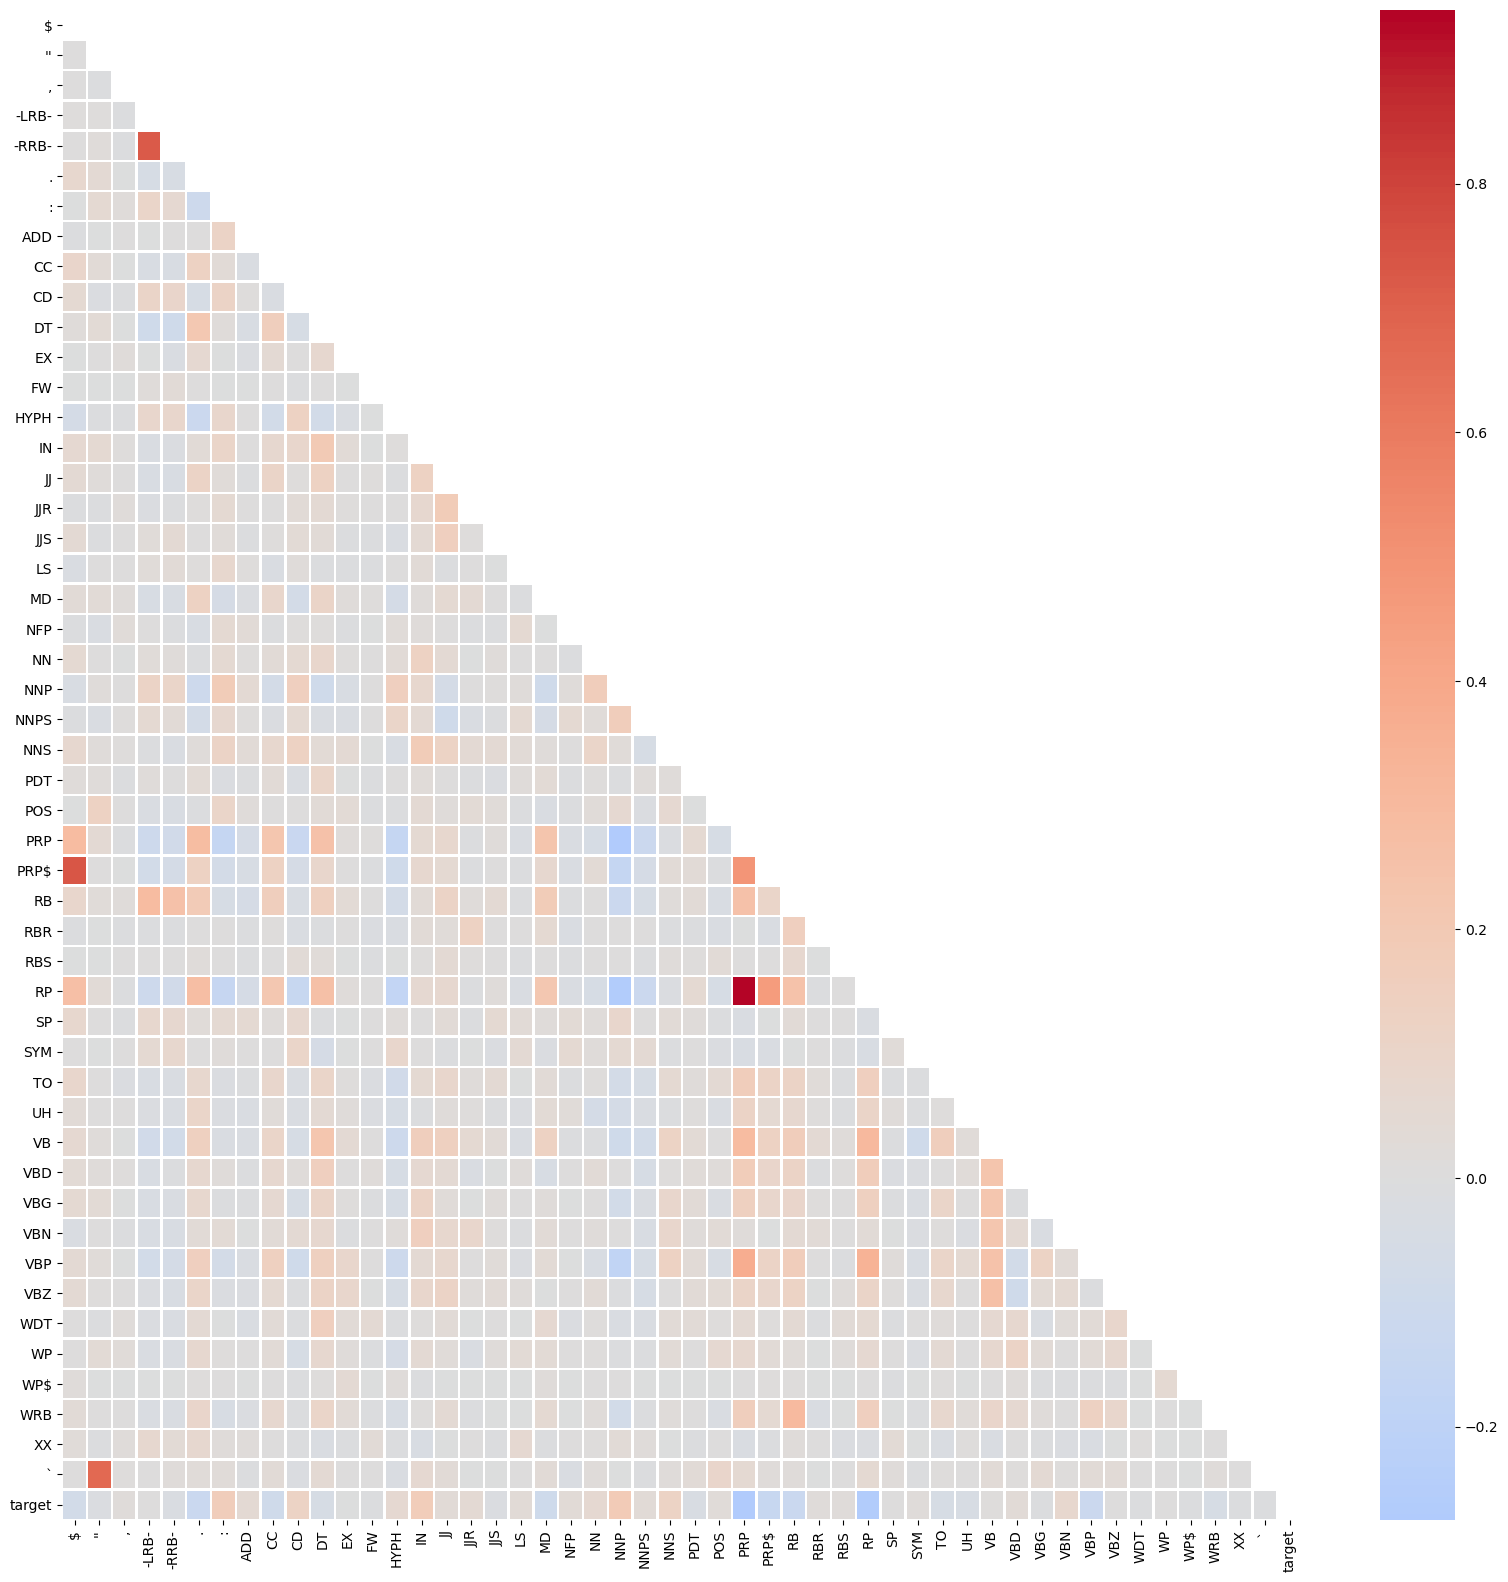

In [440]:
correlation = sorted(tags) + dependent
correlation = data_TAGS[correlation].corr(method="spearman")
mask = np.triu(np.ones_like(correlation, dtype=bool))
fig = plt.figure(figsize=(20,20), dpi=100, facecolor = 'w', edgecolor="k")
figure = sns.heatmap(correlation, mask=mask, cmap= "coolwarm", center=0, linewidths=1, fmt=".2f")

#### DATAFRAME WITH ALL NER_Labels: data_NERLabels

In [441]:
data_NERLabels = data_raw[['target','NER_label']]

In [442]:
# Create a column for each label, if a tweet contains that label, a 1 is added, if not a 0.
for x in listOfLabels:
    data_NERLabels[x] = data_NERLabels.apply(lambda row: 1 if x in row.NER_label else 0, axis = 1)

<ipython-input-442-8ed72a13a34e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_NERLabels[x] = data_NERLabels.apply(lambda row: 1 if x in row.NER_label else 0, axis = 1)


In [443]:
data_NERLabels.head()

,target,NER_label,org,FAC,gpe,CARDINAL,GPE,ORG,money,cardinal,...,PERSON,PERCENT,law,QUANTITY,quantity,percent,LAW,EVENT,language,LANGUAGE
id,,,,,,,,,,,,,,,,,,,,,
1,1.0,ORG,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,FAC GPE,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1.0,,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1.0,CARDINAL GPE,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1.0,FAC GPE CARDINAL,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [444]:
del data_NERLabels['NER_label']

In [445]:
# delete all inrelevant columns
del data_NERLabels['cardinal']
del data_NERLabels['date']
del data_NERLabels['event']
del data_NERLabels['fac']
del data_NERLabels['gpe']
del data_NERLabels['language']
del data_NERLabels['law']
del data_NERLabels['money']
del data_NERLabels['ordinal']
del data_NERLabels['org']
del data_NERLabels['percent']
del data_NERLabels['person']
del data_NERLabels['product']
del data_NERLabels['quantity']
del data_NERLabels['time']

In [446]:
labels = data_NERLabels.columns.tolist()

In [447]:
labels.remove('target')

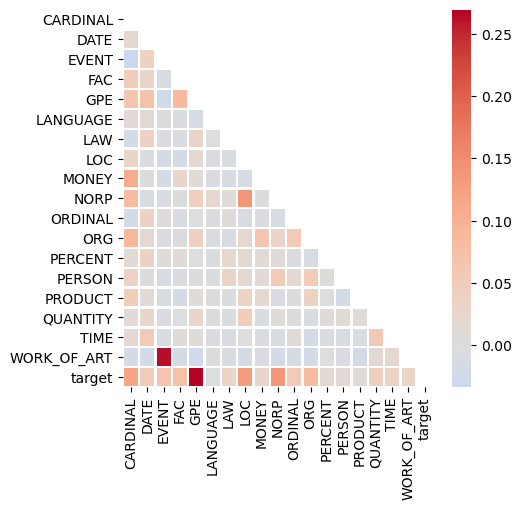

In [448]:
correlation = sorted(labels) + dependent
correlation = data_NERLabels[correlation].corr(method="spearman")
mask = np.triu(np.ones_like(correlation, dtype=bool))
fig = plt.figure(figsize=(5,5), dpi=100, facecolor = 'w', edgecolor="k")
figure = sns.heatmap(correlation, mask=mask, cmap= "coolwarm", center=0, linewidths=1, fmt=".2f")

#### DATAFRAME WITH ALL NER_text: data_NERtext

In [449]:
data_NERtext = data_raw[['target','NER_text']]

In [450]:
for key in dict_NERwords:
    data_NERtext[key]=''

<ipython-input-450-a5cbf45f224b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_NERtext[key]=''


In [451]:
data_NERtext.head()

,target,NER_text,#,-,the,year,2,&,two,of,...,and,Brown,MH370,swallow,Israel,Saudi,10,Legionnaires,Minute,least
id,,,,,,,,,,,,,,,,,,,,,
1,1.0,May ALLAH Forgive,,,,,,,,,...,,,,,,,,,,
4,1.0,La Ronge Sask Canada,,,,,,,,,...,,,,,,,,,,
5,1.0,,,,,,,,,,...,,,,,,,,,,
6,1.0,"13,000 California",,,,,,,,,...,,,,,,,,,,
7,1.0,Ruby # Alaska #,,,,,,,,,...,,,,,,,,,,


In [452]:
NERtextList = data_NERtext.columns.tolist()

In [453]:
NERtextList.remove('target')
NERtextList.remove('NER_text')

In [454]:
def countWordOccurance(text):
    counter = 0
    # Create Doc object
    doc = nlp(text, disable=['ner', 'parser'])
    # Generate lemmas
    lemmas = [token.lemma_ for token in doc]
    if x in lemmas:
        counter += 1
    return(counter)

In [455]:
for x in NERtextList:
    data_NERtext[x] = data_NERtext['NER_text'].apply(countWordOccurance)

In [456]:
data_NERtext.head()

,target,NER_text,#,-,the,year,2,&,two,of,...,and,Brown,MH370,swallow,Israel,Saudi,10,Legionnaires,Minute,least
id,,,,,,,,,,,,,,,,,,,,,
1,1.0,May ALLAH Forgive,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,La Ronge Sask Canada,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1.0,,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1.0,"13,000 California",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1.0,Ruby # Alaska #,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [457]:
labelsNERtext = data_NERtext.columns.tolist()

In [458]:
labelsNERtext.remove('target')
labelsNERtext.remove('NER_text')

In [459]:
correlated_Text = []
for x in labelsNERtext:
    correlation = data_NERtext[[x,'target']].corr(method="spearman").abs()
    if correlation.iloc[0,1]> 0.1:
        correlated_Text.append(x)
print(correlated_Text)

['California', 'Hiroshima']


In [460]:
WeaklyCorrelated_Text = []
for x in labelsNERtext:
    correlation = data_NERtext[[x,'target']].corr(method="spearman").abs()
    if correlation.iloc[0,1]> 0.05:
        WeaklyCorrelated_Text.append(x)
print(WeaklyCorrelated_Text)

['two', 'California', 'Hiroshima', 'News', 'Malaysia', '70', 'than', 'Obama', 'Japan', 'hundred', '40', 'PKK', 'in', 'mh370', 'U.S.', 'Turkey', '16yr', 'County', 'up', 'Northern', 'More', 'sandstorm', 'Island', 'Wildfire', 'Reunion', 'under', 'Get', 'airport', 'at', 'India', 'MH370', 'swallow', 'Saudi', 'Legionnaires', 'Minute']


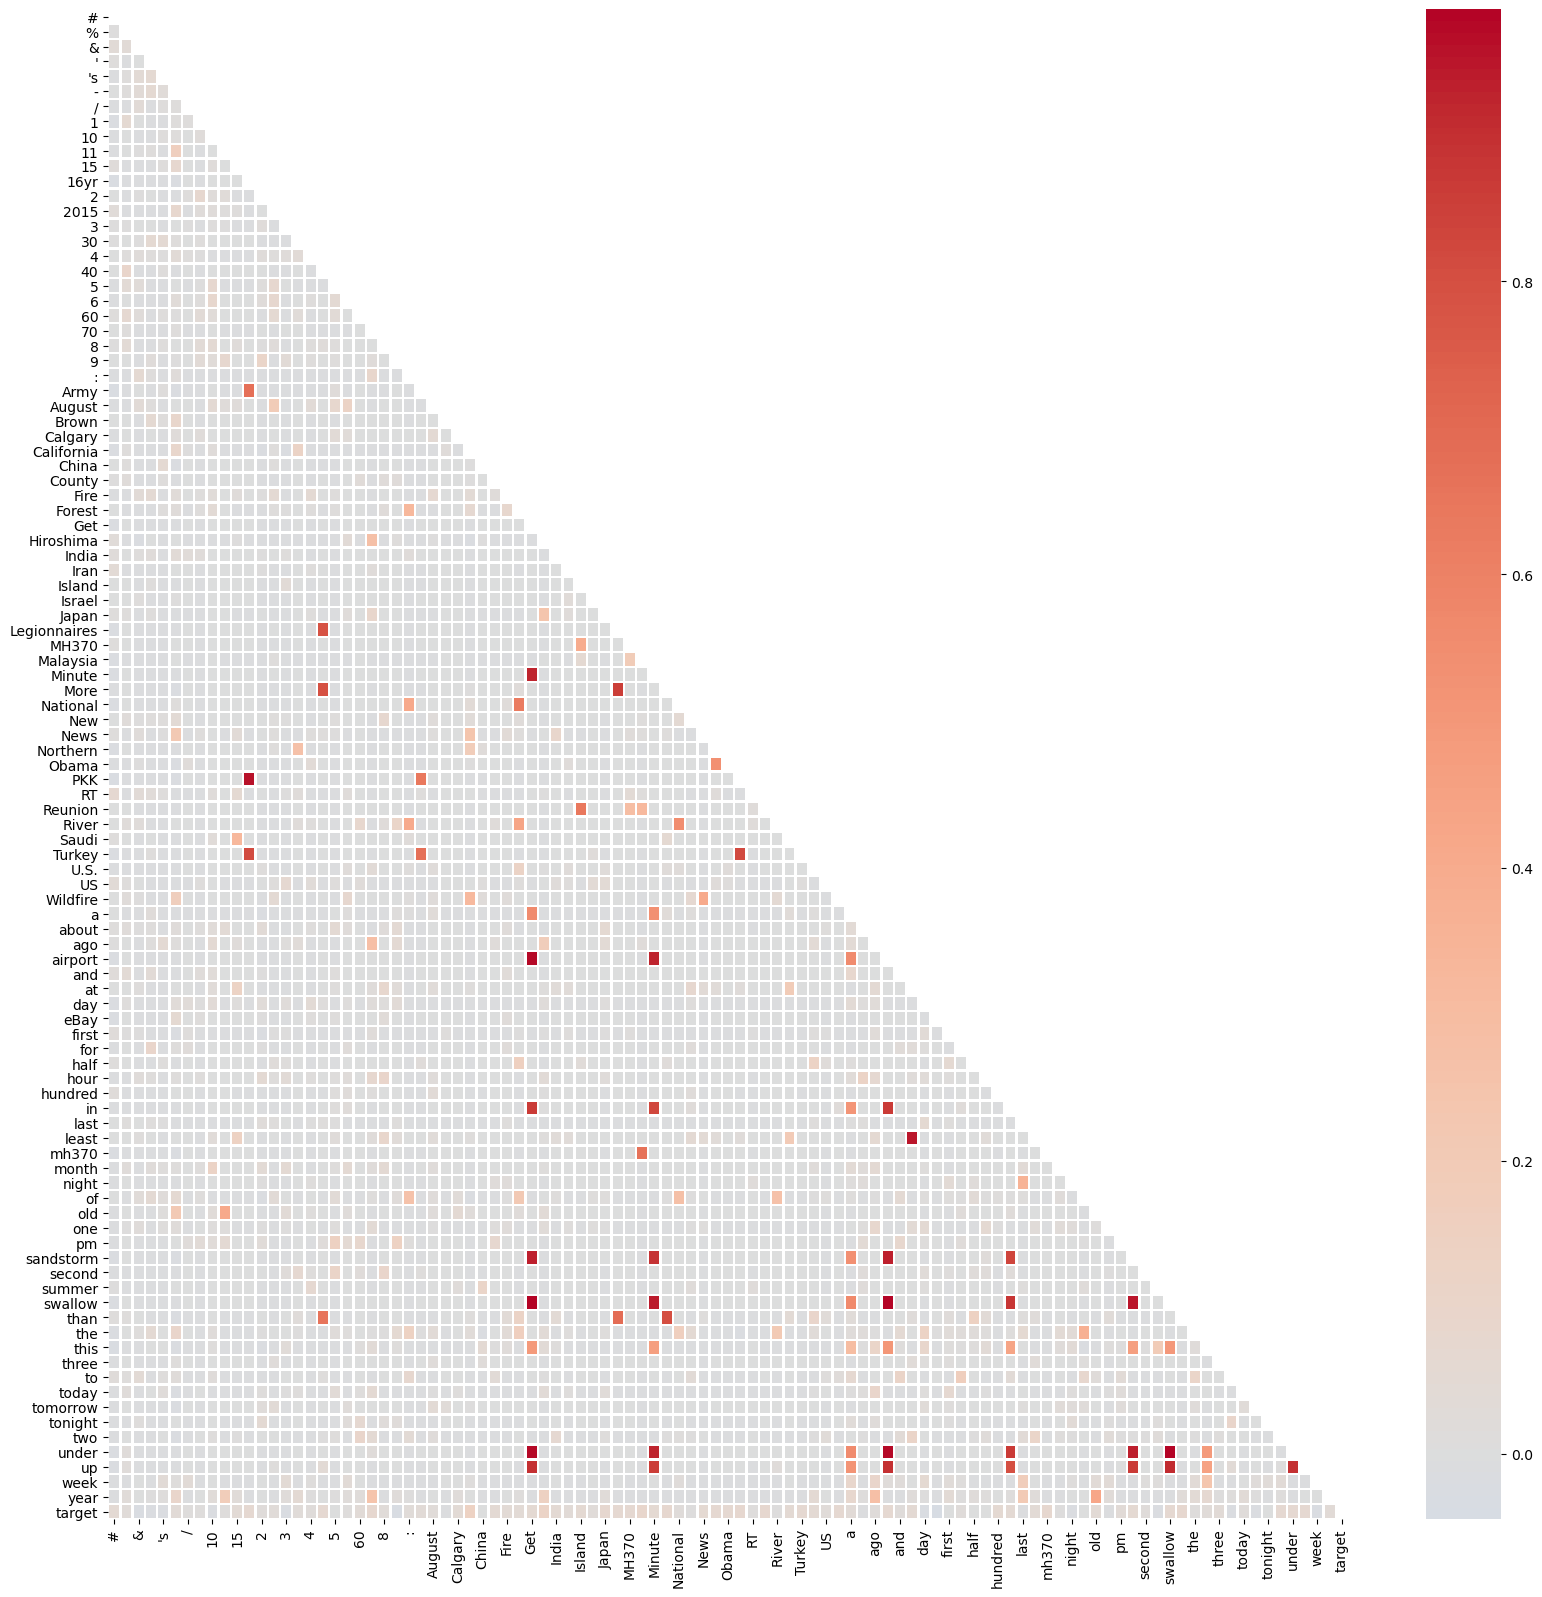

In [461]:
correlation = sorted(labelsNERtext) + dependent
correlation = data_NERtext[correlation].corr(method="spearman")
mask = np.triu(np.ones_like(correlation, dtype=bool))
fig = plt.figure(figsize=(20,20), dpi=100, facecolor = 'w', edgecolor="k")
figure = sns.heatmap(correlation, mask=mask, cmap= "coolwarm", center=0, linewidths=1, fmt=".2f")

In [462]:
data_NERtext = data_NERtext[['two', 'California', 'Hiroshima', 'News', 'Malaysia', '70', 'than', 'Obama', 'Japan', 'hundred', '40', 'PKK', 'in', 'mh370', 'U.S.', 'Turkey', '16yr', 'County', 'up', 'Northern', 'More', 'sandstorm', 'Island', 'Wildfire', 'Reunion', 'under', 'Get', 'airport', 'at', 'India', 'MH370', 'swallow', 'Saudi', 'Legionnaires', 'Minute']]

In [463]:
data_NERtext.head()

,two,California,Hiroshima,News,Malaysia,70,than,Obama,Japan,hundred,...,under,Get,airport,at,India,MH370,swallow,Saudi,Legionnaires,Minute
id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### DATAFRAME BERT: data_BERT

In [464]:
data_BERT = data_raw[['target']]

In [465]:
BERTje = pd.DataFrame(sentence_embeddings)

In [466]:
sentence_embeddings

array([[-0.09037049,  1.146987  ,  0.95534825, ...,  0.19953232,
        -0.6330688 ,  0.26890352],
       [-0.08536812,  0.8914547 , -0.05459208, ..., -0.46333596,
         0.16829593,  0.24627881],
       [-0.1301657 ,  0.61473006,  2.128242  , ...,  0.67237926,
        -0.8302878 , -0.18622954],
       ...,
       [ 0.10018918,  0.47121093, -0.30774832, ..., -0.81386924,
         0.20274307, -0.21935697],
       [ 0.0800776 ,  0.2163235 ,  1.2334727 , ..., -0.9201879 ,
        -0.11618561,  0.0628775 ],
       [ 0.36777672,  0.278361  ,  2.0686069 , ..., -0.30742073,
        -0.9129238 , -0.00277586]], dtype=float32)

In [467]:
BERTje.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.090370,1.146987,0.955348,-0.067624,-0.590531,-0.509537,1.662640,0.295671,-0.206041,-0.262102,...,0.094687,-0.665395,-0.398890,-1.689550,0.403670,-0.461717,-0.256847,0.199532,-0.633069,0.268904
1,-0.085368,0.891455,-0.054592,0.942166,0.624937,-0.775757,0.415069,0.877352,-0.160536,-0.249632,...,0.064165,-0.841207,-0.553268,0.091370,-0.716912,-0.962004,0.210643,-0.463336,0.168296,0.246279
2,-0.130166,0.614730,2.128242,-0.093432,0.152057,-0.802808,1.334652,0.046845,-0.250349,-0.884965,...,-0.599060,-0.637932,0.399394,-0.841256,-0.677216,-1.168649,-0.571752,0.672379,-0.830288,-0.186230
3,-0.055333,0.261434,-0.444716,0.245357,0.707143,-1.101034,0.451812,-0.171073,-0.839751,-0.251018,...,0.041855,-0.256512,-0.922277,-0.110944,0.424560,-0.623852,-0.058508,0.221534,0.898955,-0.117717
4,0.208457,0.910817,0.079580,0.657612,0.210677,-1.388687,1.403618,0.314656,0.279513,-0.287070,...,-0.269555,-1.138666,-1.764642,0.103436,0.080447,-1.085584,-0.117573,-0.135367,0.279245,0.269399


In [468]:
data_BERT = data_BERT.join(BERTje.set_index(data_BERT.index))

In [469]:
data_BERT.head()

,target,0,1,2,3,4,5,6,7,8,...,758,759,760,761,762,763,764,765,766,767
id,,,,,,,,,,,,,,,,,,,,,
1,1.0,-0.090370,1.146987,0.955348,-0.067624,-0.590531,-0.509537,1.662640,0.295671,-0.206041,...,0.094687,-0.665395,-0.398890,-1.689550,0.403670,-0.461717,-0.256847,0.199532,-0.633069,0.268904
4,1.0,-0.085368,0.891455,-0.054592,0.942166,0.624937,-0.775757,0.415069,0.877352,-0.160536,...,0.064165,-0.841207,-0.553268,0.091370,-0.716912,-0.962004,0.210643,-0.463336,0.168296,0.246279
5,1.0,-0.130166,0.614730,2.128242,-0.093432,0.152057,-0.802808,1.334652,0.046845,-0.250349,...,-0.599060,-0.637932,0.399394,-0.841256,-0.677216,-1.168649,-0.571752,0.672379,-0.830288,-0.186230
6,1.0,-0.055333,0.261434,-0.444716,0.245357,0.707143,-1.101034,0.451812,-0.171073,-0.839751,...,0.041855,-0.256512,-0.922277,-0.110944,0.424560,-0.623852,-0.058508,0.221534,0.898955,-0.117717
7,1.0,0.208457,0.910817,0.079580,0.657612,0.210677,-1.388687,1.403618,0.314656,0.279513,...,-0.269555,-1.138666,-1.764642,0.103436,0.080447,-1.085584,-0.117573,-0.135367,0.279245,0.269399


# START BUILDING MODELS

In [470]:
data_raw.head()

,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,hashtag_count,...,upperPresent,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text
id,,,,,,,,,,,,,,,,,,,,,
1,,,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1.0,13,4.153846,7,0,0,1,...,1,1,0,,,0,0,PRP$ NNS VBP DT NNP IN DT JJ NN MD NNP VB PRP DT,ORG,May ALLAH Forgive
4,,,Forest fire near La Ronge Sask. Canada,1.0,7,4.428571,0,0,0,0,...,0,0,0,,,0,0,NN NN IN NNP NNP NNP . NNP,FAC GPE,La Ronge Sask Canada
5,,,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1.0,22,4.318182,11,0,0,0,...,0,0,0,,,0,0,DT NNS VBD IN `` NN IN NN '' VBP VBG VBN IN NNS . DT JJ NN CC NN IN NN NNS VBP VBN,,
6,,,"13,000 people receive #wildfires evacuation orders in California",1.0,9,6.857143,1,0,0,1,...,0,0,0,,,0,0,CD NNS VBP $ VBZ NN NNS IN NNP,CARDINAL GPE,"13,000 California"
7,,,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1.0,17,4.250000,8,0,0,2,...,0,0,0,,,0,0,RB VBD VBN DT NN IN NNP NNP NNP IN NN IN PRP VBZ NNS IN DT NN,FAC GPE CARDINAL,Ruby # Alaska #


In [471]:
data_raw.columns.to_list()

['keyword',
 'location',
 'text',
 'target',
 'countWords',
 'AvgLengthWords',
 'CountStopwords',
 'countLeestekens',
 'count@',
 'hashtag_count',
 'hashtag',
 'tokenized',
 'transcript',
 'numbers',
 'numberPresent',
 'upper',
 'upperPresent',
 'upperCount',
 'locationPresent',
 'LocationTranscript',
 'URL',
 'URLPresent',
 'URLcount',
 'TAG',
 'NER_label',
 'NER_text']

In [472]:
data = data_raw[['target','numberPresent','countWords','AvgLengthWords','countLeestekens','upperPresent','hashtag_count','locationPresent','URLcount', 'count@','CountStopwords']]

In [473]:
data.head()

,target,numberPresent,countWords,AvgLengthWords,countLeestekens,upperPresent,hashtag_count,locationPresent,URLcount,count@,CountStopwords
id,,,,,,,,,,,
1,1.0,0,13,4.153846,0,1,1,0,0,0,7
4,1.0,0,7,4.428571,0,0,0,0,0,0,0
5,1.0,0,22,4.318182,0,0,0,0,0,0,11
6,1.0,1,9,6.857143,0,0,1,0,0,0,1
7,1.0,0,17,4.250000,0,0,2,0,0,0,8


In [474]:
data_Keyword.head()

,target,keyword,0,1,2,3,4,5
0,NaN,,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,,0.0,0.0,0.0,0.0,0.0,0.0
2,NaN,,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,,0.0,0.0,0.0,0.0,0.0,0.0


In [475]:
data_Keyword = data_Keyword.rename(columns={0: 'Col_0', 1: 'Col_1', 2: 'Col_2', 3: 'Col_3', 4: 'Col_4', 5: 'Col_5'})

In [476]:
del data_Keyword['target']
del data_Keyword['keyword']

In [477]:
data = data.join(data_Keyword.set_index(data.index))

In [478]:
data.head()

,target,numberPresent,countWords,AvgLengthWords,countLeestekens,upperPresent,hashtag_count,locationPresent,URLcount,count@,CountStopwords,Col_0,Col_1,Col_2,Col_3,Col_4,Col_5
id,,,,,,,,,,,,,,,,,
1,1.0,0,13,4.153846,0,1,1,0,0,0,7,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0,7,4.428571,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0,22,4.318182,0,0,0,0,0,0,11,0.0,0.0,0.0,0.0,0.0,0.0
6,1.0,1,9,6.857143,0,0,1,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0
7,1.0,0,17,4.250000,0,0,2,0,0,0,8,0.0,0.0,0.0,0.0,0.0,0.0


In [479]:
data = data.join(BERTje.set_index(data.index))

In [480]:
data.head()

,target,numberPresent,countWords,AvgLengthWords,countLeestekens,upperPresent,hashtag_count,locationPresent,URLcount,count@,...,758,759,760,761,762,763,764,765,766,767
id,,,,,,,,,,,,,,,,,,,,,
1,1.0,0,13,4.153846,0,1,1,0,0,0,...,0.094687,-0.665395,-0.398890,-1.689550,0.403670,-0.461717,-0.256847,0.199532,-0.633069,0.268904
4,1.0,0,7,4.428571,0,0,0,0,0,0,...,0.064165,-0.841207,-0.553268,0.091370,-0.716912,-0.962004,0.210643,-0.463336,0.168296,0.246279
5,1.0,0,22,4.318182,0,0,0,0,0,0,...,-0.599060,-0.637932,0.399394,-0.841256,-0.677216,-1.168649,-0.571752,0.672379,-0.830288,-0.186230
6,1.0,1,9,6.857143,0,0,1,0,0,0,...,0.041855,-0.256512,-0.922277,-0.110944,0.424560,-0.623852,-0.058508,0.221534,0.898955,-0.117717
7,1.0,0,17,4.250000,0,0,2,0,0,0,...,-0.269555,-1.138666,-1.764642,0.103436,0.080447,-1.085584,-0.117573,-0.135367,0.279245,0.269399


In [481]:
data_NERLabels.head()

,target,FAC,CARDINAL,GPE,ORG,NORP,TIME,MONEY,ORDINAL,DATE,LOC,WORK_OF_ART,PRODUCT,PERSON,PERCENT,QUANTITY,LAW,EVENT,LANGUAGE
id,,,,,,,,,,,,,,,,,,,
1,1.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1.0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [483]:
del data_NERLabels['target']

In [484]:
data = data.join(data_NERLabels.set_index(data.index))

In [485]:
data.head()

,target,numberPresent,countWords,AvgLengthWords,countLeestekens,upperPresent,hashtag_count,locationPresent,URLcount,count@,...,DATE,LOC,WORK_OF_ART,PRODUCT,PERSON,PERCENT,QUANTITY,LAW,EVENT,LANGUAGE
id,,,,,,,,,,,,,,,,,,,,,
1,1.0,0,13,4.153846,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0,7,4.428571,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1.0,0,22,4.318182,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1.0,1,9,6.857143,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1.0,0,17,4.250000,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [486]:
data_TAGS.head()

,target,PRP$,NNS,VBP,DT,NNP,JJ,NN,MD,VB,...,WDT,SYM,-LRB-,RBS,TO,ADD,IN,PDT,LS,WP$
id,,,,,,,,,,,,,,,,,,,,,
1,1.0,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,1,0,0,0
4,1.0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
5,1.0,0,1,1,1,0,1,1,0,1,...,0,0,0,0,0,0,1,0,0,0
6,1.0,0,1,1,0,1,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
7,1.0,0,1,0,1,1,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0


In [487]:
del data_TAGS['target']

In [488]:
data = data.join(data_TAGS.set_index(data.index))

In [489]:
data.head()

,target,numberPresent,countWords,AvgLengthWords,countLeestekens,upperPresent,hashtag_count,locationPresent,URLcount,count@,...,WDT,SYM,-LRB-,RBS,TO,ADD,IN,PDT,LS,WP$
id,,,,,,,,,,,,,,,,,,,,,
1,1.0,0,13,4.153846,0,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1.0,0,7,4.428571,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5,1.0,0,22,4.318182,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
6,1.0,1,9,6.857143,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
7,1.0,0,17,4.250000,0,0,2,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [490]:
#data.columns.to_list()

In [491]:
data_NERtext.head()

,two,California,Hiroshima,News,Malaysia,70,than,Obama,Japan,hundred,...,under,Get,airport,at,India,MH370,swallow,Saudi,Legionnaires,Minute
id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [496]:
NERtext_columns = data_NERtext.columns.to_list()

In [497]:
#del data_NERtext['target']
#del data_NERtext['NER_text']

In [498]:
for x in NERtext_columns:
    data_NERtext = data_NERtext.rename(columns={x: 'NER_'+x})

In [499]:
data = data.join(data_NERtext.set_index(data.index))

In [500]:
data_New.head()

,countTweets
id,
1,1
4,1
5,1
6,1
7,1


In [501]:
data = data.join(data_New.set_index(data.index))

In [528]:
data_train = data.loc[(data['target'].notna())]
data_toPredict = data.loc[(data['target'].isna())]

#### LOGISTIC REGRESSION

In [529]:
x1 = data_train.drop(columns=["target"]).values
y1 = data_train["target"].values

In [530]:
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, train_size=0.8, test_size=0.2, random_state=1)

In [531]:
lr = LogisticRegression(solver='lbfgs', max_iter=1500)

In [532]:
lr.fit(x1_train, y1_train)

LogisticRegression(max_iter=1500)

In [533]:
print(lr.score(x1_train, y1_train))

0.8798029556650246


In [534]:
print(lr.score(x1_test, y1_test))

0.8095863427445831


In [535]:
scaler = StandardScaler()

In [536]:
y1_predict = lr.predict(x1_test)

In [537]:
print(confusion_matrix(y1_test, y1_predict))
print(classification_report(y1_test, y1_predict))

[[762 134]
 [156 471]]
              precision    recall  f1-score   support

         0.0       0.83      0.85      0.84       896
         1.0       0.78      0.75      0.76       627

    accuracy                           0.81      1523
   macro avg       0.80      0.80      0.80      1523
weighted avg       0.81      0.81      0.81      1523



In [538]:
y2_predict = lr.predict(x1)

In [539]:
print(confusion_matrix(y1, y2_predict))
print(classification_report(y1, y2_predict))

[[3970  421]
 [ 601 2621]]
              precision    recall  f1-score   support

         0.0       0.87      0.90      0.89      4391
         1.0       0.86      0.81      0.84      3222

    accuracy                           0.87      7613
   macro avg       0.87      0.86      0.86      7613
weighted avg       0.87      0.87      0.87      7613



In [540]:
#scaler.fit(x1)

In [541]:
lr.fit(x1, y1)

LogisticRegression(max_iter=1500)

In [542]:
print(lr.score(x1, y1))

0.8706160514908708


In [543]:
del data_toPredict['target']

In [544]:
TrueTweets = lr.predict(data_toPredict)

In [545]:
TrueTweetsList = []

In [546]:
for x in TrueTweets:
    TrueTweetsList.append(int(x))

In [547]:
submission = data_raw.loc[(data_raw['target'].isna())]
submission.head()

,keyword,location,text,target,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,hashtag_count,...,upperPresent,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text
id,,,,,,,,,,,,,,,,,,,,,
0,,,Just happened a terrible car crash,NaN,6,4.500000,2,0,0,0,...,0,0,0,,,0,0,RB VBD DT JJ NN NN,,
2,,,"Heard about #earthquake is different cities, stay safe everyone.",NaN,9,5.555556,2,0,0,1,...,0,0,0,,,0,0,"VBN IN $ NN VBZ JJ NNS , VB JJ NN .",ORG,Heard
3,,,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all",NaN,19,3.600000,10,0,0,0,...,1,1,0,,,0,0,"EX VBZ DT NN NN IN NN NN , JJ VBP VBG IN DT NN , PRP MD RB VB PRP DT",,
9,,,Apocalypse lighting. #Spokane #wildfires,NaN,4,8.250000,0,0,0,2,...,0,0,0,,,0,0,NN NN . CD NN NN VBZ,ORG MONEY,Apocalypse #Spokane #
11,,,Typhoon Soudelor kills 28 in China and Taiwan,NaN,8,5.000000,2,0,0,0,...,0,0,0,,,0,0,NNP NNP VBZ CD IN NNP CC NNP,CARDINAL GPE GPE,28 China Taiwan


In [548]:
del submission['target']

In [549]:
submission['target'] = np.array(TrueTweetsList)

<ipython-input-549-303e98abcfba>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['target'] = np.array(TrueTweetsList)


In [550]:
submission.head()

,keyword,location,text,countWords,AvgLengthWords,CountStopwords,countLeestekens,count@,hashtag_count,hashtag,...,upperCount,locationPresent,LocationTranscript,URL,URLPresent,URLcount,TAG,NER_label,NER_text,target
id,,,,,,,,,,,,,,,,,,,,,
0,,,Just happened a terrible car crash,6,4.500000,2,0,0,0,[],...,0,0,,,0,0,RB VBD DT JJ NN NN,,,1
2,,,"Heard about #earthquake is different cities, stay safe everyone.",9,5.555556,2,0,0,1,[#earthquake],...,0,0,,,0,0,"VBN IN $ NN VBZ JJ NNS , VB JJ NN .",ORG,Heard,1
3,,,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all",19,3.600000,10,0,0,0,[],...,1,0,,,0,0,"EX VBZ DT NN NN IN NN NN , JJ VBP VBG IN DT NN , PRP MD RB VB PRP DT",,,1
9,,,Apocalypse lighting. #Spokane #wildfires,4,8.250000,0,0,0,2,"[#Spokane, #wildfires]",...,0,0,,,0,0,NN NN . CD NN NN VBZ,ORG MONEY,Apocalypse #Spokane #,1
11,,,Typhoon Soudelor kills 28 in China and Taiwan,8,5.000000,2,0,0,0,[],...,0,0,,,0,0,NNP NNP VBZ CD IN NNP CC NNP,CARDINAL GPE GPE,28 China Taiwan,1


In [551]:
submission = submission[['target']]

<AxesSubplot:xlabel='target', ylabel='count'>

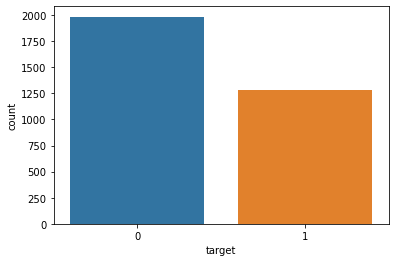

In [552]:
sns.countplot(x="target", data=submission)

In [553]:
submission.to_csv("C:/Users/meykevandenbos/Documents/Meyke persoonlijk/Techionista/ML/NLP/prediction_submission30052021-2.csv")

#### NAIVE BAYES

In [554]:
model = GaussianNB()

In [555]:
model.fit(x1_train, y1_train)

GaussianNB()

In [556]:
print(model.score(x1_train, y1_train))

0.6724137931034483


In [557]:
print(model.score(x1_test, y1_test))

0.6894287590282338


#### LOG REGRESSION ON BERT ALONE

In [558]:
data_BERT.head()

,target,0,1,2,3,4,5,6,7,8,...,758,759,760,761,762,763,764,765,766,767
id,,,,,,,,,,,,,,,,,,,,,
1,1.0,-0.090370,1.146987,0.955348,-0.067624,-0.590531,-0.509537,1.662640,0.295671,-0.206041,...,0.094687,-0.665395,-0.398890,-1.689550,0.403670,-0.461717,-0.256847,0.199532,-0.633069,0.268904
4,1.0,-0.085368,0.891455,-0.054592,0.942166,0.624937,-0.775757,0.415069,0.877352,-0.160536,...,0.064165,-0.841207,-0.553268,0.091370,-0.716912,-0.962004,0.210643,-0.463336,0.168296,0.246279
5,1.0,-0.130166,0.614730,2.128242,-0.093432,0.152057,-0.802808,1.334652,0.046845,-0.250349,...,-0.599060,-0.637932,0.399394,-0.841256,-0.677216,-1.168649,-0.571752,0.672379,-0.830288,-0.186230
6,1.0,-0.055333,0.261434,-0.444716,0.245357,0.707143,-1.101034,0.451812,-0.171073,-0.839751,...,0.041855,-0.256512,-0.922277,-0.110944,0.424560,-0.623852,-0.058508,0.221534,0.898955,-0.117717
7,1.0,0.208457,0.910817,0.079580,0.657612,0.210677,-1.388687,1.403618,0.314656,0.279513,...,-0.269555,-1.138666,-1.764642,0.103436,0.080447,-1.085584,-0.117573,-0.135367,0.279245,0.269399


In [559]:
data_train2 = data_BERT.loc[(data['target'].notna())]
data_toPredict2 = data_BERT.loc[(data['target'].isna())]

In [560]:
x2 = data_train2.drop(columns=["target"]).values
y2 = data_train2["target"].values

In [561]:
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, train_size=0.8, test_size=0.2, random_state=1)

In [562]:
lr.fit(x2_train, y2_train)

LogisticRegression(max_iter=1500)

In [563]:
print(lr.score(x2_train, y2_train))

0.8727422003284072


In [564]:
print(lr.score(x2_test, y2_test))

0.8017071569271176


In [565]:
y2_predict = lr.predict(x2_test)

In [566]:
print(confusion_matrix(y2_test, y2_predict))
print(classification_report(y2_test, y2_predict))

[[751 145]
 [157 470]]
              precision    recall  f1-score   support

         0.0       0.83      0.84      0.83       896
         1.0       0.76      0.75      0.76       627

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



In [567]:
del data_toPredict2['target']

In [568]:
TrueTweets = lr.predict(data_toPredict2)

In [569]:
TrueTweetsList = []

In [570]:
for x in TrueTweets:
    TrueTweetsList.append(int(x))

In [571]:
submission = data_BERT.loc[(data_BERT['target'].isna())]
submission.head()

,target,0,1,2,3,4,5,6,7,8,...,758,759,760,761,762,763,764,765,766,767
id,,,,,,,,,,,,,,,,,,,,,
0,NaN,0.224300,0.354355,0.605816,-0.077598,-0.347128,-0.188260,0.838588,0.661600,0.412811,...,0.472520,-0.334699,-0.749108,-0.982069,0.273052,-0.675515,0.068435,-1.561704,-0.160441,-0.089933
2,NaN,0.198845,0.244761,1.596686,-0.020858,-0.132349,-0.826379,1.223316,0.333736,-0.597071,...,0.147171,-0.022318,0.018156,-0.763147,-0.255365,-0.214110,-0.198642,0.133310,-0.494291,0.268285
3,NaN,-0.079086,1.278903,0.548030,0.474499,-0.035957,-0.265957,1.391292,0.089181,0.069013,...,-0.504114,-0.508984,-0.820288,-0.599721,-0.349479,-1.077655,-0.101639,-0.194637,0.035111,-0.110025
9,NaN,0.166050,0.711685,1.012481,0.741662,0.104257,-1.150330,1.380311,0.535587,0.218389,...,-0.021452,-0.307698,-0.526798,-0.051186,-0.514628,-0.738068,0.290500,-0.760113,0.564432,0.004591
11,NaN,0.137476,0.785803,-0.432203,-0.138307,-0.257267,-0.350795,0.429170,0.567547,0.458111,...,-0.045815,-0.119787,-0.550359,0.509422,0.029961,-0.357622,-0.122245,-0.335094,0.561010,0.030296


In [572]:
submission['target'] = np.array(TrueTweetsList)

<ipython-input-572-303e98abcfba>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['target'] = np.array(TrueTweetsList)


In [573]:
submission = submission[['target']]

In [574]:
submission.head()

,target
id,
0,1
2,1
3,1
9,1
11,1


<AxesSubplot:xlabel='target', ylabel='count'>

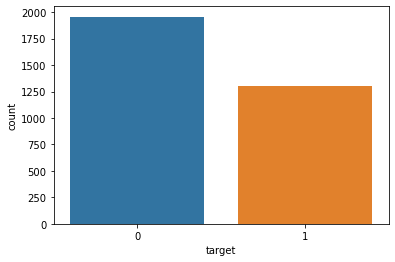

In [575]:
sns.countplot(x="target", data=submission)

In [577]:
submission.to_csv("C:/Users/meykevandenbos/Documents/Meyke persoonlijk/Techionista/ML/NLP/prediction_submission30052021-3.csv")